# Perform Sample Quality Control

In this notebook we are performing sample quality control and remove samples that have previously been identified as potential swaps as well as look directly at the read counts to identify potential swaps.

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(SummarizedExperiment))
source('../prj_helpers.R')
library(DESeq2)

In [2]:
# load previously generated summarized experiment
se <- readRDS('../02-load_fix_metadata/se_20210914.rds')

In [3]:
se

class: SummarizedExperiment 
dim: 35405 333 
metadata(0):
assays(1): counts
rownames(35405): ENSMMUG00000023296.4 ENSMMUG00000036181.3 ... EBOV-L
  EBOV-3pTrailer
rowData names(12): Geneid Chr ... external_gene_source description
colnames(333): A0001_S121_L002 A0002_S124_L002 ...
  Zyagen_D000_Spleen.190507_long_S1 Zyagen_D000_Testis.160421_long_S16
colData names(67): file_identifiers A.identifier ... sample_id_dedup
  duplicate_sequencing

In [4]:
# Set default plot size
options(repr.plot.width = 10, repr.plot.height = 10)

In [5]:
table(colData(se)[,c("full.tissue","dpi_time")])

                     dpi_time
full.tissue           -30 -28 -14 -4  0  1  2  3  4  5  6  7  8
  Adrenal Gland         0   0   0  0  3  0  0  2  2  1  3  2  1
  Brain:Brain-Gr        0   0   0  0  3  0  0  3  3  3  5  2  2
  Brain:Brain-Wh        0   0   0  0  1  0  0  1  1  3  1  2  1
  Kidney                0   0   0  0  3  0  0  3  2  3  5  2  2
  Liver                 0   0   0  0  1  0  0  1  3  3  5  1  2
  Lung                  0   0   0  0  0  0  0  1  2  3  4  1  1
  Lymph node:LN-AX-R    0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:LN-ING-L   0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:LN-MES     0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:NA         0   0   0  0  0  0  0  0  0  0  0  0  0
  Ovary                 0   0   0  0  0  0  0  0  0  0  0  0  0
  PBMC                  0   0   0  0  0  0  0  2  2  1  6  0  0
  Sex Organ:Ovary       0   0   0  0  2  0  0  2  0  2  3  2  0
  Sex Organ:Sex-Organ   0   0   0  0  2  0  0  2  3  1  3  1  0
  Sex Orga

## Remove libraries with few reads

In [6]:
# This is the cutoff for removing libraries with low numbers of umis to the host transcriptome
#host.read.cutoff <- 1e6/4
host.read.cutoff <- 100000
host.read.cutoff

[1] 1e+05

In [7]:
keep.samples.bool <- colData(se)$hostReadCount > host.read.cutoff

In [8]:
table(keep.samples.bool)

keep.samples.bool
FALSE  TRUE 
   16   317 

Here is list of the 25 samples that are removed due to low number of reads

In [9]:
rownames(colData(se))[!keep.samples.bool]

[1] "A0011"               "A0068_S1_L001"       "A0081_S22_L001"     
 [4] "A0102"               "A0130_S8_L001"       "A0151_S20_L001"     
 [7] "A0152_S118_L002"     "A0158_S26_L002"      "A0165_L1"           
[10] "A0182_S31_L002"      "A0193_S17_L001"      "A0222_S110_L002"    
[13] "A0228"               "A0237_S26_L001"      "A0241_S37_L002"     
[16] "RA0223_PBMC_D003_S7"

In [10]:
rownames(colData(se))[!keep.samples.bool & colData(se)$tissue != 'PBMC']

[1] "A0011"           "A0068_S1_L001"   "A0081_S22_L001"  "A0102"          
 [5] "A0130_S8_L001"   "A0151_S20_L001"  "A0152_S118_L002" "A0158_S26_L002" 
 [9] "A0165_L1"        "A0182_S31_L002"  "A0193_S17_L001"  "A0222_S110_L002"
[13] "A0228"           "A0237_S26_L001"  "A0241_S37_L002"

In [11]:
# get some information on the samples we are removing
samples.remove.meta <- as.data.frame(colData(se)[!keep.samples.bool,c('tissue','sex','id.cohort','Assigned','hostReadCount')])

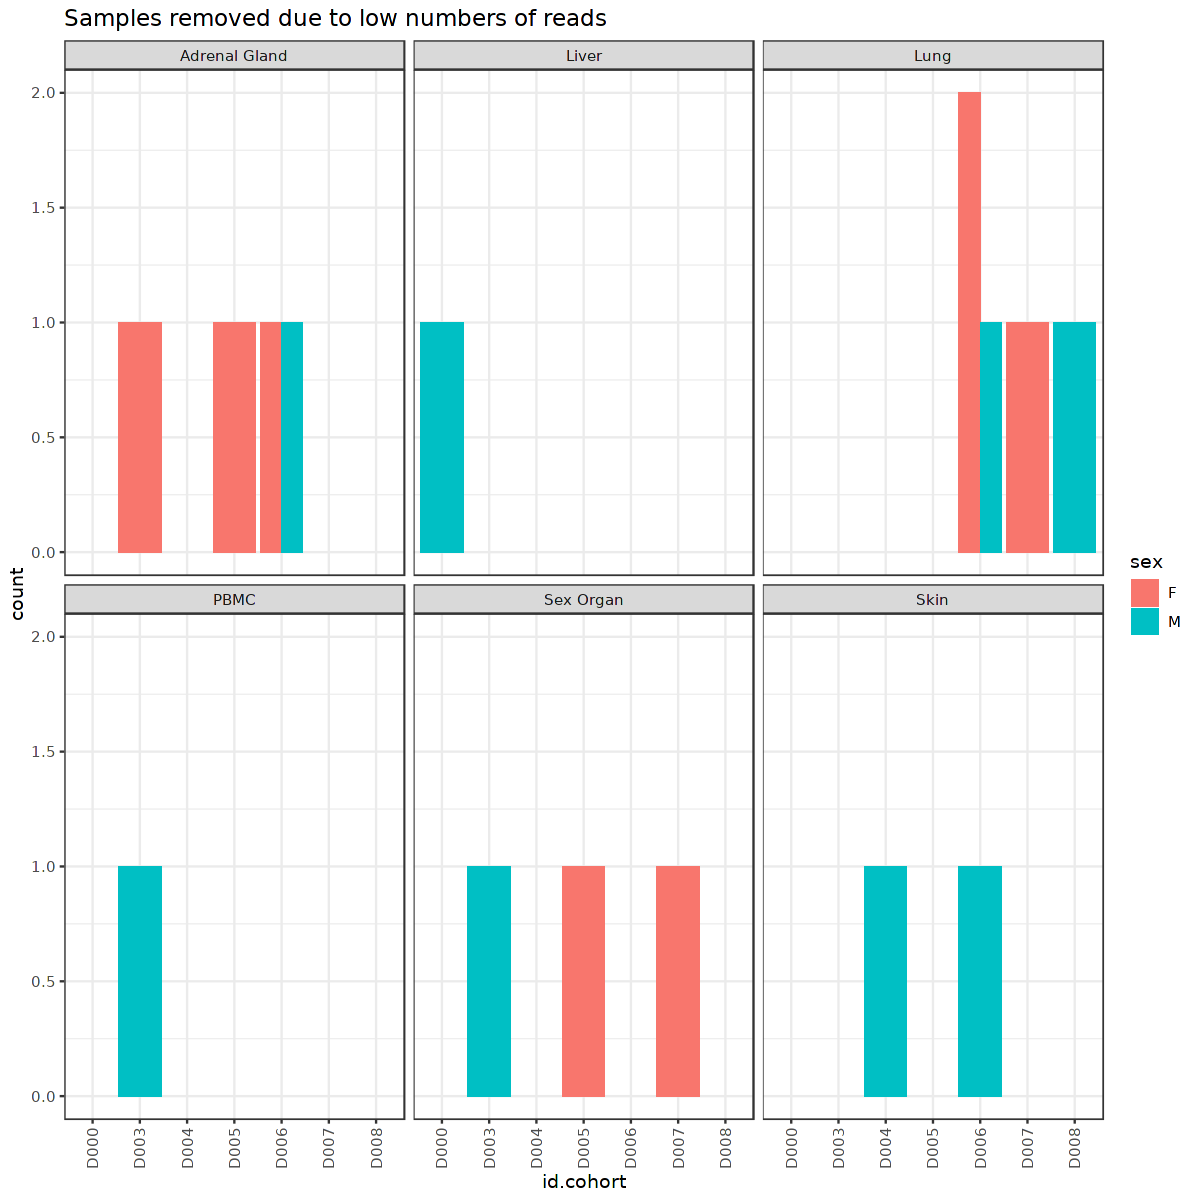

In [12]:
# A breakdown of the samples that removed due to low number of reads
ggplot(samples.remove.meta, aes(x=id.cohort,fill=sex)) + 
    geom_bar(position='dodge') + facet_wrap(~tissue) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle('Samples removed due to low numbers of reads')

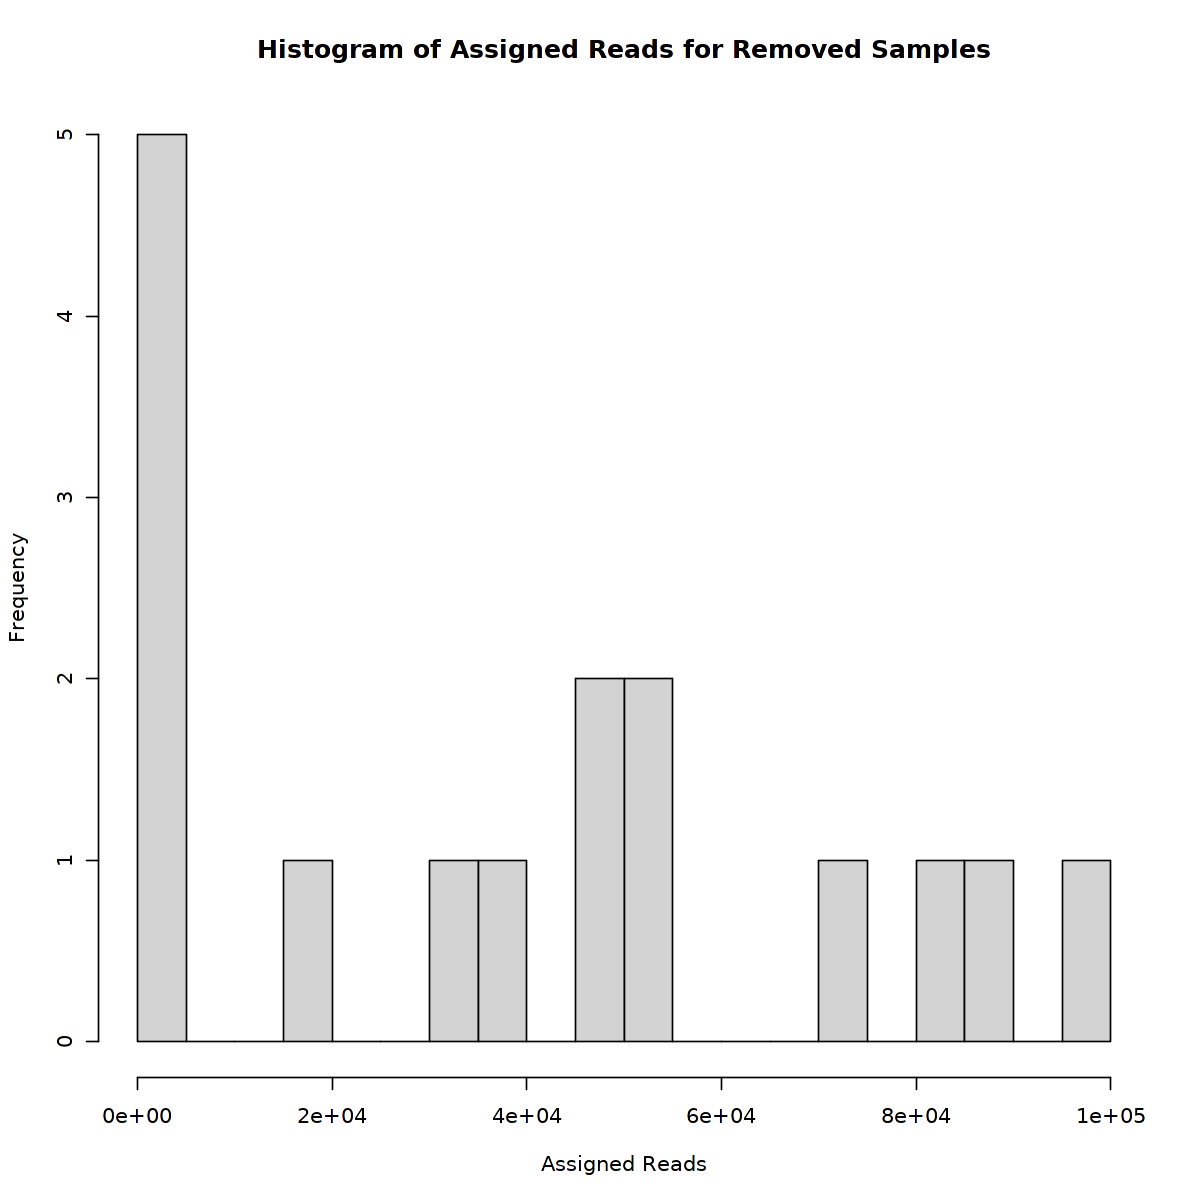

In [13]:
# Histogram of number of assigned reads for these samples
hist(colData(se)[!keep.samples.bool,c('Assigned')],
     breaks=20, 
     main="Histogram of Assigned Reads for Removed Samples",
     xlab="Assigned Reads")

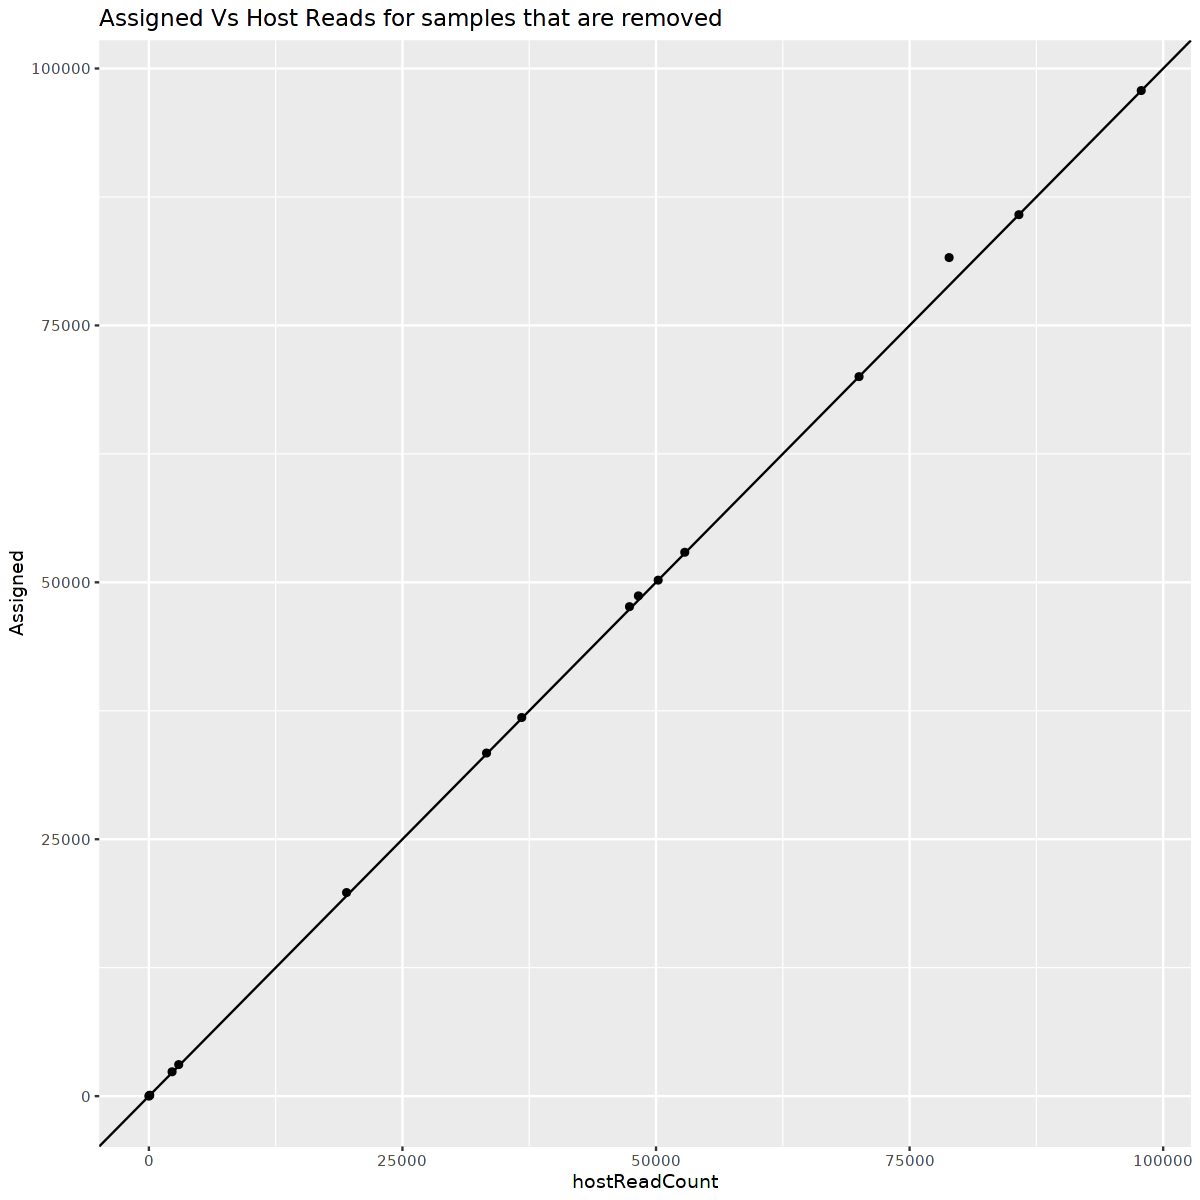

In [14]:
ggplot(
    as.data.frame(colData(se)[!keep.samples.bool,]),
    aes(x=hostReadCount,y=Assigned)) + geom_point() + geom_abline(slope=1) +
    ggtitle('Assigned Vs Host Reads for samples that are removed')

In [15]:
# remove low read samples
se.qc.remove_low_read <- se[,keep.samples.bool]

## Remove samples with predicted/recorded sex mismatch

In [16]:
keep.sex.mismatch <- !NA2FALSE(colData(se.qc.remove_low_read)$pred_rec_sex_mismatch)

In [17]:
table(keep.sex.mismatch)

keep.sex.mismatch
FALSE  TRUE 
    1   316 

#These are the samples actually removed

In [18]:
rownames(colData(se.qc.remove_low_read))[!keep.sex.mismatch]

[1] "RA0700.Liver_S9"

In [19]:
se.qc.remove_sex_mismatch <- se.qc.remove_low_read[,keep.sex.mismatch]

## Perform PCA and check for mismatches in tissues

In [20]:
se.qc.remove_sex_mismatch

class: SummarizedExperiment 
dim: 35405 316 
metadata(0):
assays(1): counts
rownames(35405): ENSMMUG00000023296.4 ENSMMUG00000036181.3 ... EBOV-L
  EBOV-3pTrailer
rowData names(12): Geneid Chr ... external_gene_source description
colnames(316): A0001_S121_L002 A0002_S124_L002 ...
  Zyagen_D000_Spleen.190507_long_S1 Zyagen_D000_Testis.160421_long_S16
colData names(67): file_identifiers A.identifier ... sample_id_dedup
  duplicate_sequencing

In [21]:
dds.qc <- DESeqDataSet(se.qc.remove_sex_mismatch, design = ~1)

In [22]:
dds.qc <- DESeq(dds.qc)

Warning message in DESeq(dds.qc):
“the design is ~ 1 (just an intercept). is this intended?”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4892 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [23]:
# perform variance stabilizing transformation
vsd.qc <- vst(dds.qc)

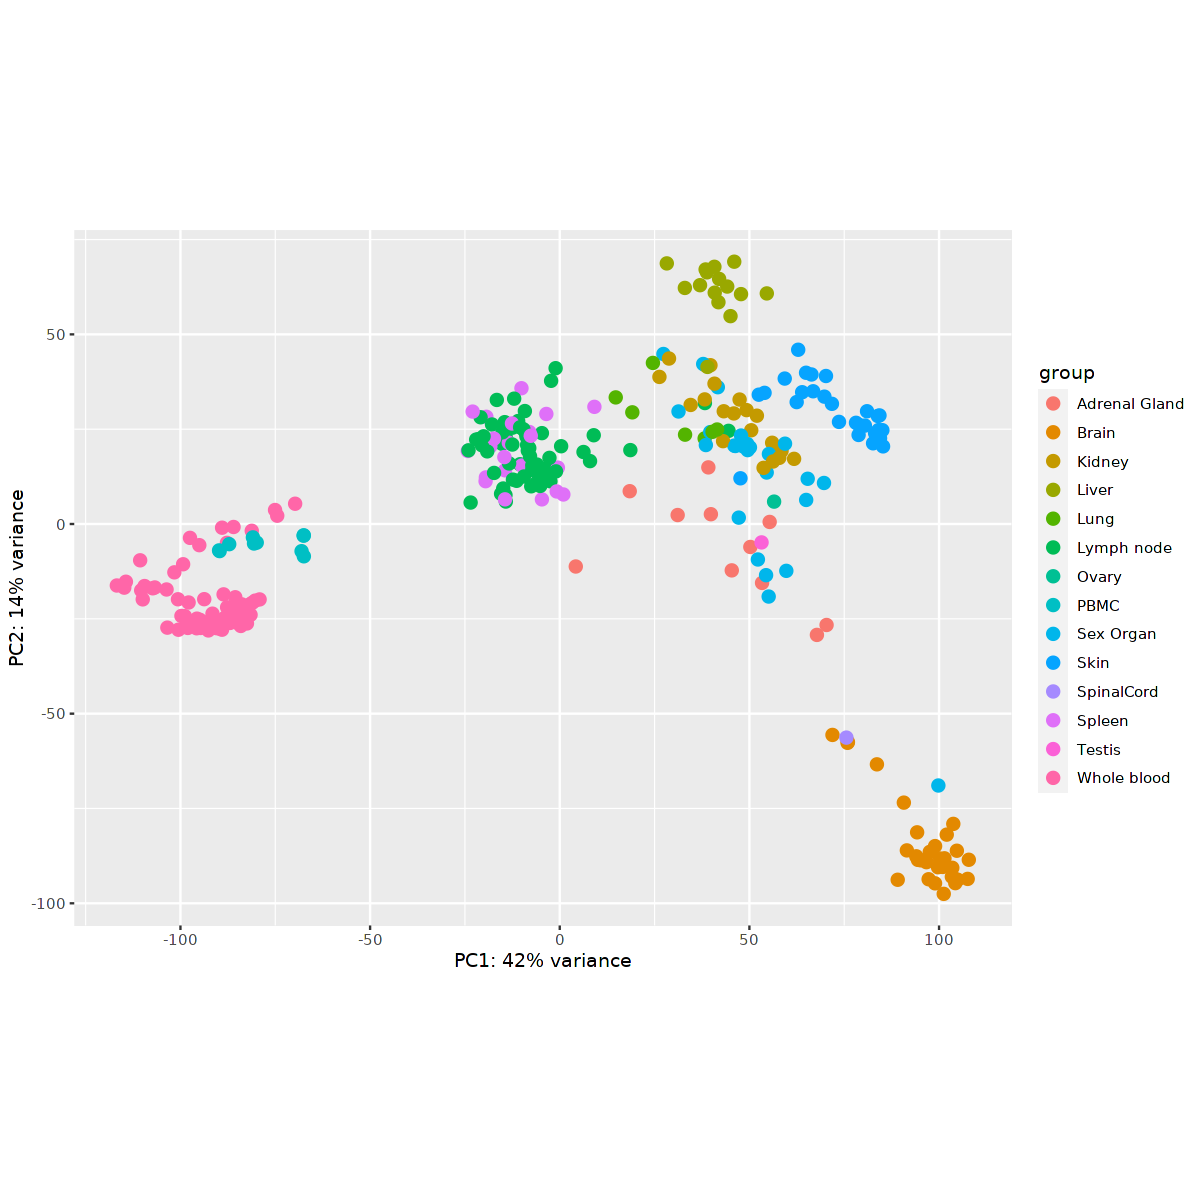

In [24]:
customPlotPCA(vsd.qc, 'tissue', ntop=3000)

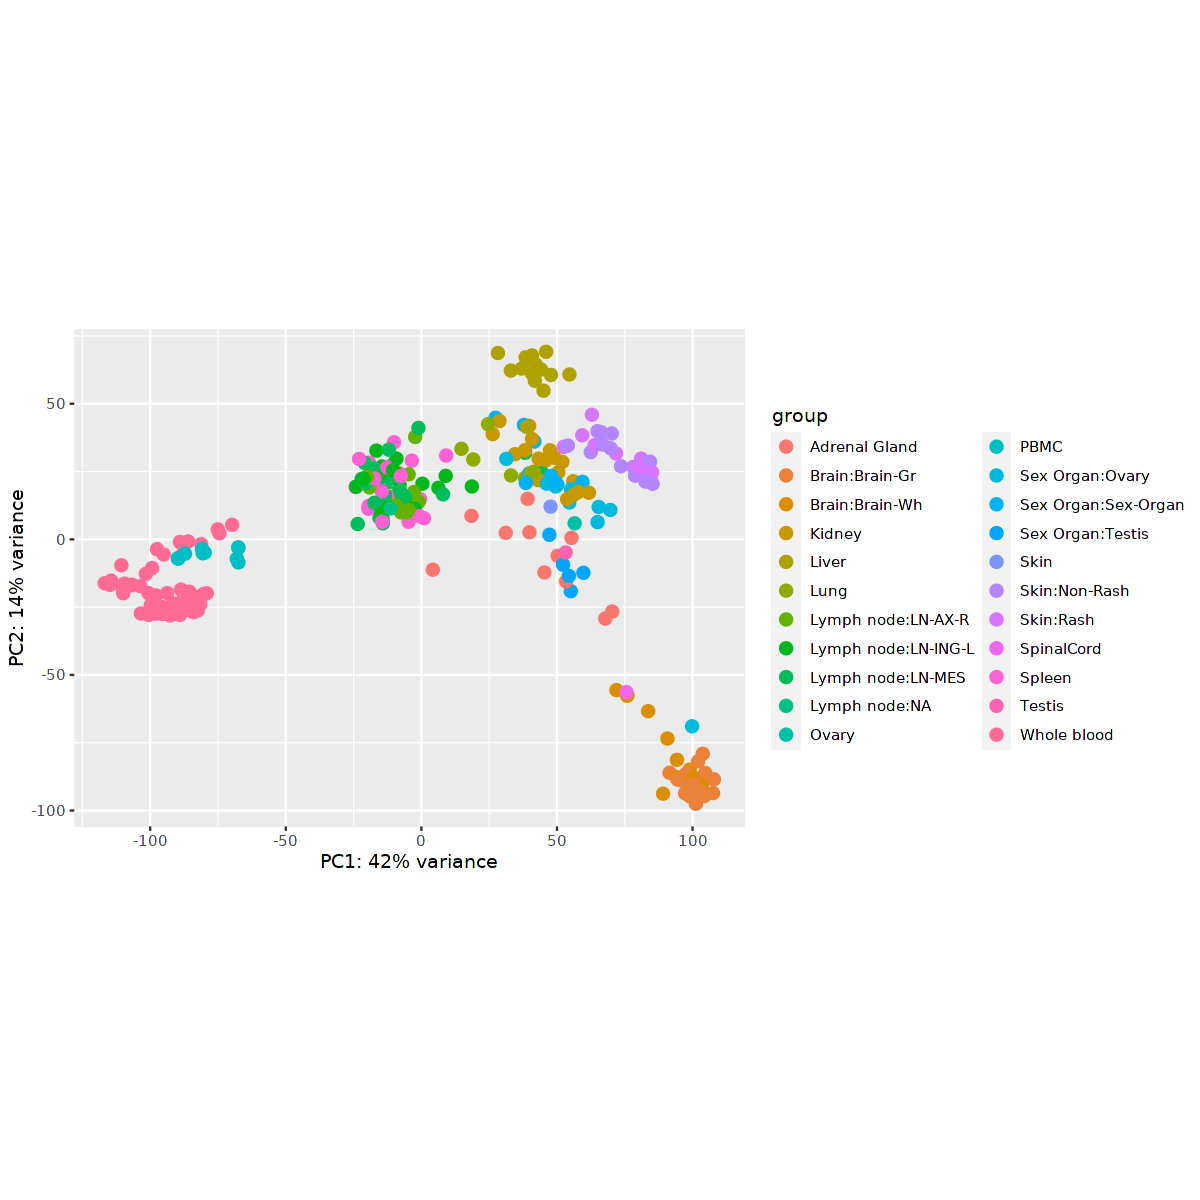

In [25]:
customPlotPCA(vsd.qc, 'full.tissue', ntop=3000)

In [26]:
## Do PCA manually and inspect more components

In [27]:
object <- vsd.qc
ntop <- 3000

rv <- rowVars(assay(object))
select <- order(rv, decreasing = TRUE)[seq_len(min(ntop,length(rv)))]


In [28]:
pca <- prcomp(t(assay(object)[select,]))

In [29]:
percentVar <- pca$sdev ^ 2 / sum(pca$sdev ^ 2)

In [30]:
intgroup <- 'tissue'

In [31]:
# Available metadata we can plot
colnames(colData(object))

[1] "file_identifiers"              "A.identifier"                 
 [3] "biosample"                     "batch.extraction"             
 [5] "irf.study.id"                  "id.cohort"                    
 [7] "id.individual"                 "tissue"                       
 [9] "data.received"                 "dn.rna"                       
[11] "date.broad.extract"            "quant.18s"                    
[13] "quant.18s.sd"                  "quant.kulesh"                 
[15] "quant.kulesh.sd"               "rin.e"                        
[17] "rna.conc.ng.uL"                "lib.conc.pmolar"              
[19] "xgen.index"                    "Assigned"                     
[21] "Unassigned_Unmapped"           "Unassigned_Read_Type"         
[23] "Unassigned_Singleton"          "Unassigned_MappingQuality"    
[25] "Unassigned_Chimera"            "Unassigned_FragmentLength"    
[27] "Unassigned_Duplicate"          "Unassigned_MultiMapping"      
[29] "Unassigned_Secondary"          "Unassigned_NonSplit"          
[31] "Unassigned_NoFeatures"         "Unassigned_Overlapping_Length"
[33] "Unassigned_Ambiguity"          "sub.tissue"                   
[35] "SampleType"                    "study.group"                  
[37] "challenge.group"               "animal.number"                
[39] "animal.tatoo"                  "sex"                          
[41] "weight"                        "birth.date"                   
[43] "viralReadCount"                "hostReadCount"                
[45] "pc.viral.reads"                "cohort.uncertain"             
[47] "cohort.numeric"                "totalReadCount"               
[49] "totalUnassigned"               "chrY_count"                   
[51] "chrX_count"                    "total_count"                  
[53] "Xist"                          "sex.1"                        
[55] "pc_Y"                          "pc_X"                         
[57] "Y_X_ratio"                     "sex_pred"                     
[59] "pred_recorded_sex_mismatch"    "dpi_time"                     
[61] "dpi_time_factor"               "xist_counts"                  
[63] "predicted_sex"                 "pred_rec_sex_mismatch"        
[65] "full.tissue"                   "sample_id_dedup"              
[67] "duplicate_sequencing"          "sizeFactor"                   
[69] "replaceable"

In [32]:
intgroup.df <- as.data.frame(colData(object)[, c('tissue','dpi_time_factor','sex'), drop = FALSE])

In [33]:
group <- colData(object)[['tissue']]

In [34]:
    d <-
      data.frame(
        PC1 = pca$x[, 1],
        PC2 = pca$x[, 2],
        PC3 = pca$x[, 3],
        PC4 = pca$x[, 4],
        PC5 = pca$x[, 5],
        PC6 = pca$x[, 6],
        PC7 = pca$x[, 7],
        PC8 = pca$x[, 8],
        PC9 = pca$x[, 9],
        PC10 = pca$x[, 10],
        group = group,
        intgroup.df,
        name = colnames(object)
      )

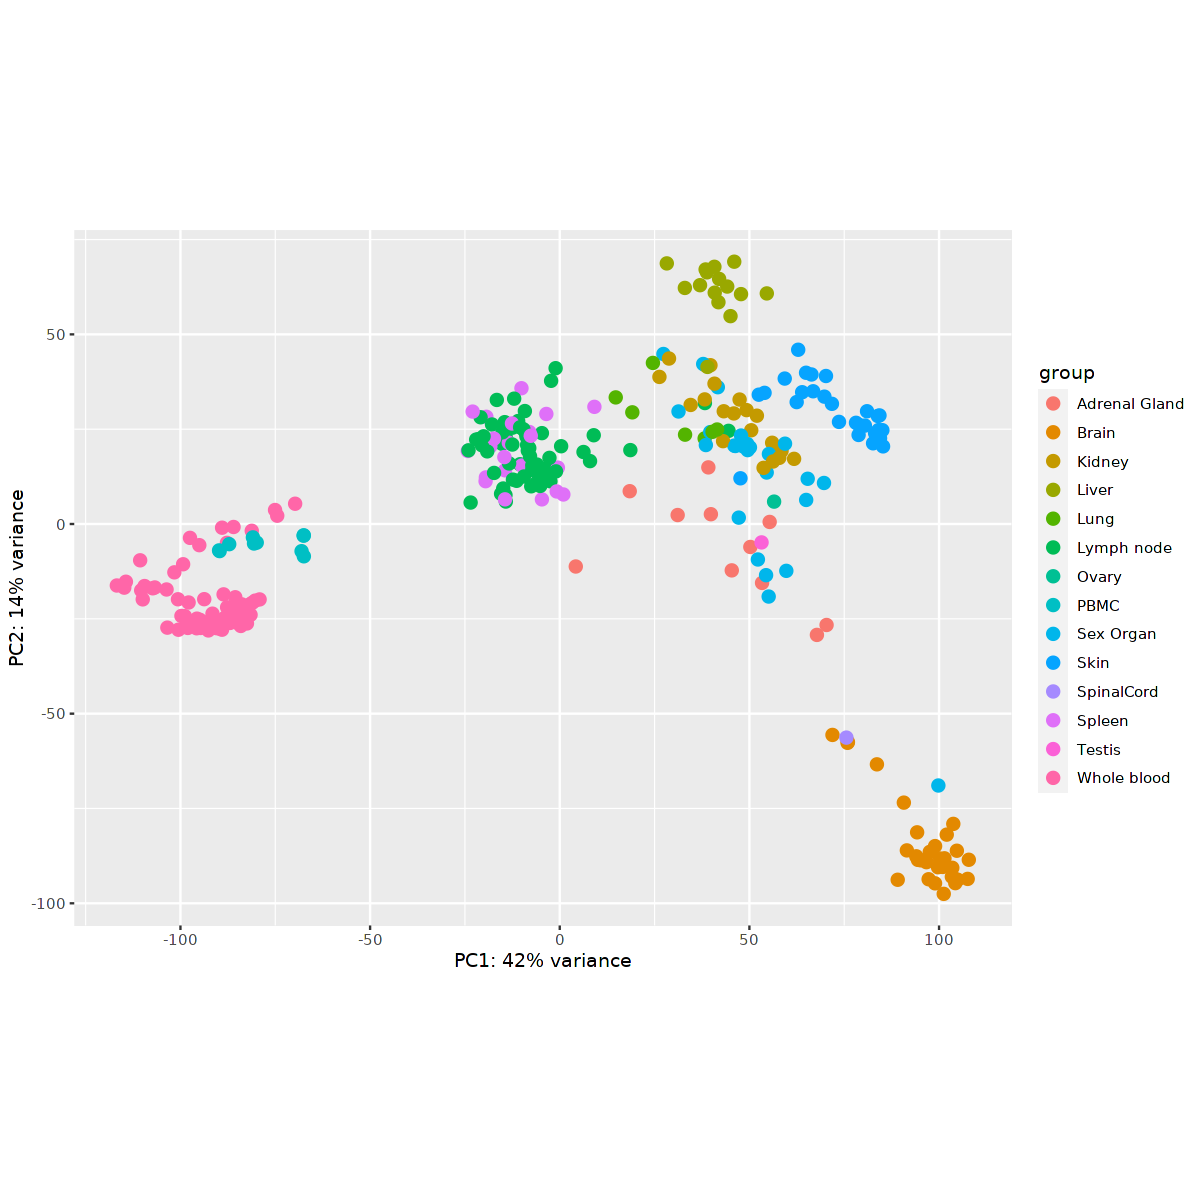

In [35]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC1", y = "PC2", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
      ggplot2::coord_fixed()

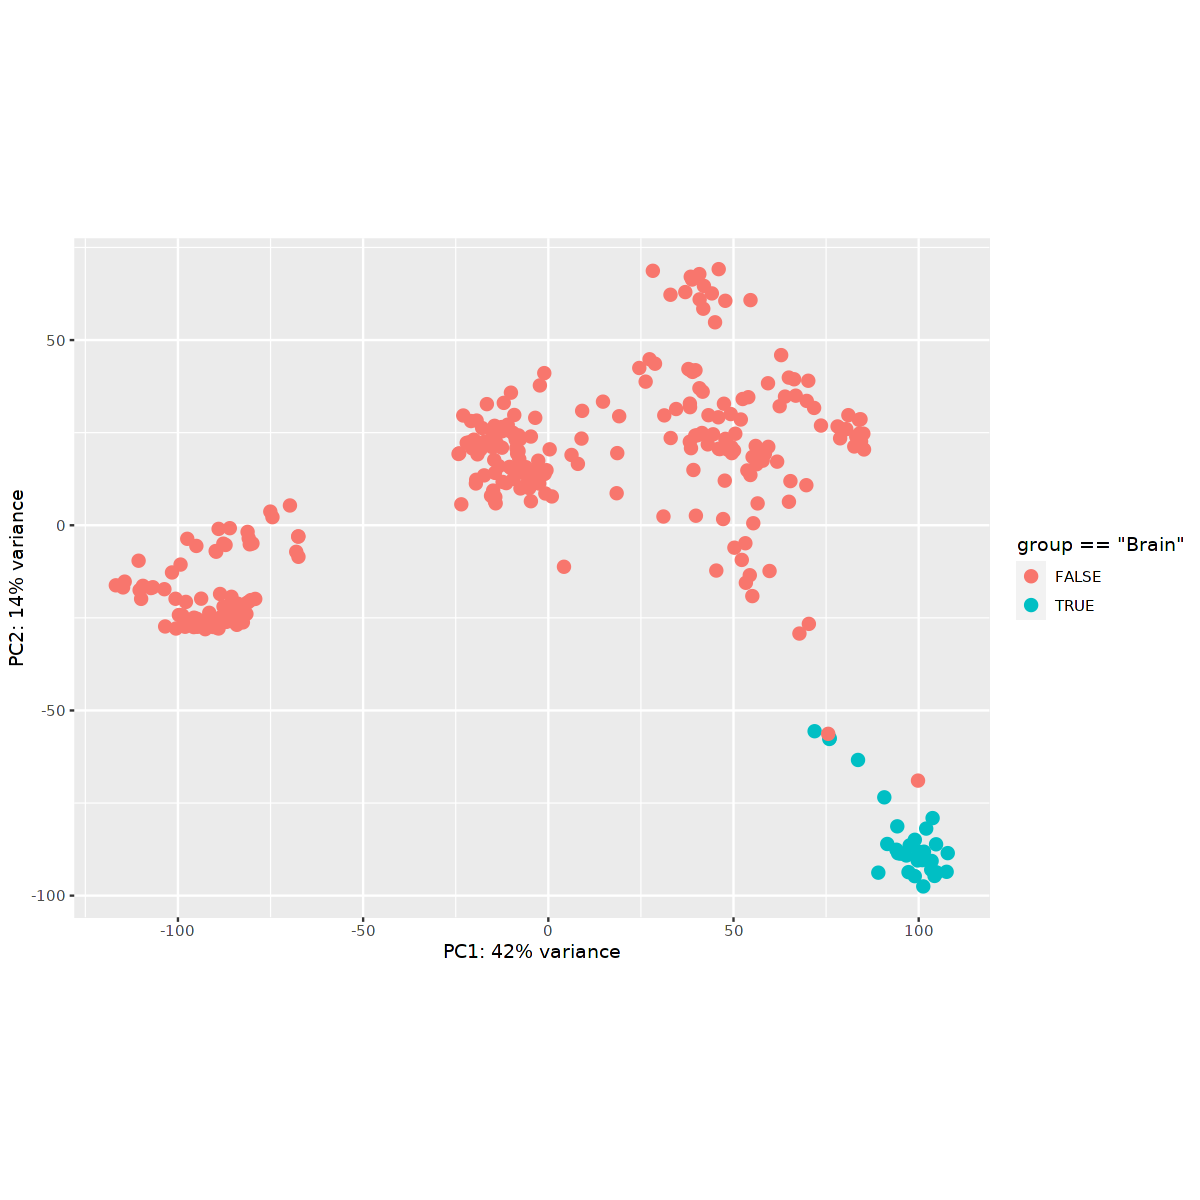

In [36]:
    ggplot2::ggplot(data = d, ggplot2::aes(x = PC1, y = PC2, color = group == 'Brain')) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
      ggplot2::coord_fixed()

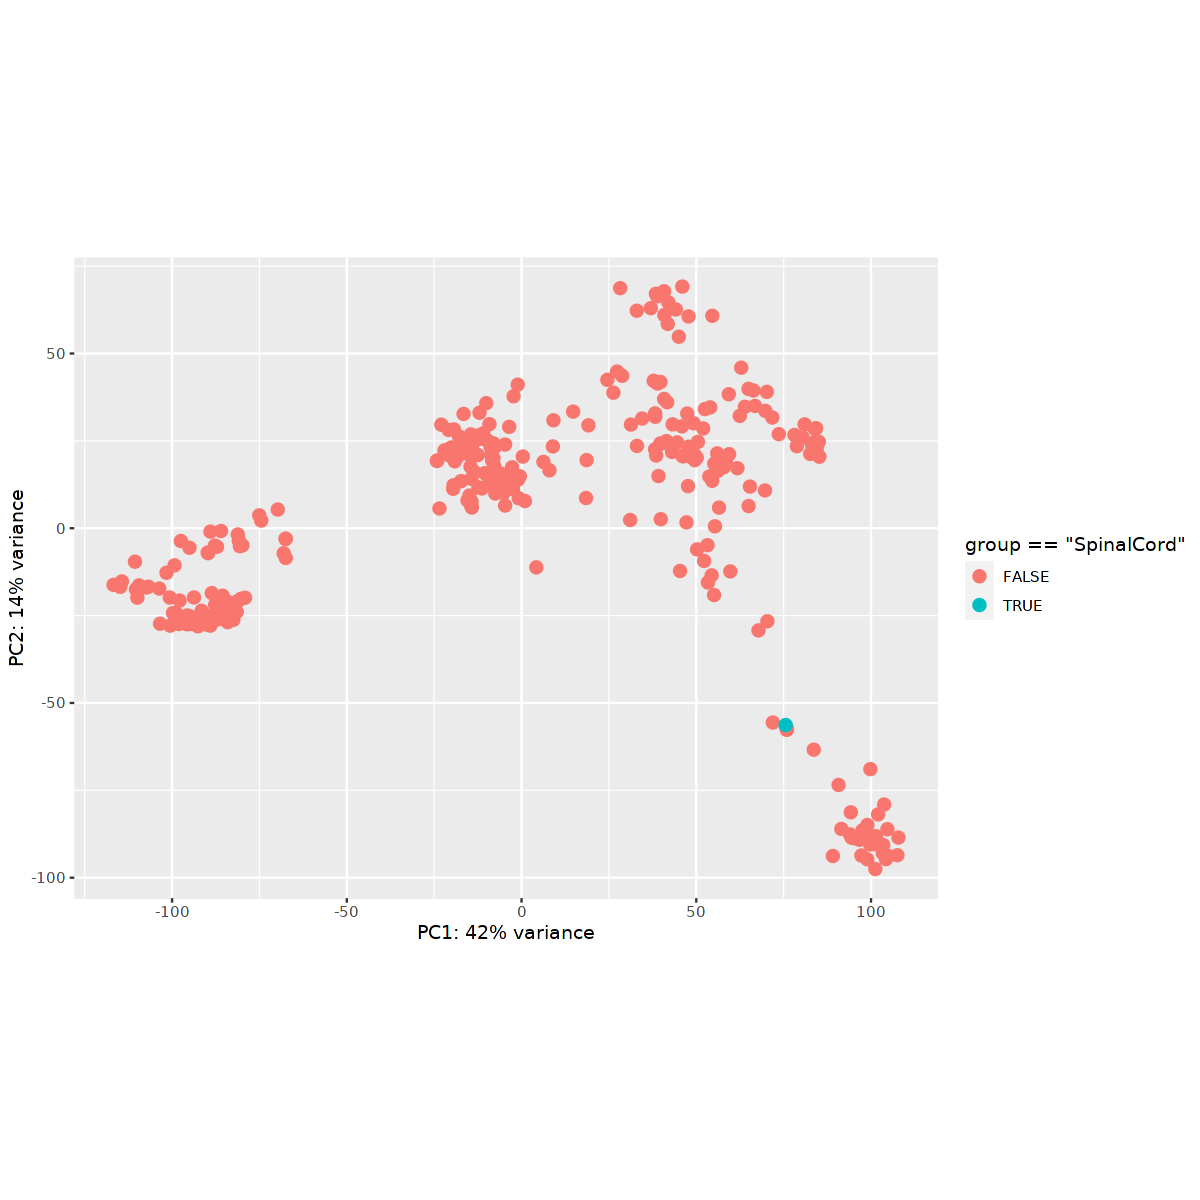

In [37]:
    ggplot2::ggplot(data = d, ggplot2::aes(x = PC1, y = PC2, color = group == 'SpinalCord')) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
      ggplot2::coord_fixed()

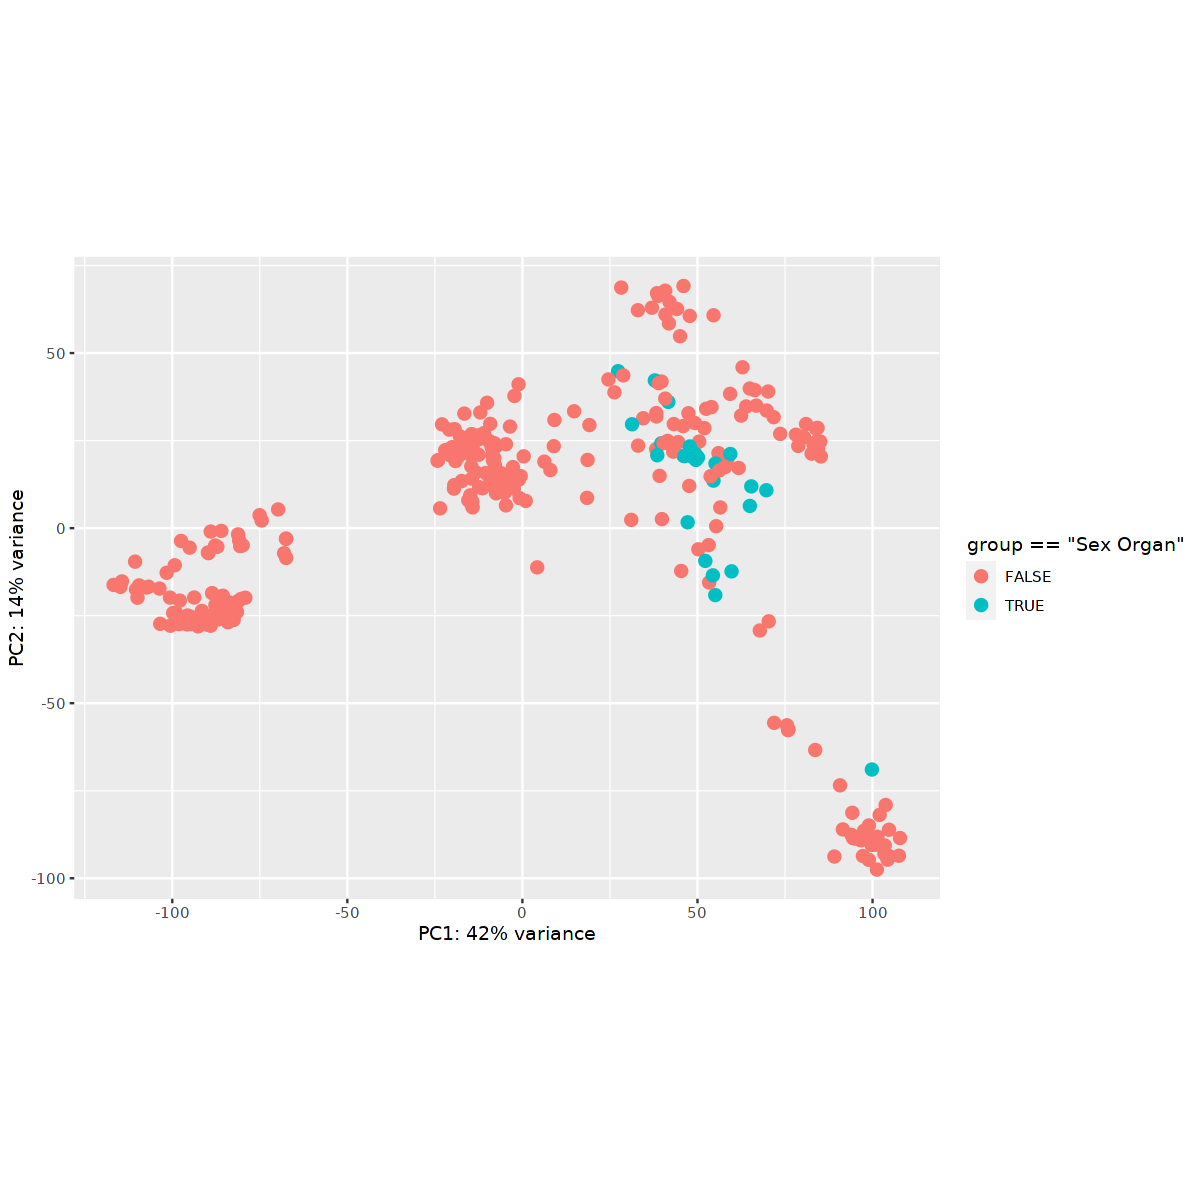

In [38]:
    ggplot2::ggplot(data = d, ggplot2::aes(x = PC1, y = PC2, color = group == 'Sex Organ')) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
      ggplot2::coord_fixed()

Warning message:
“ggrepel: 314 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


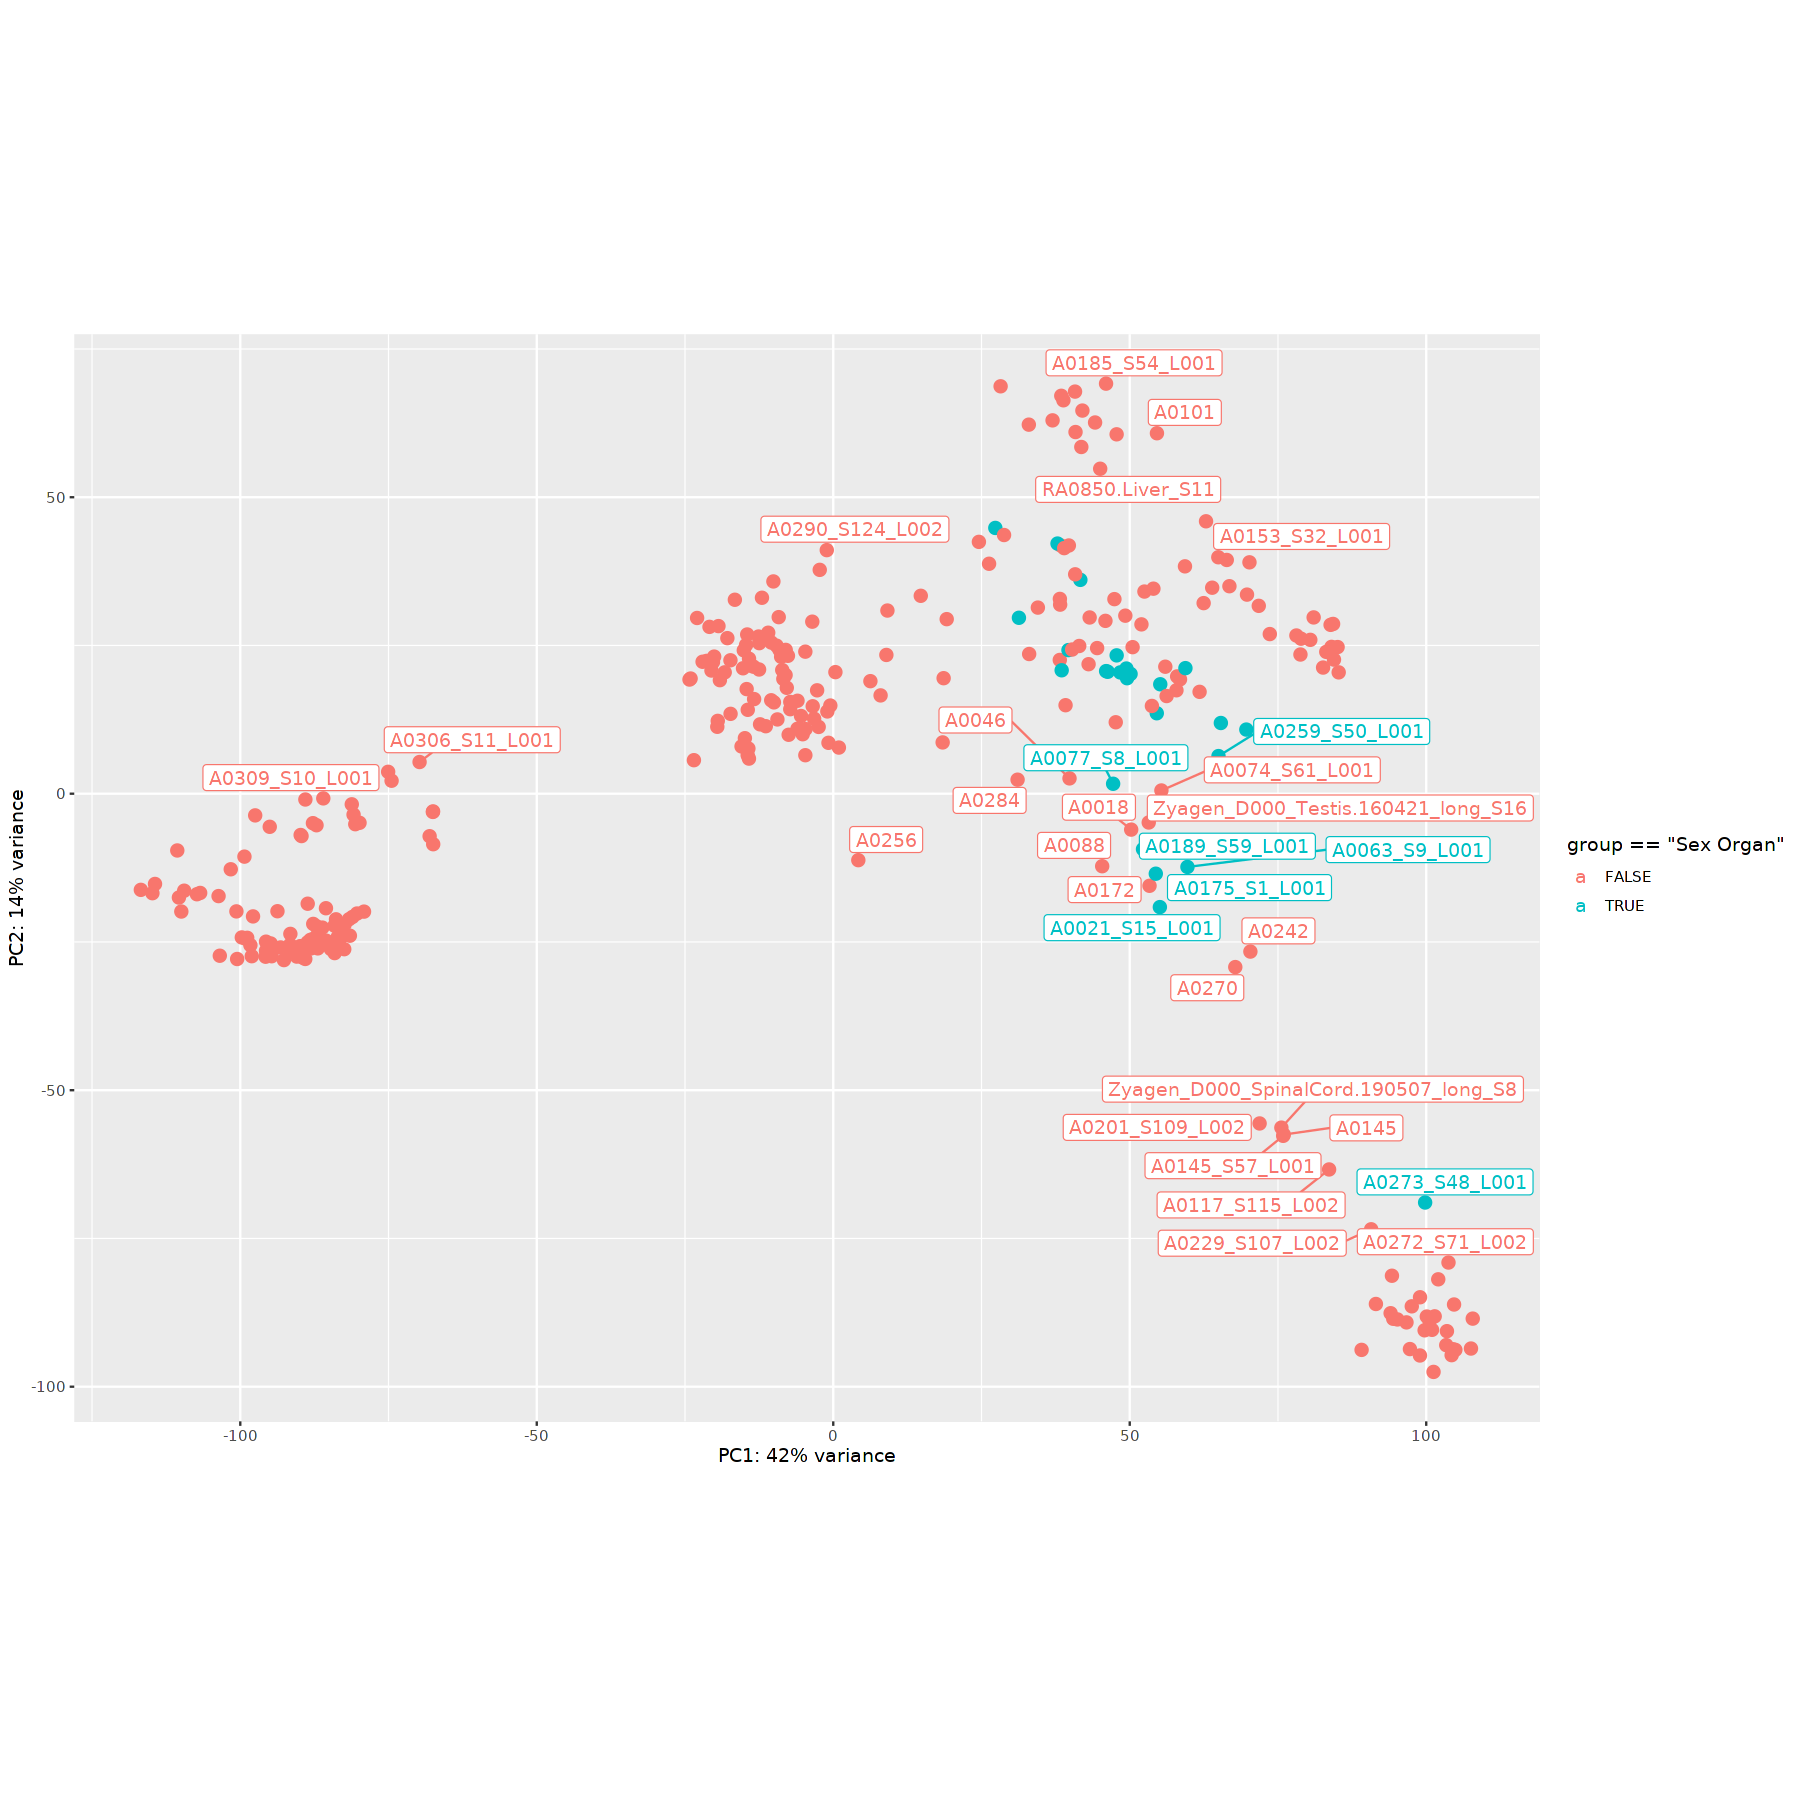

In [39]:
options(repr.plot.width = 15, repr.plot.height = 15)

ggplot2::ggplot(data = d, ggplot2::aes(x = PC1, y = PC2, color = group == 'Sex Organ')) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
      ggplot2::coord_fixed() + ggrepel::geom_label_repel(aes(label=name))

A0273_S48_L001 need to be removed

In [40]:
samples_to_remove <- c("A0273_S48_L001")

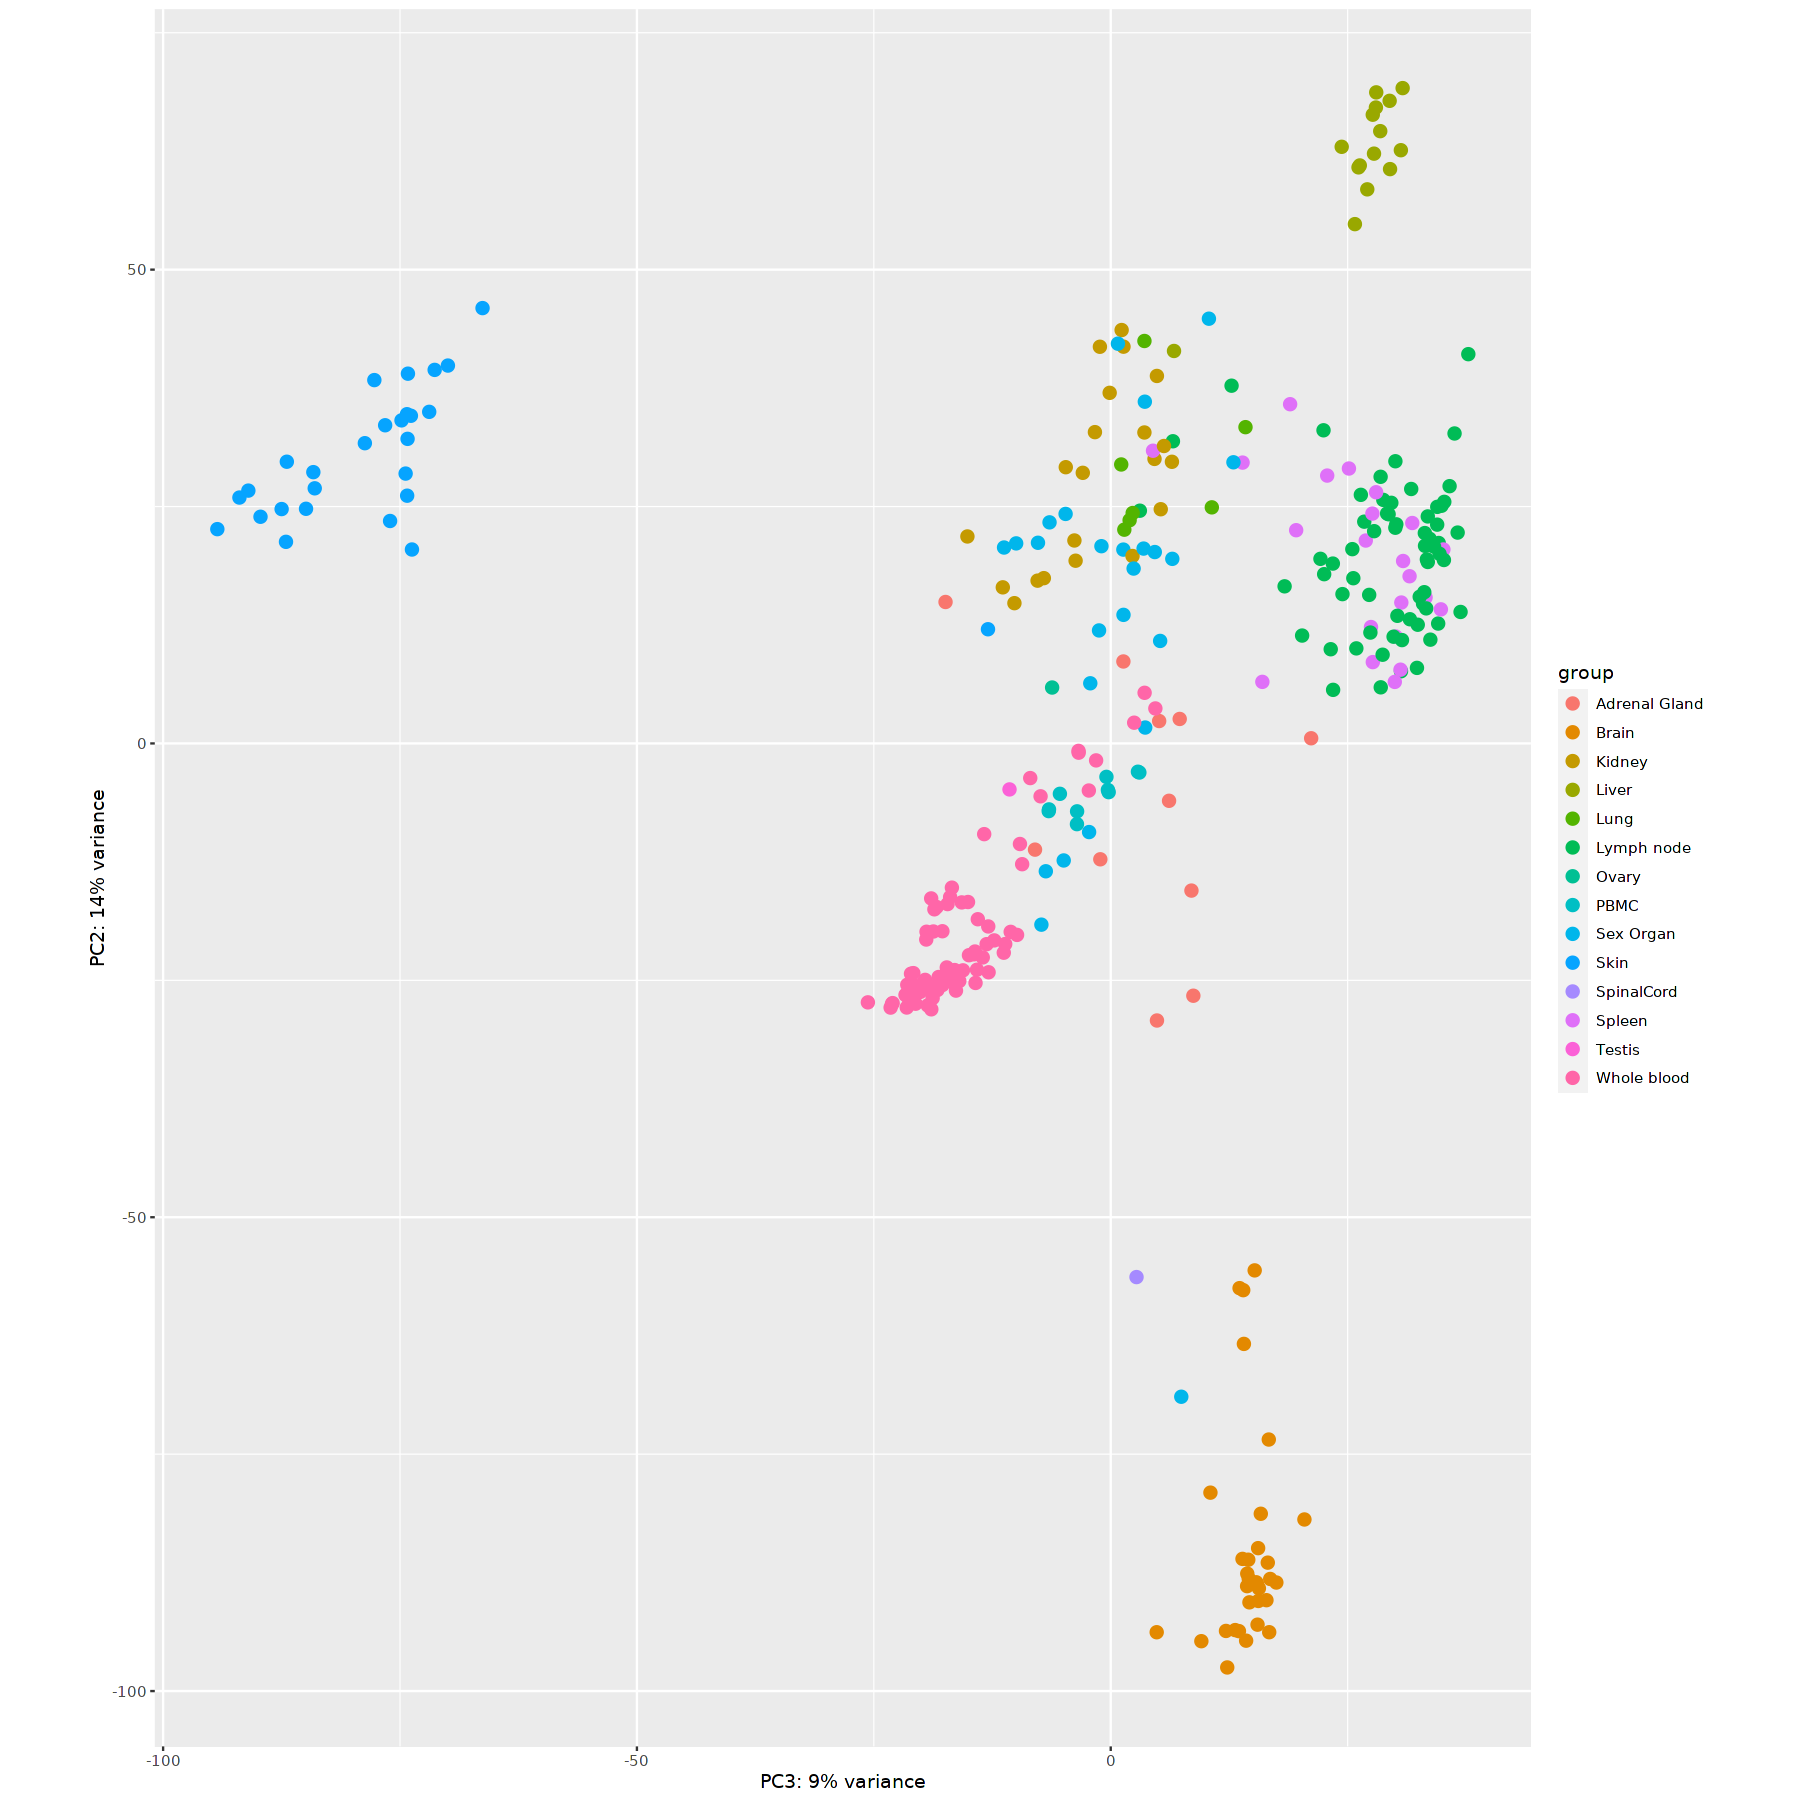

In [41]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC3", y = "PC2", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC3: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
      ggplot2::coord_fixed()

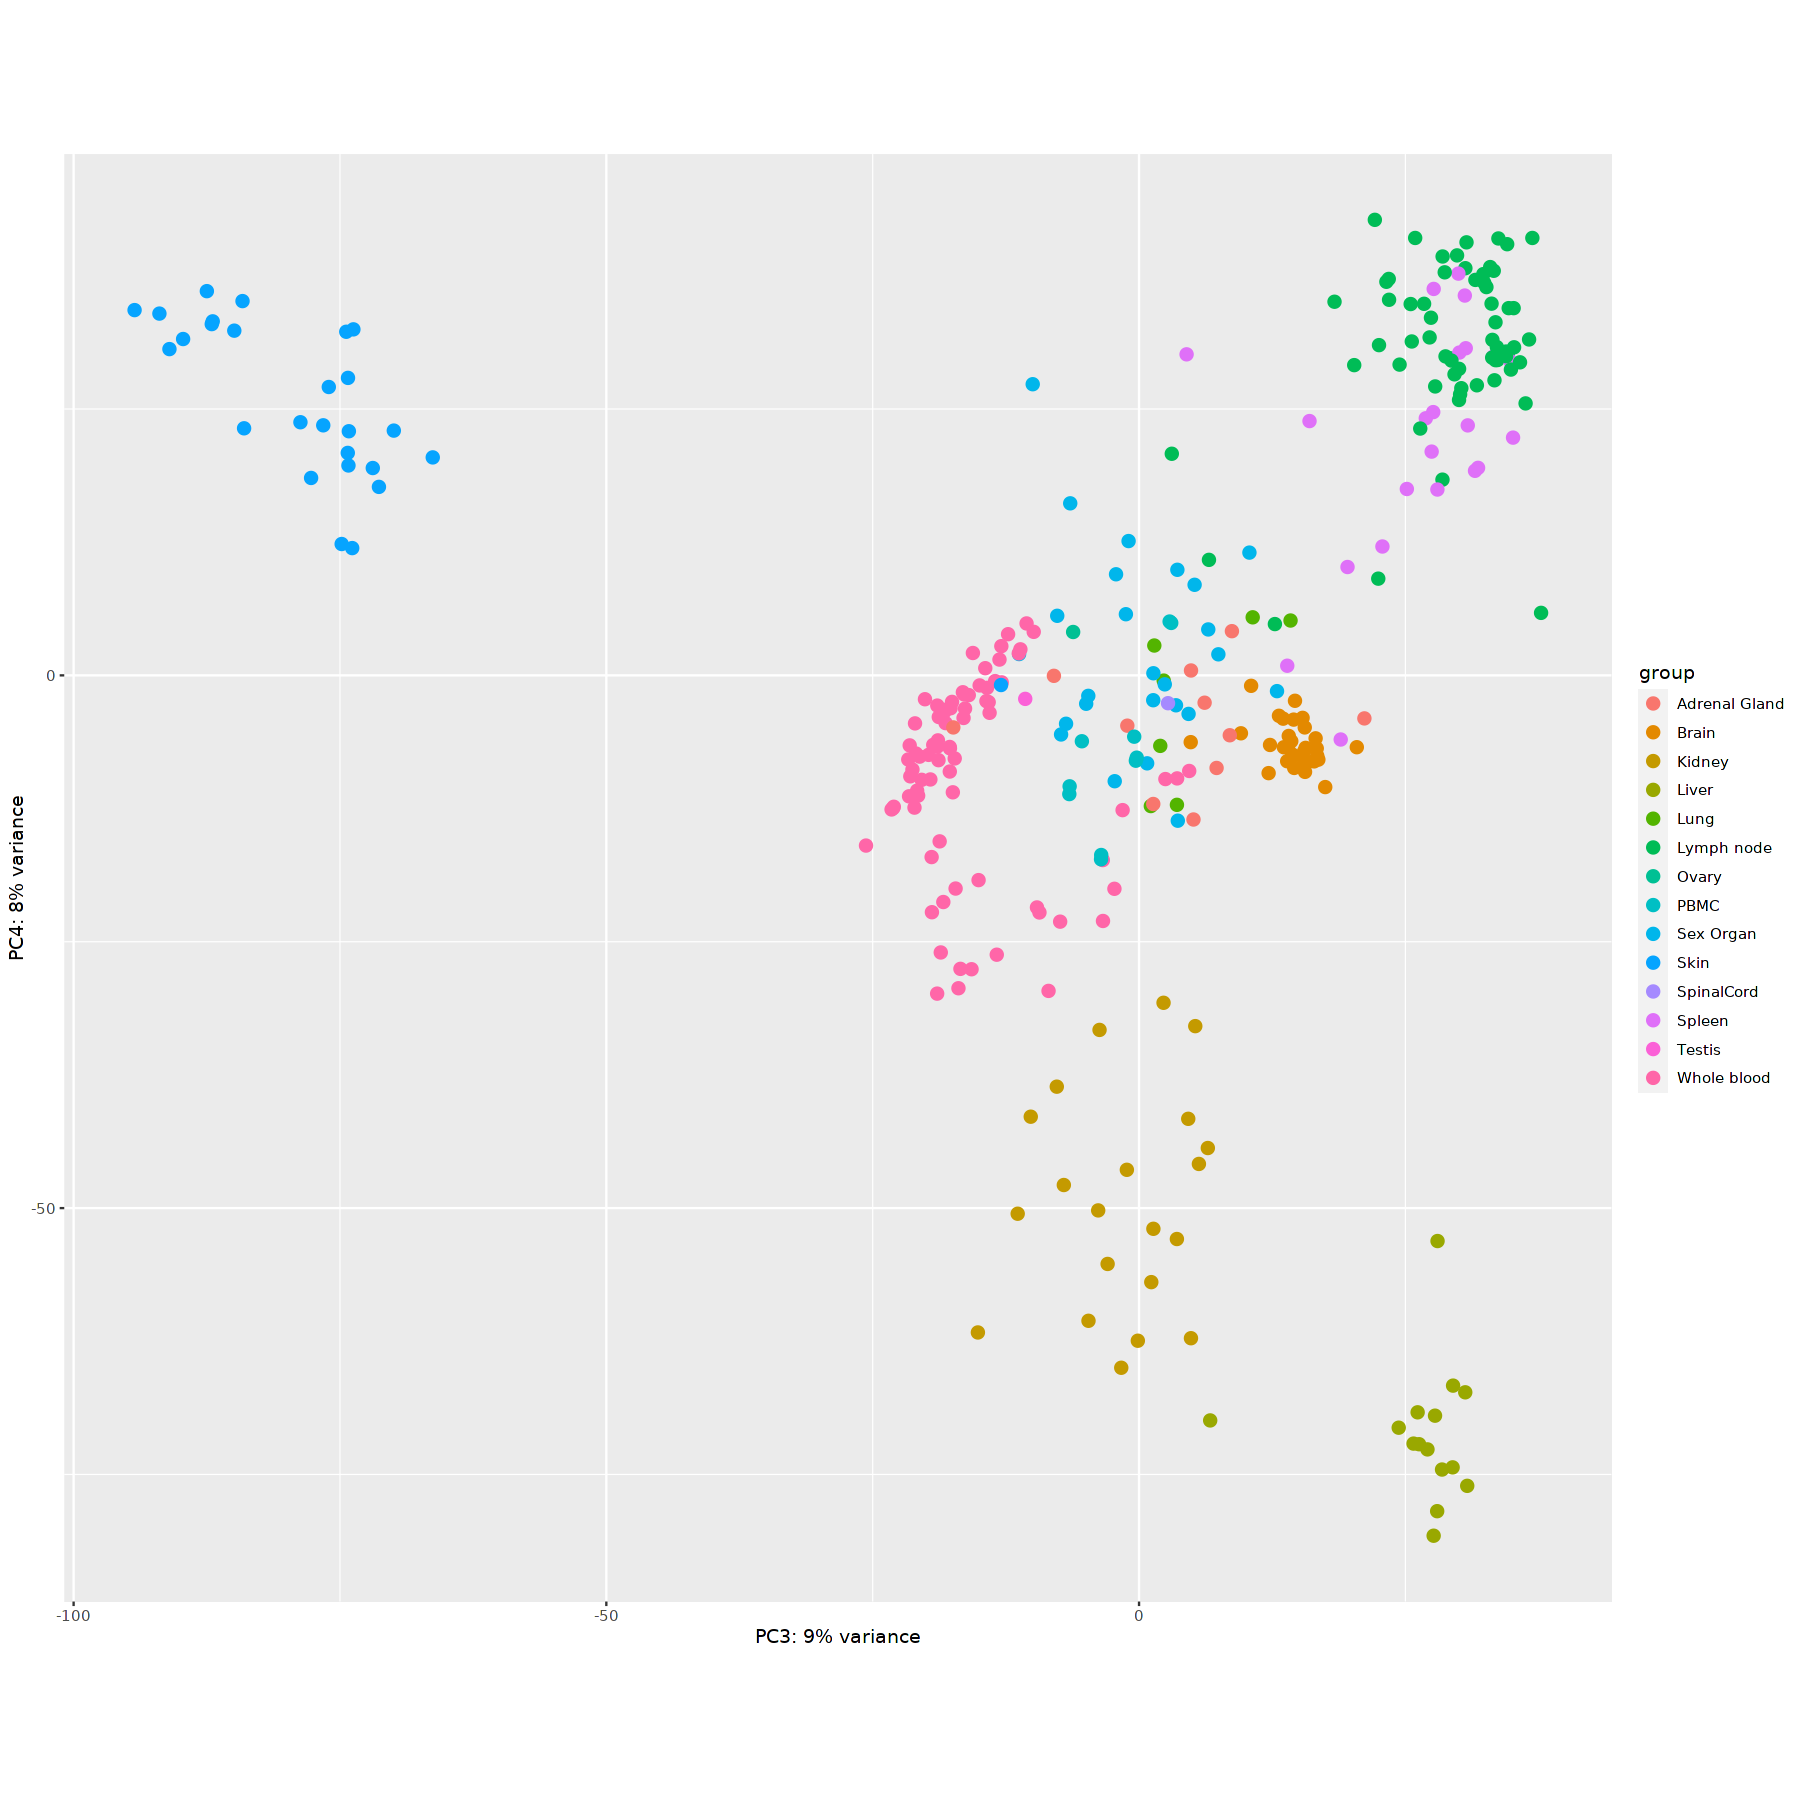

In [42]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC3", y = "PC4", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC3: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC4: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

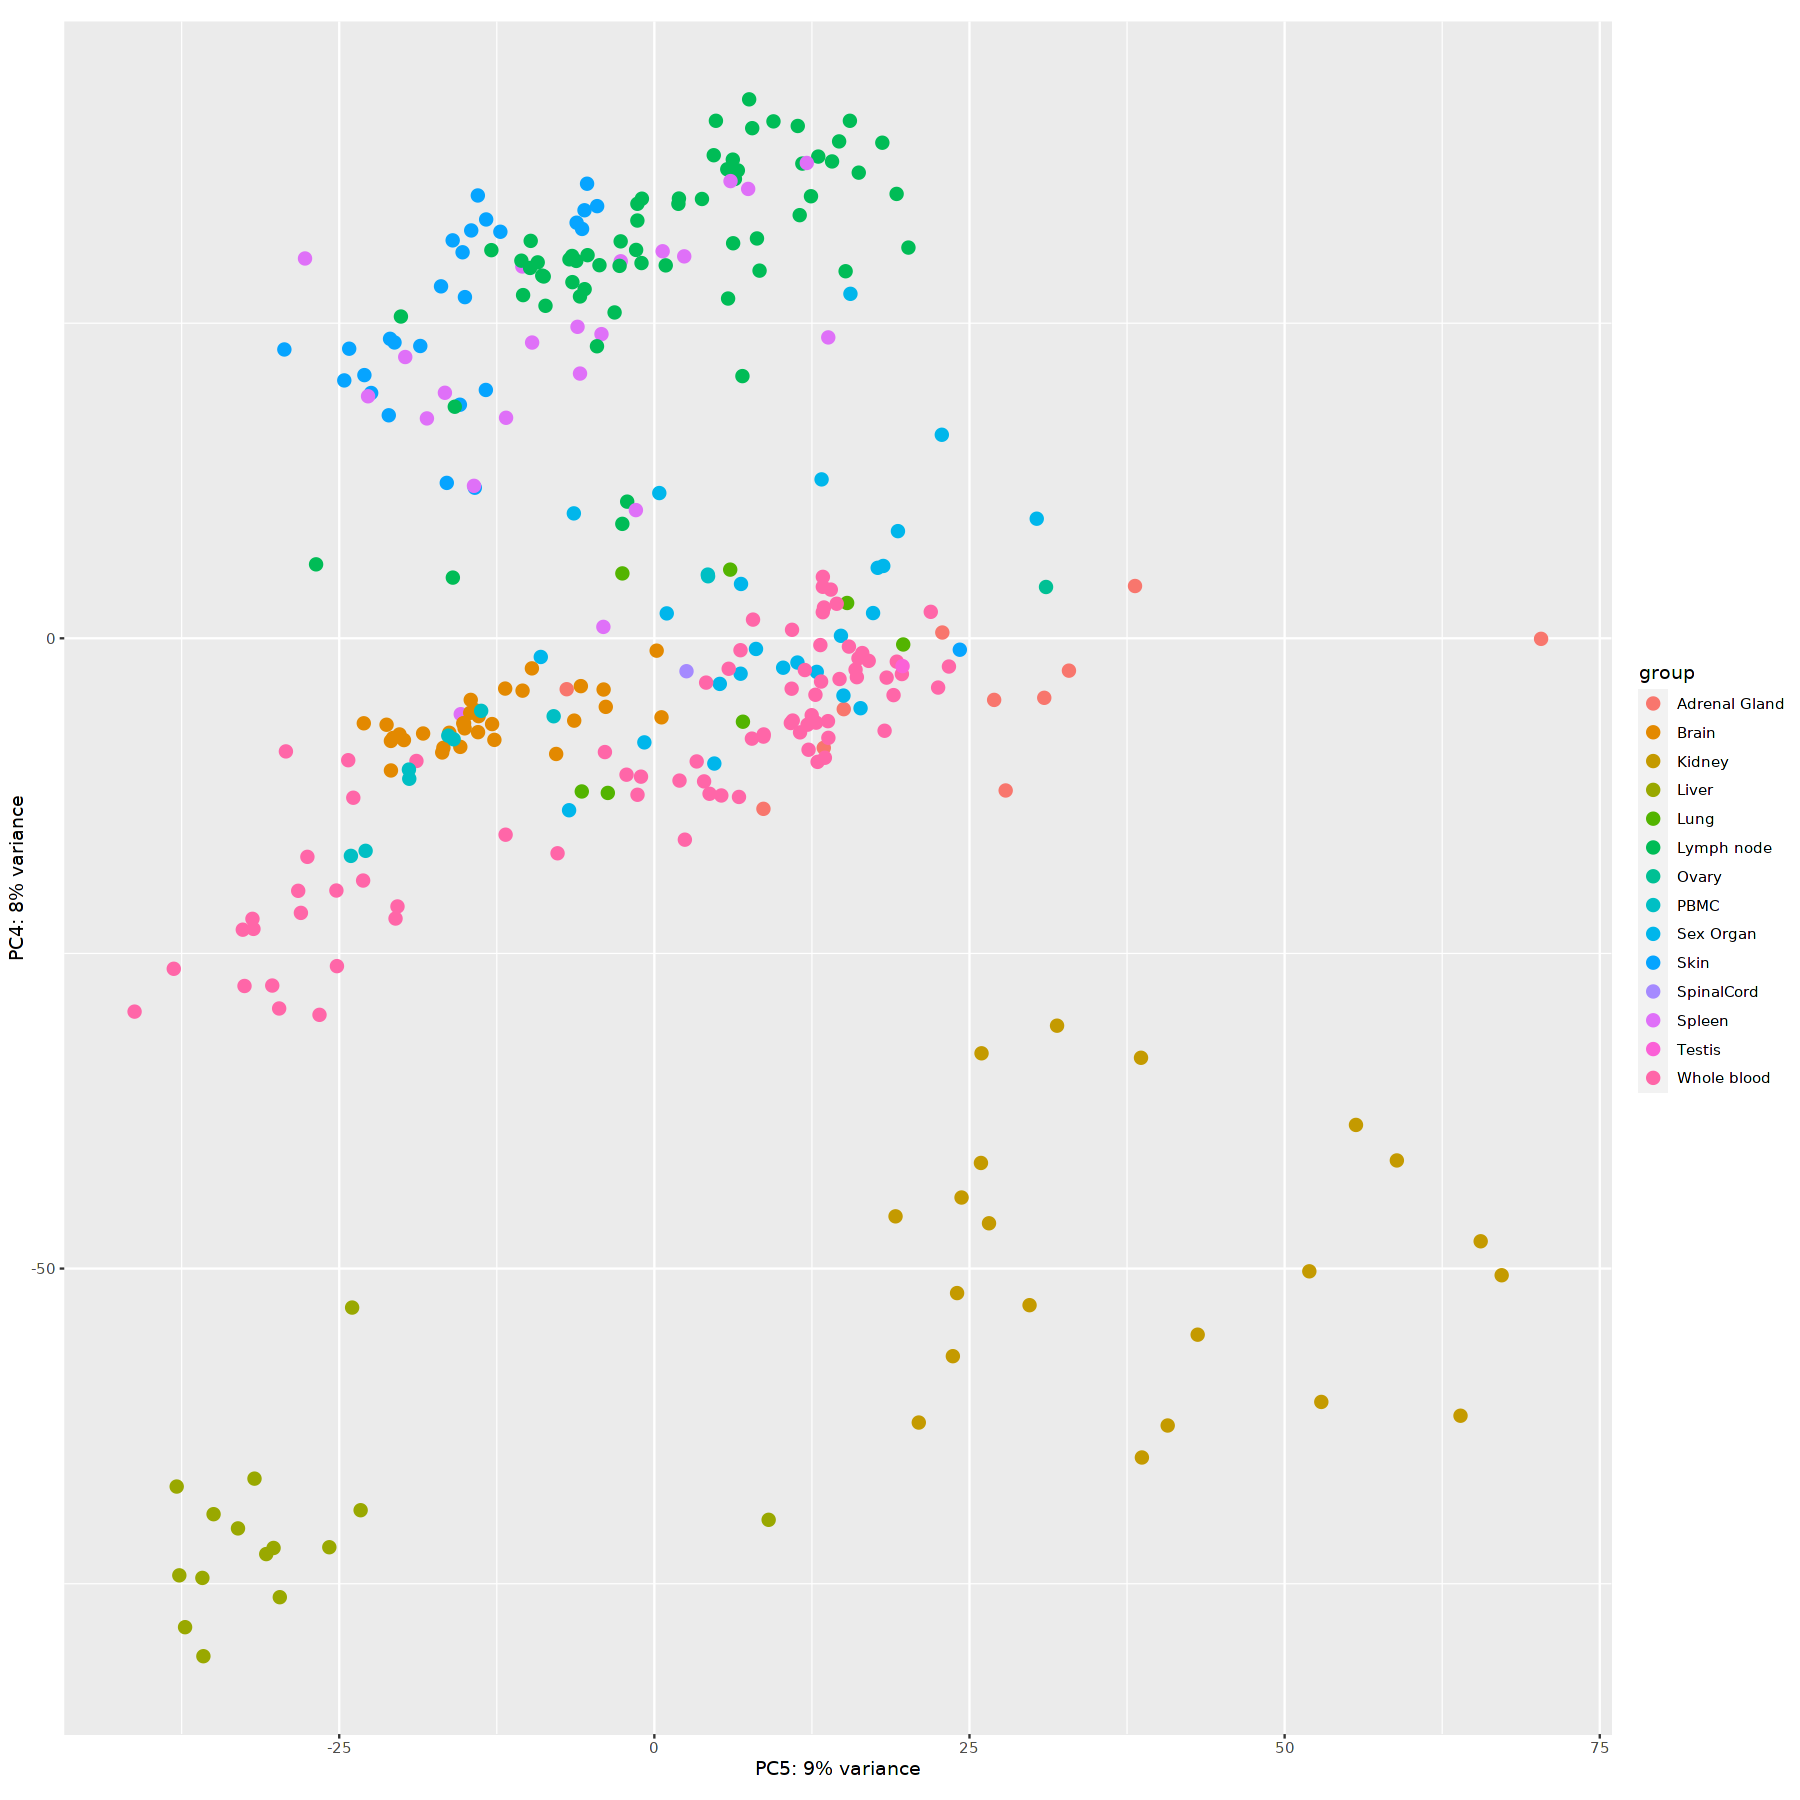

In [43]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC5", y = "PC4", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC5: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC4: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

A0155_S110_L002 needs to be removed

In [44]:
samples_to_remove <- c(samples_to_remove, "A0155_S110_L002")

Warning message:
“ggrepel: 307 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


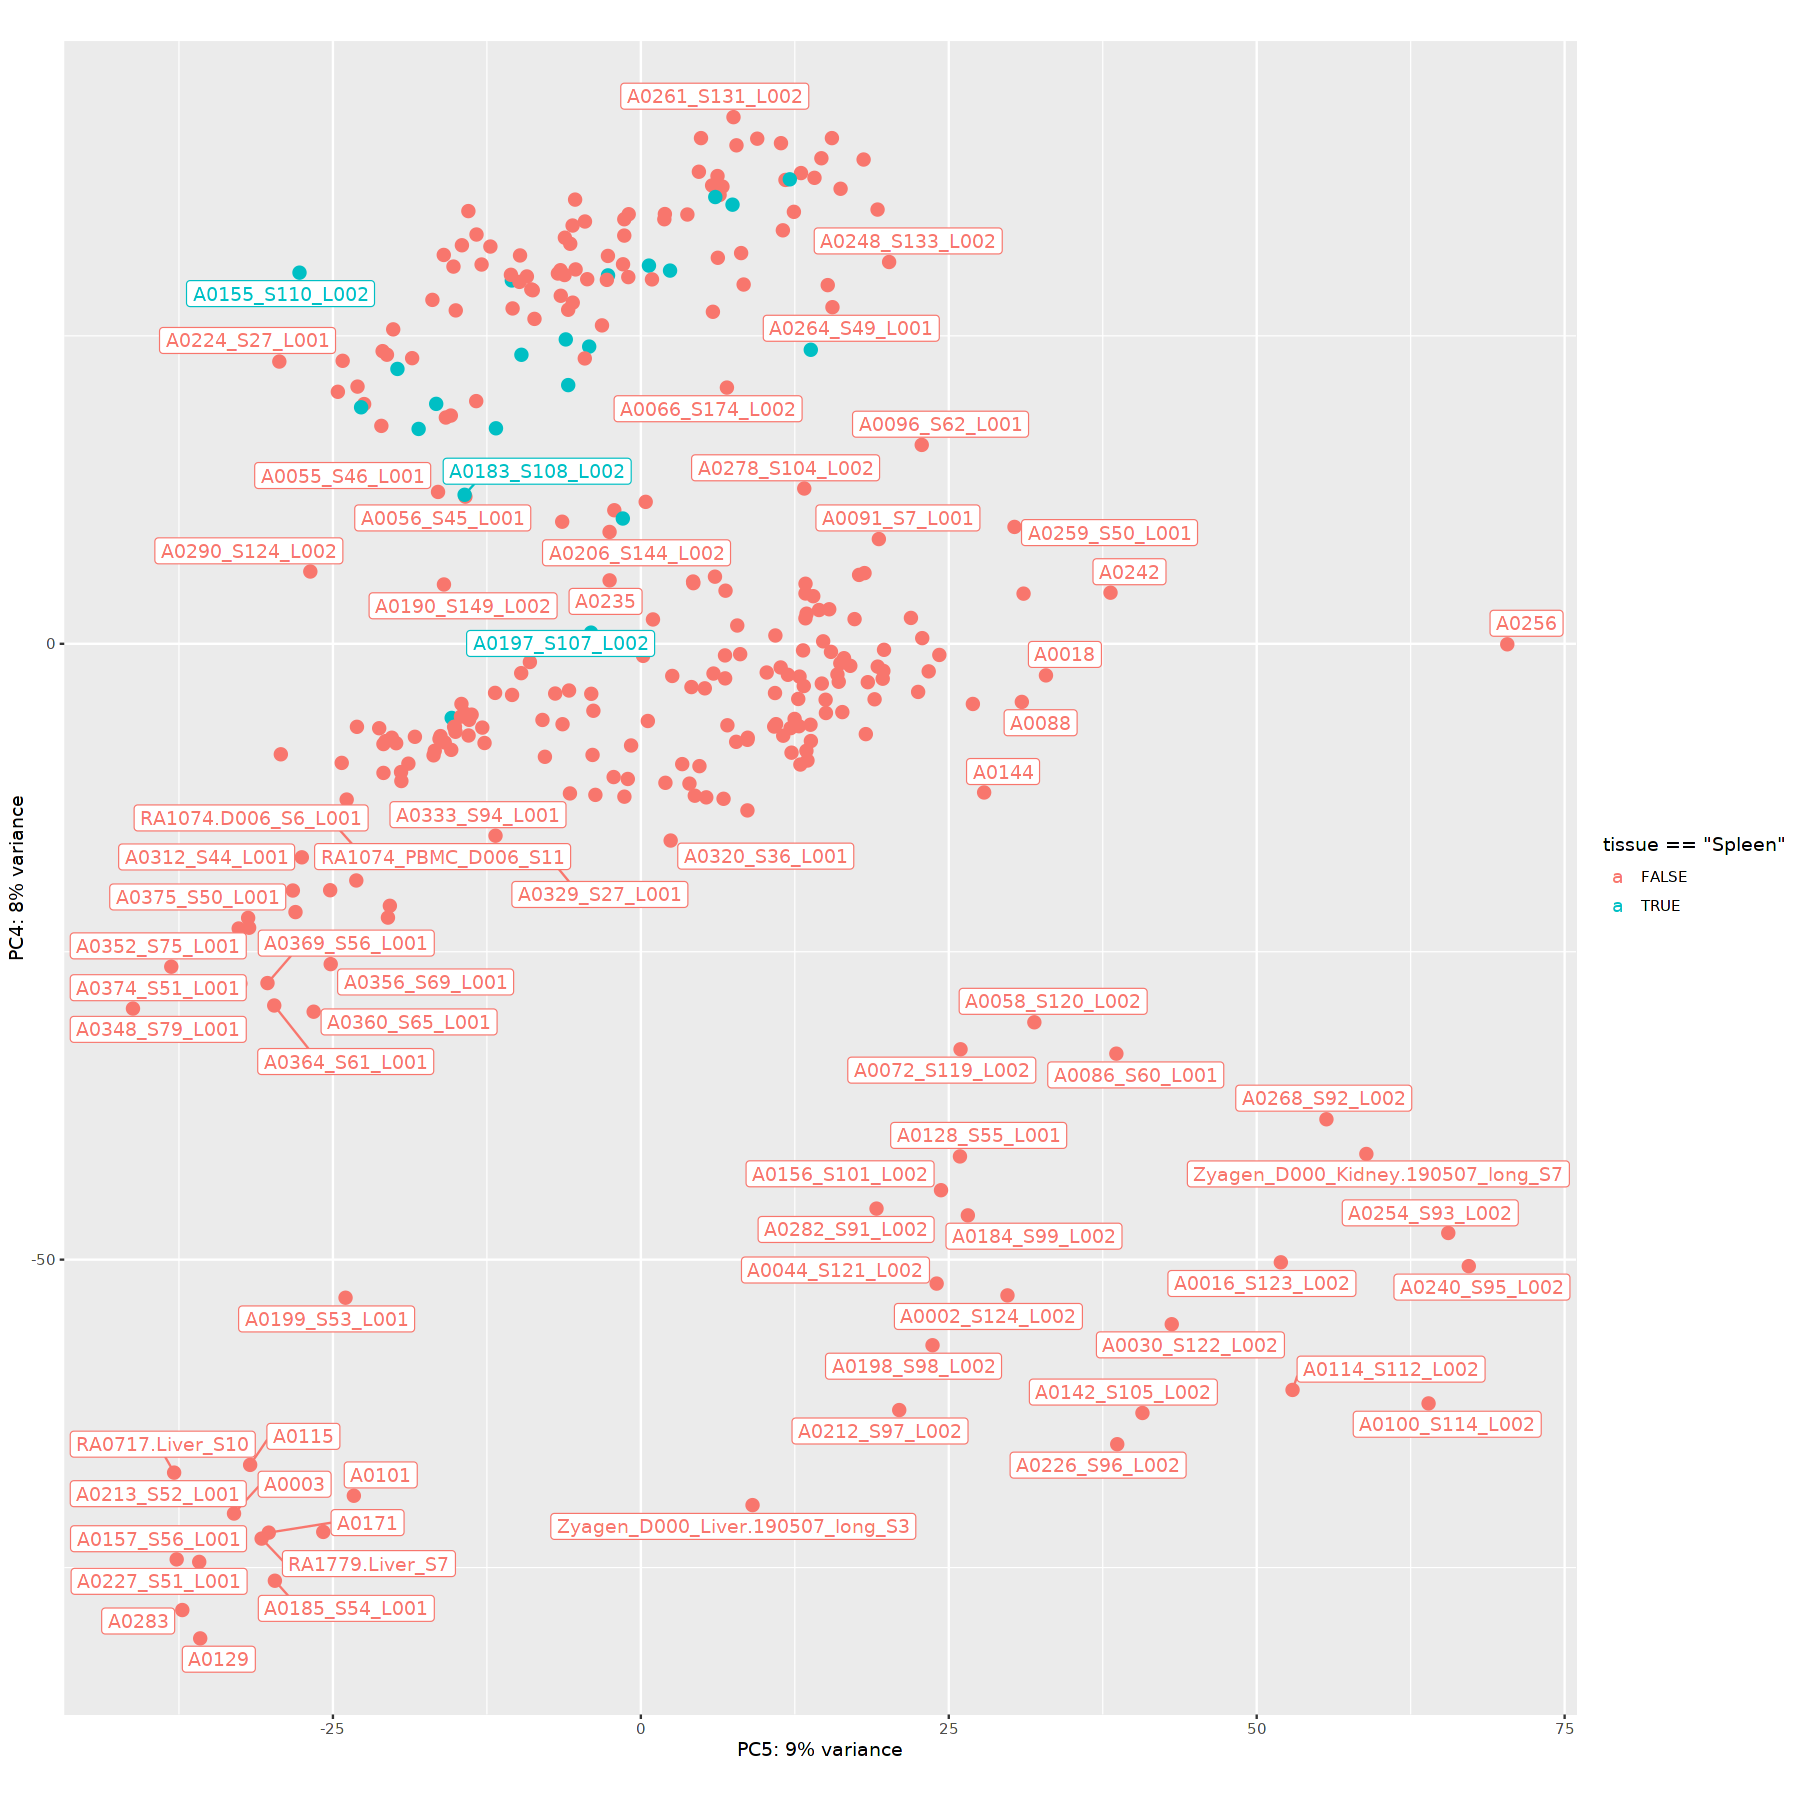

In [45]:
    ggplot2::ggplot(data = d, ggplot2::aes(x = PC5, y = PC4, color = tissue == "Spleen")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC5: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC4: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed() + ggrepel::geom_label_repel(aes(label=name))

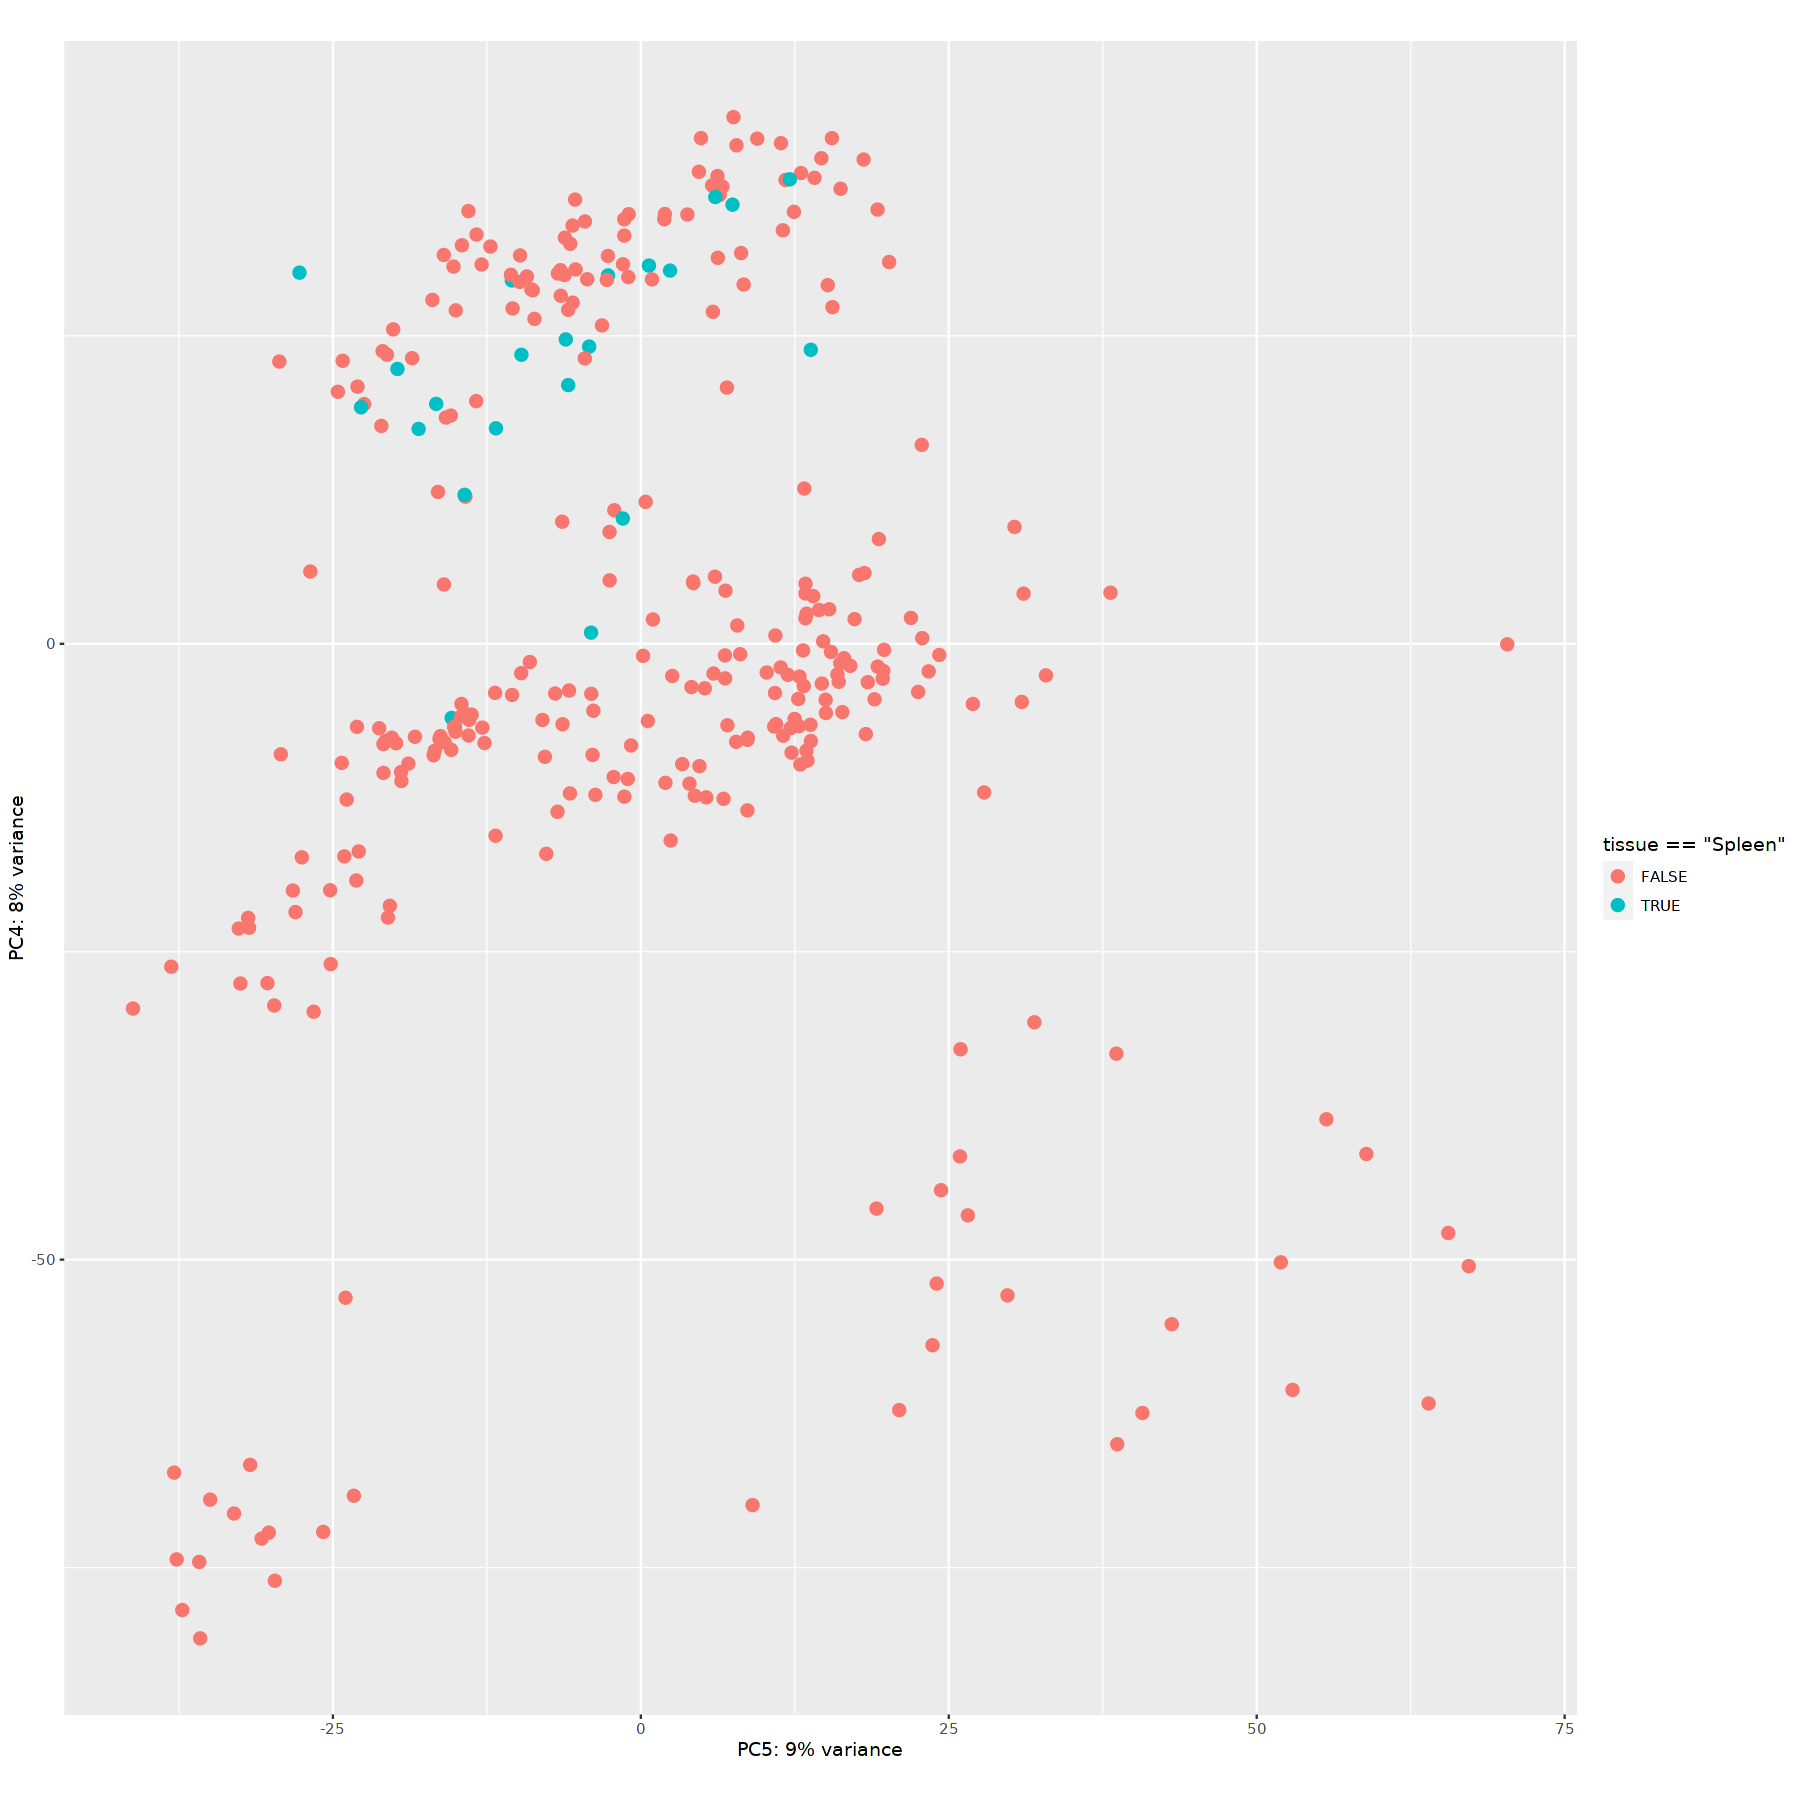

In [46]:
    ggplot2::ggplot(data = d, ggplot2::aes(x = PC5, y = PC4, color = tissue == "Spleen")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC5: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC4: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

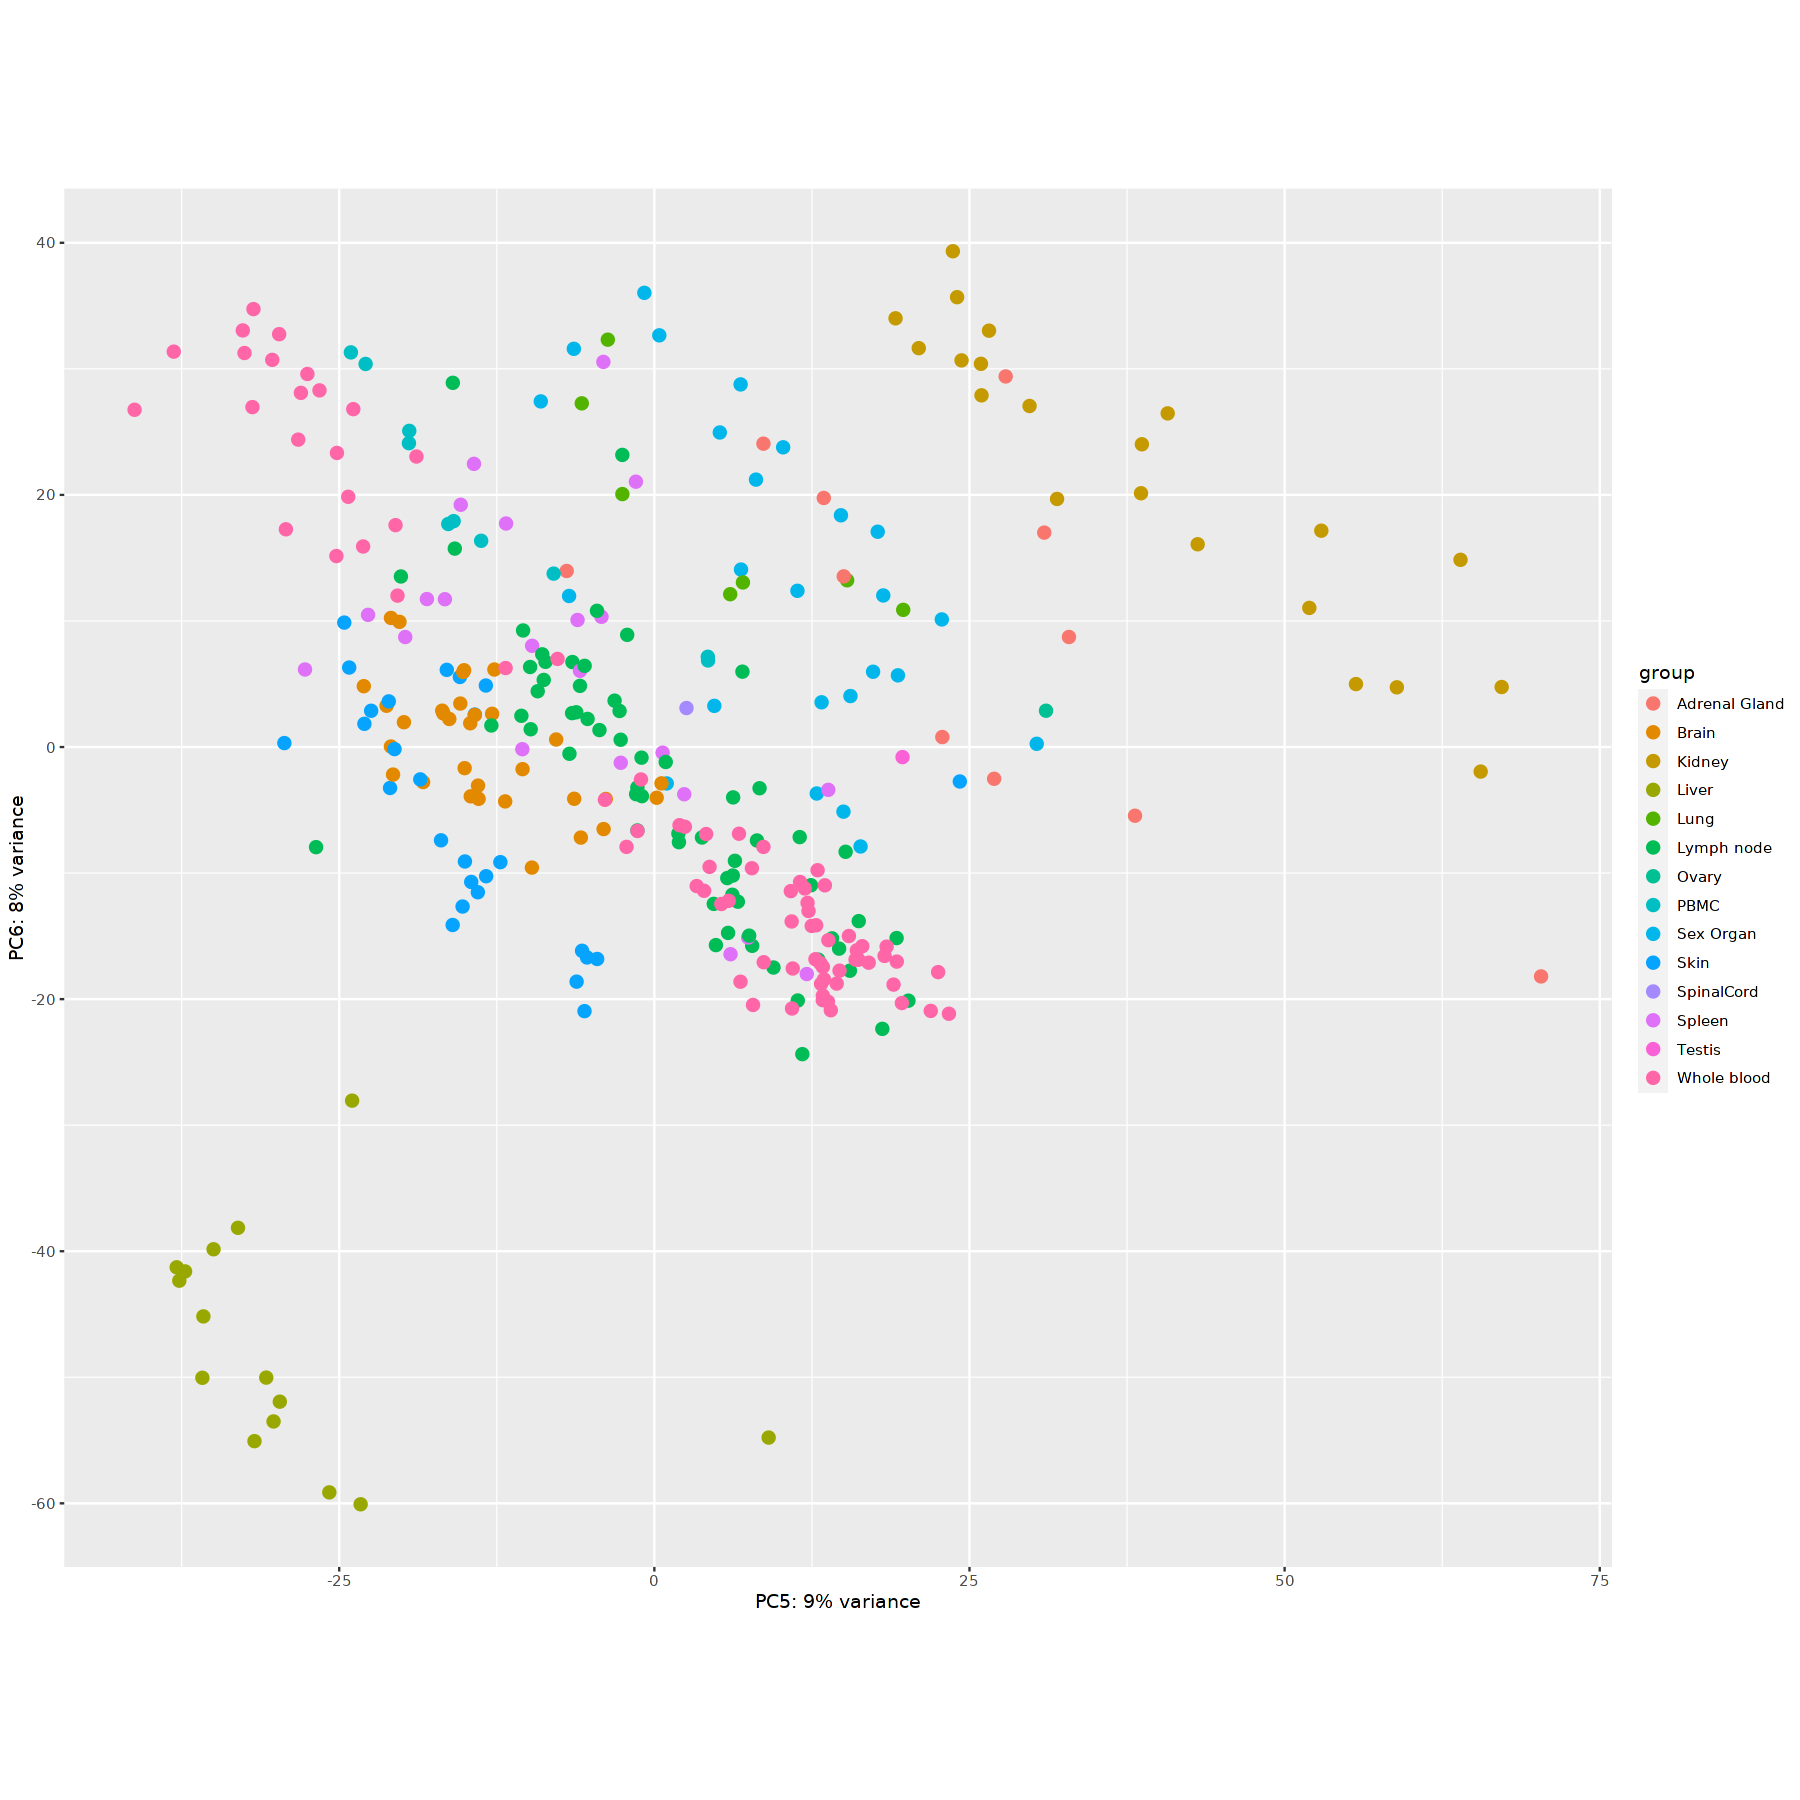

In [47]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC5", y = "PC6", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC5: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC6: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

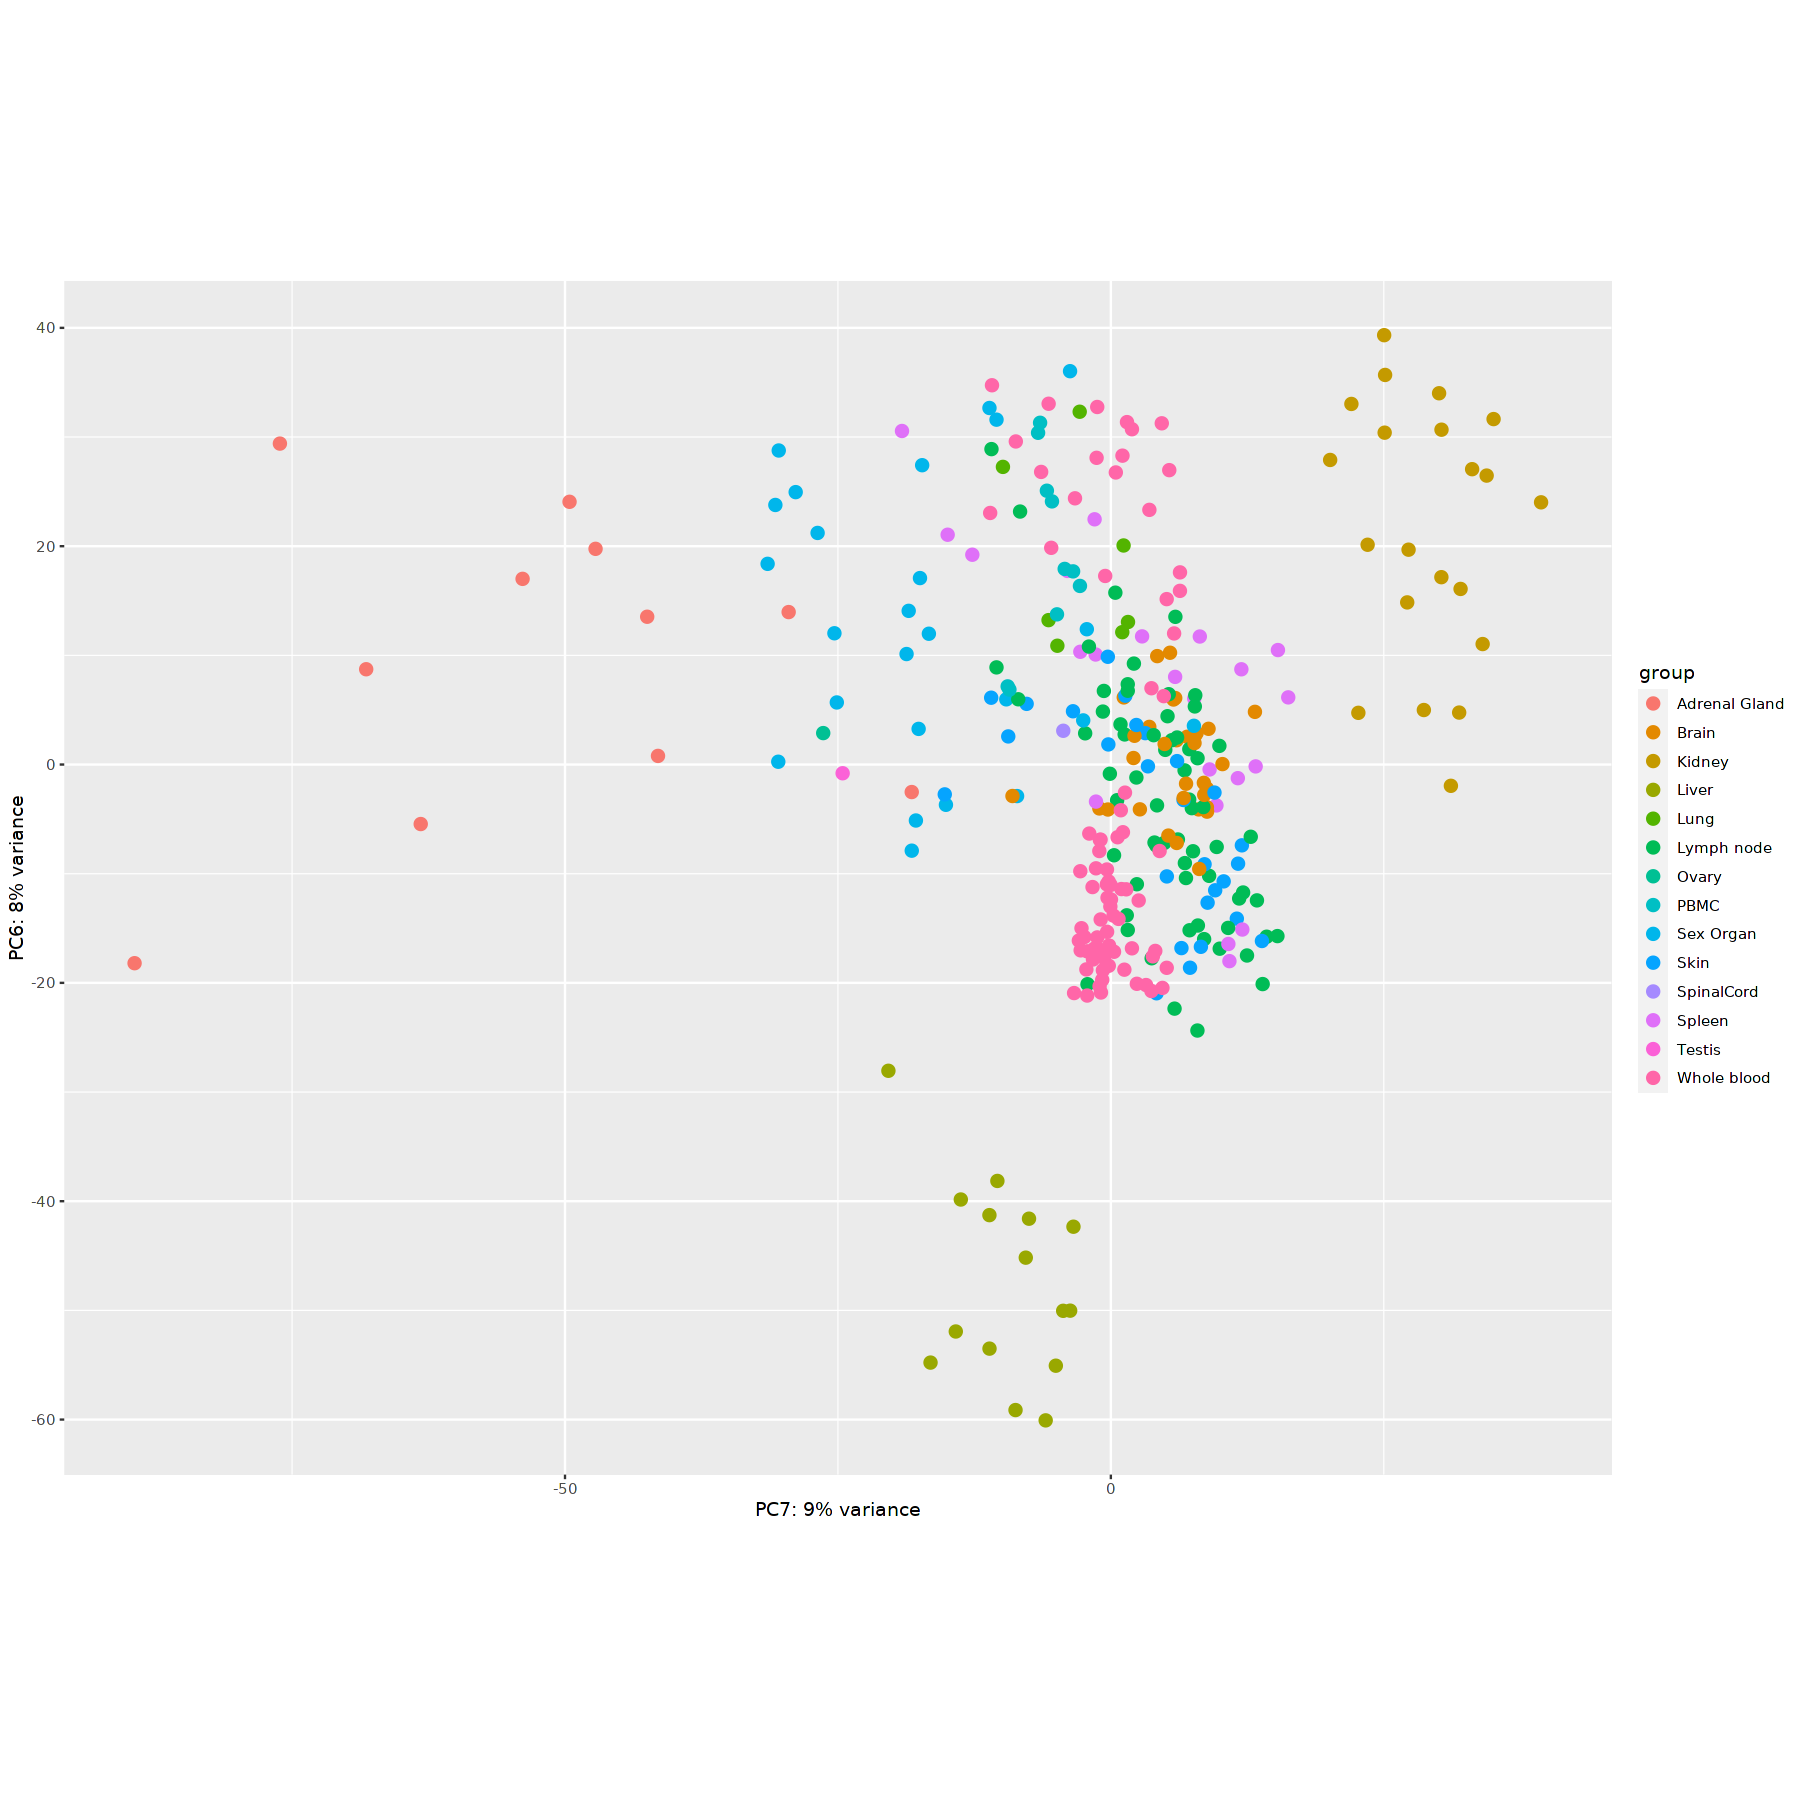

In [48]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC7", y = "PC6", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC7: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC6: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

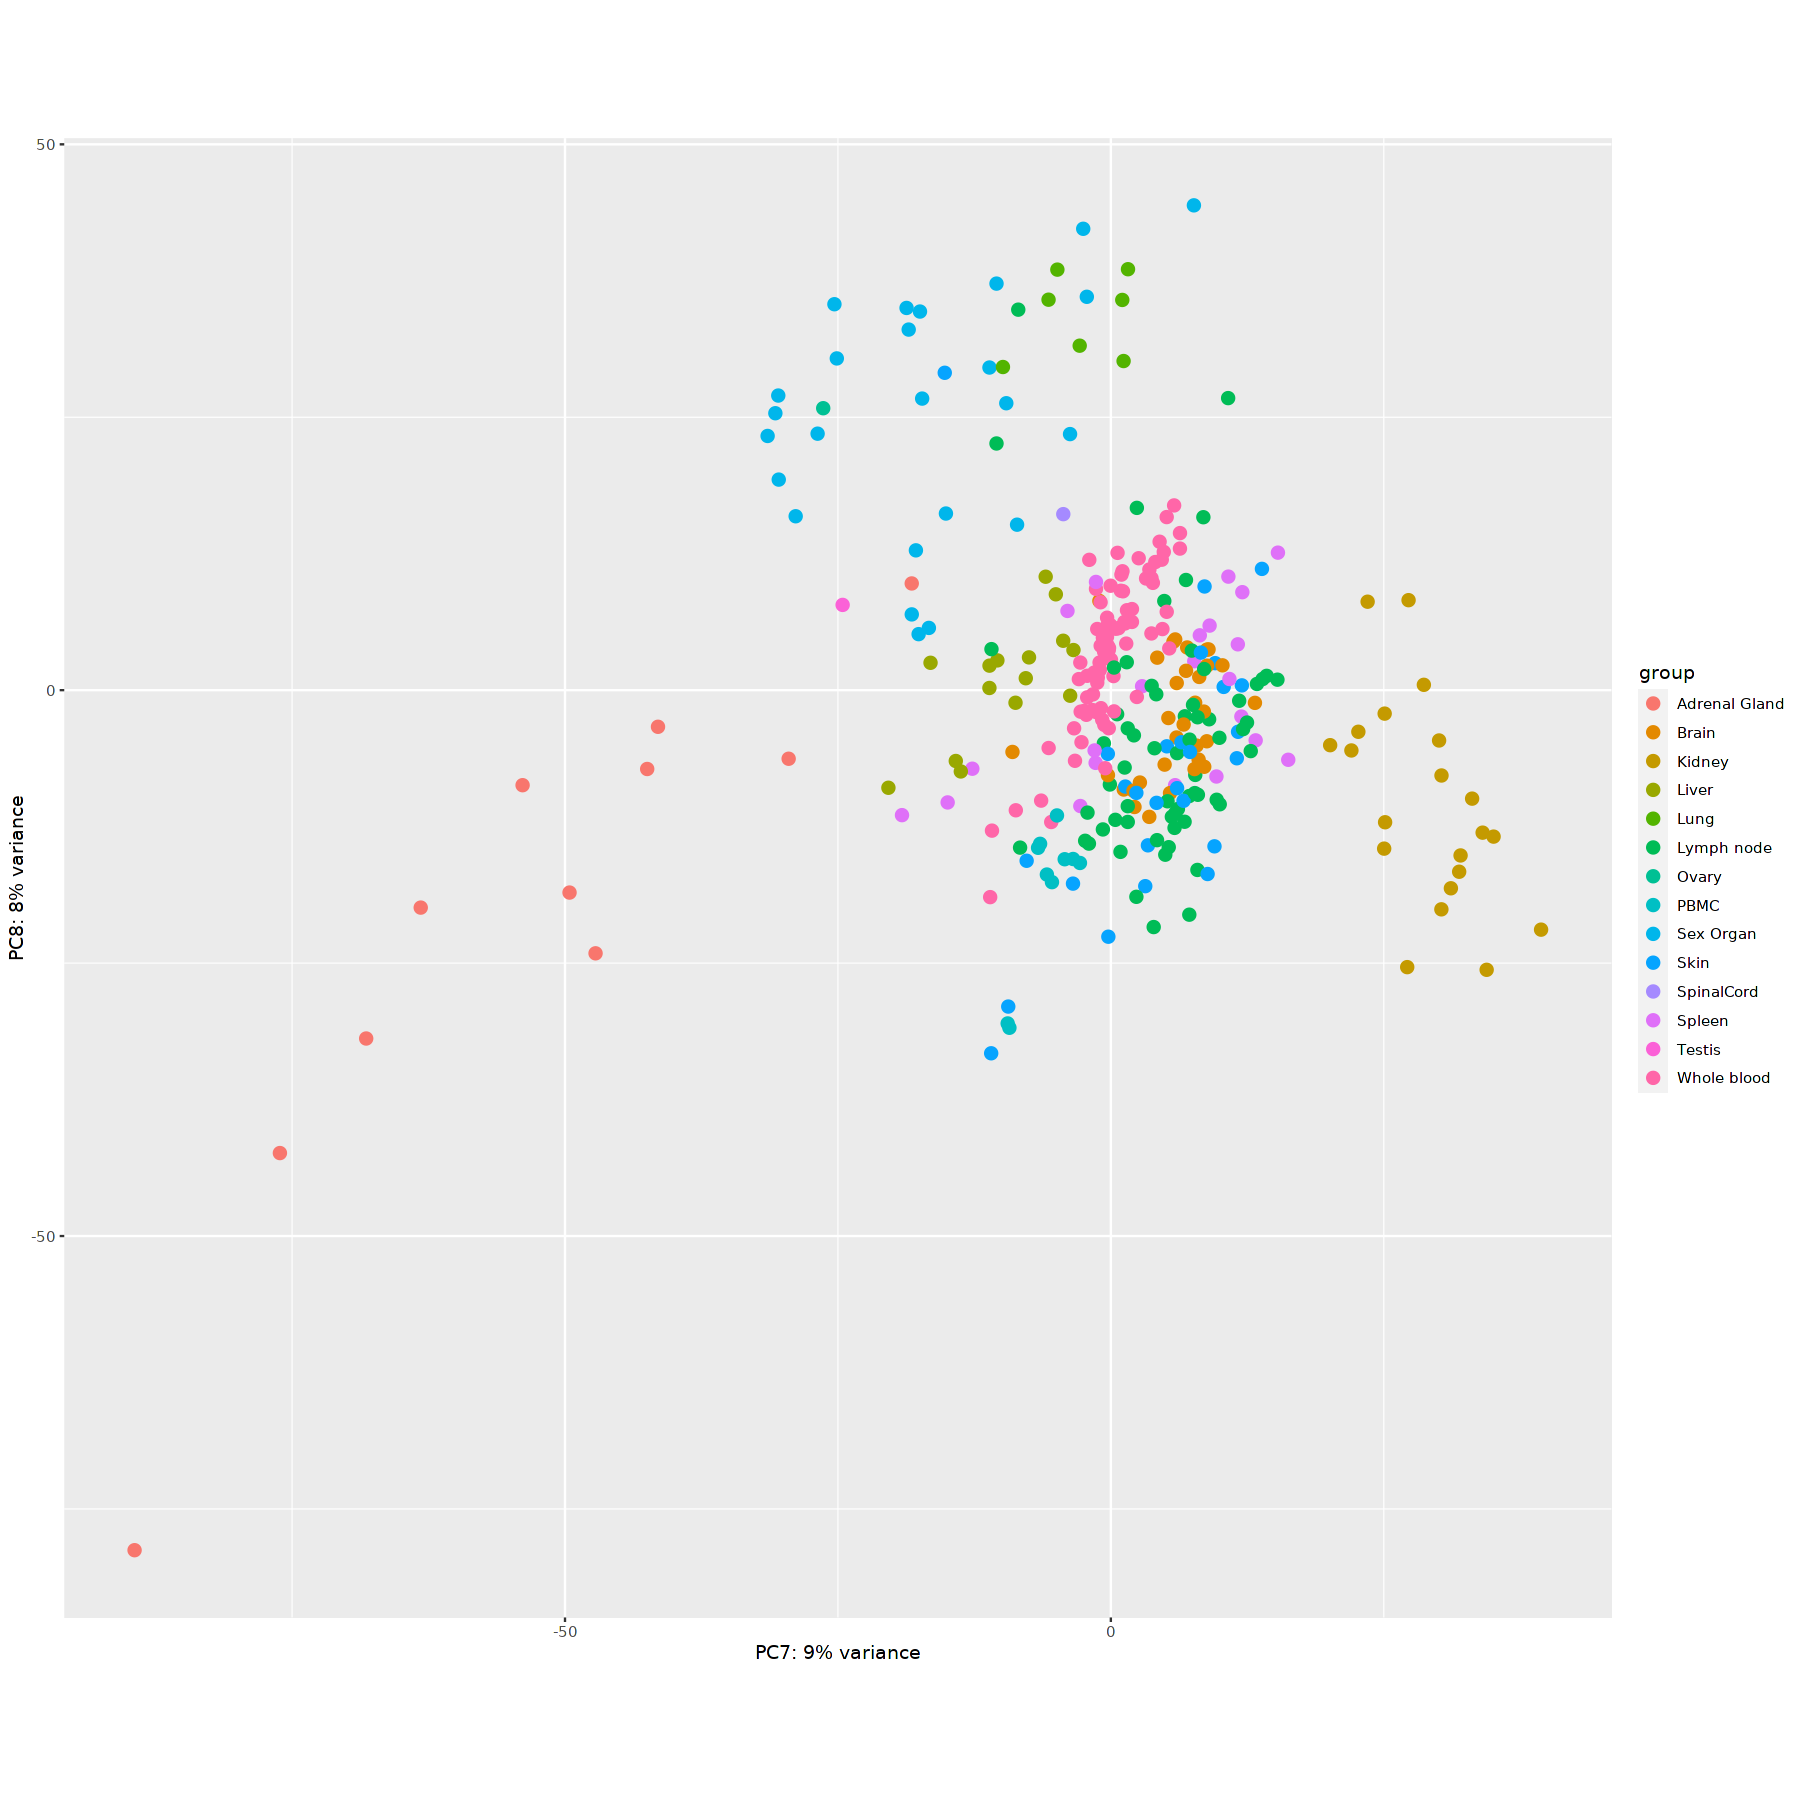

In [49]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC7", y = "PC8", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC7: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC8: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

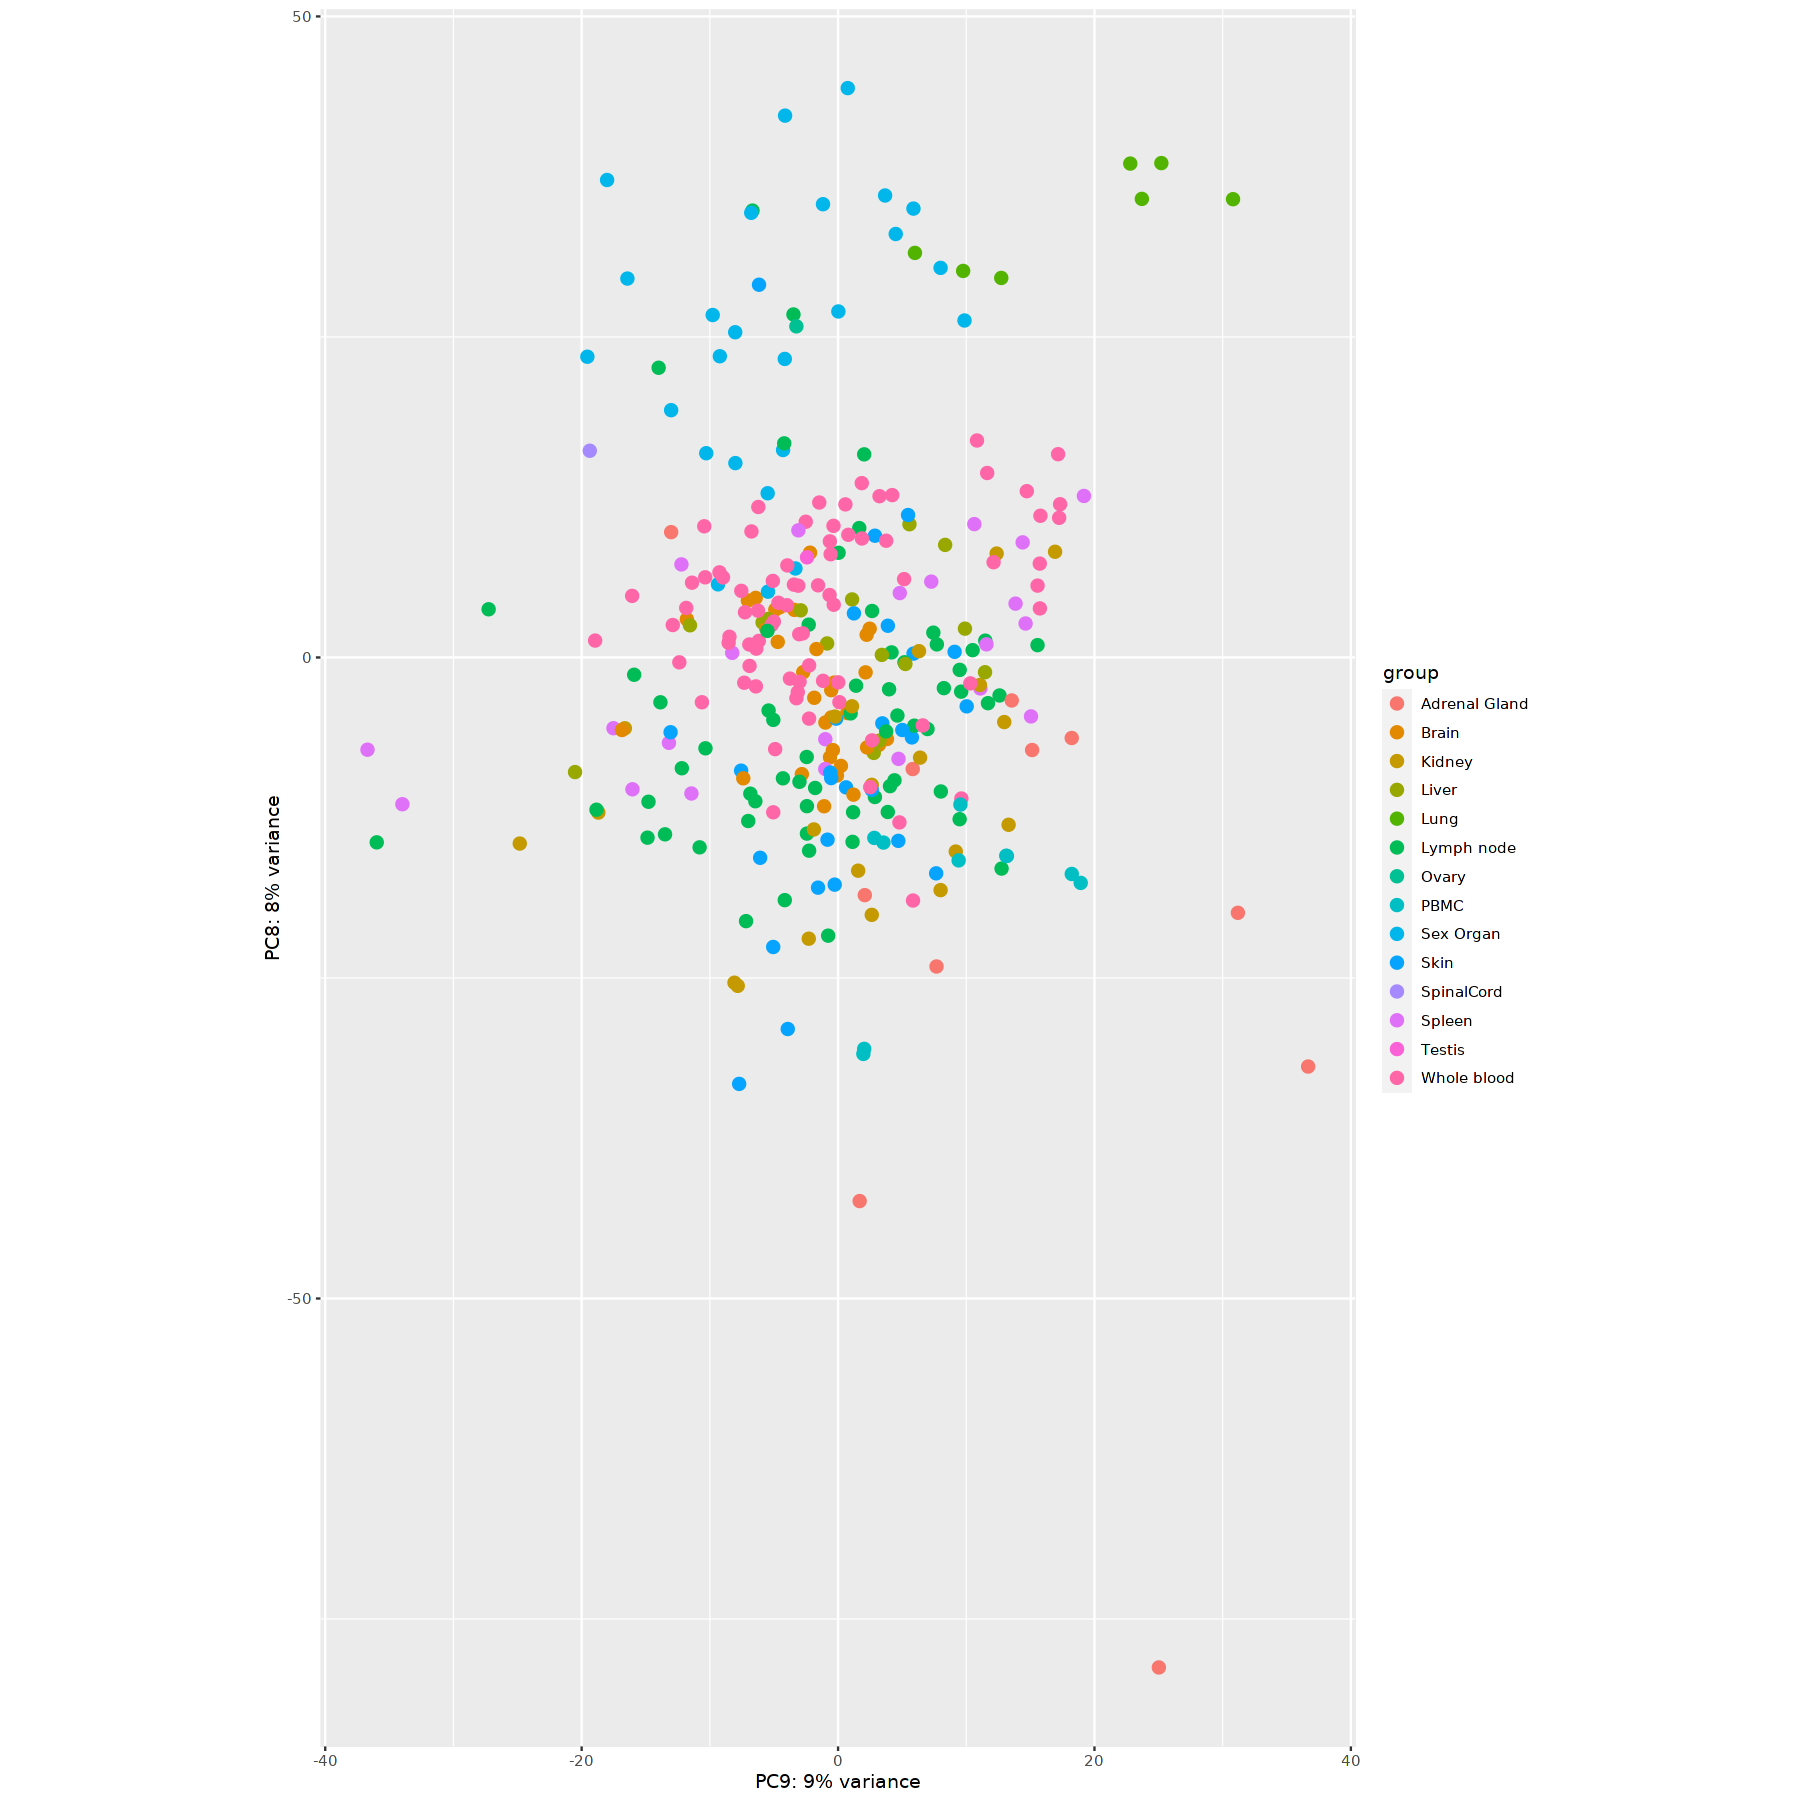

In [50]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC9", y = "PC8", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC9: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC8: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

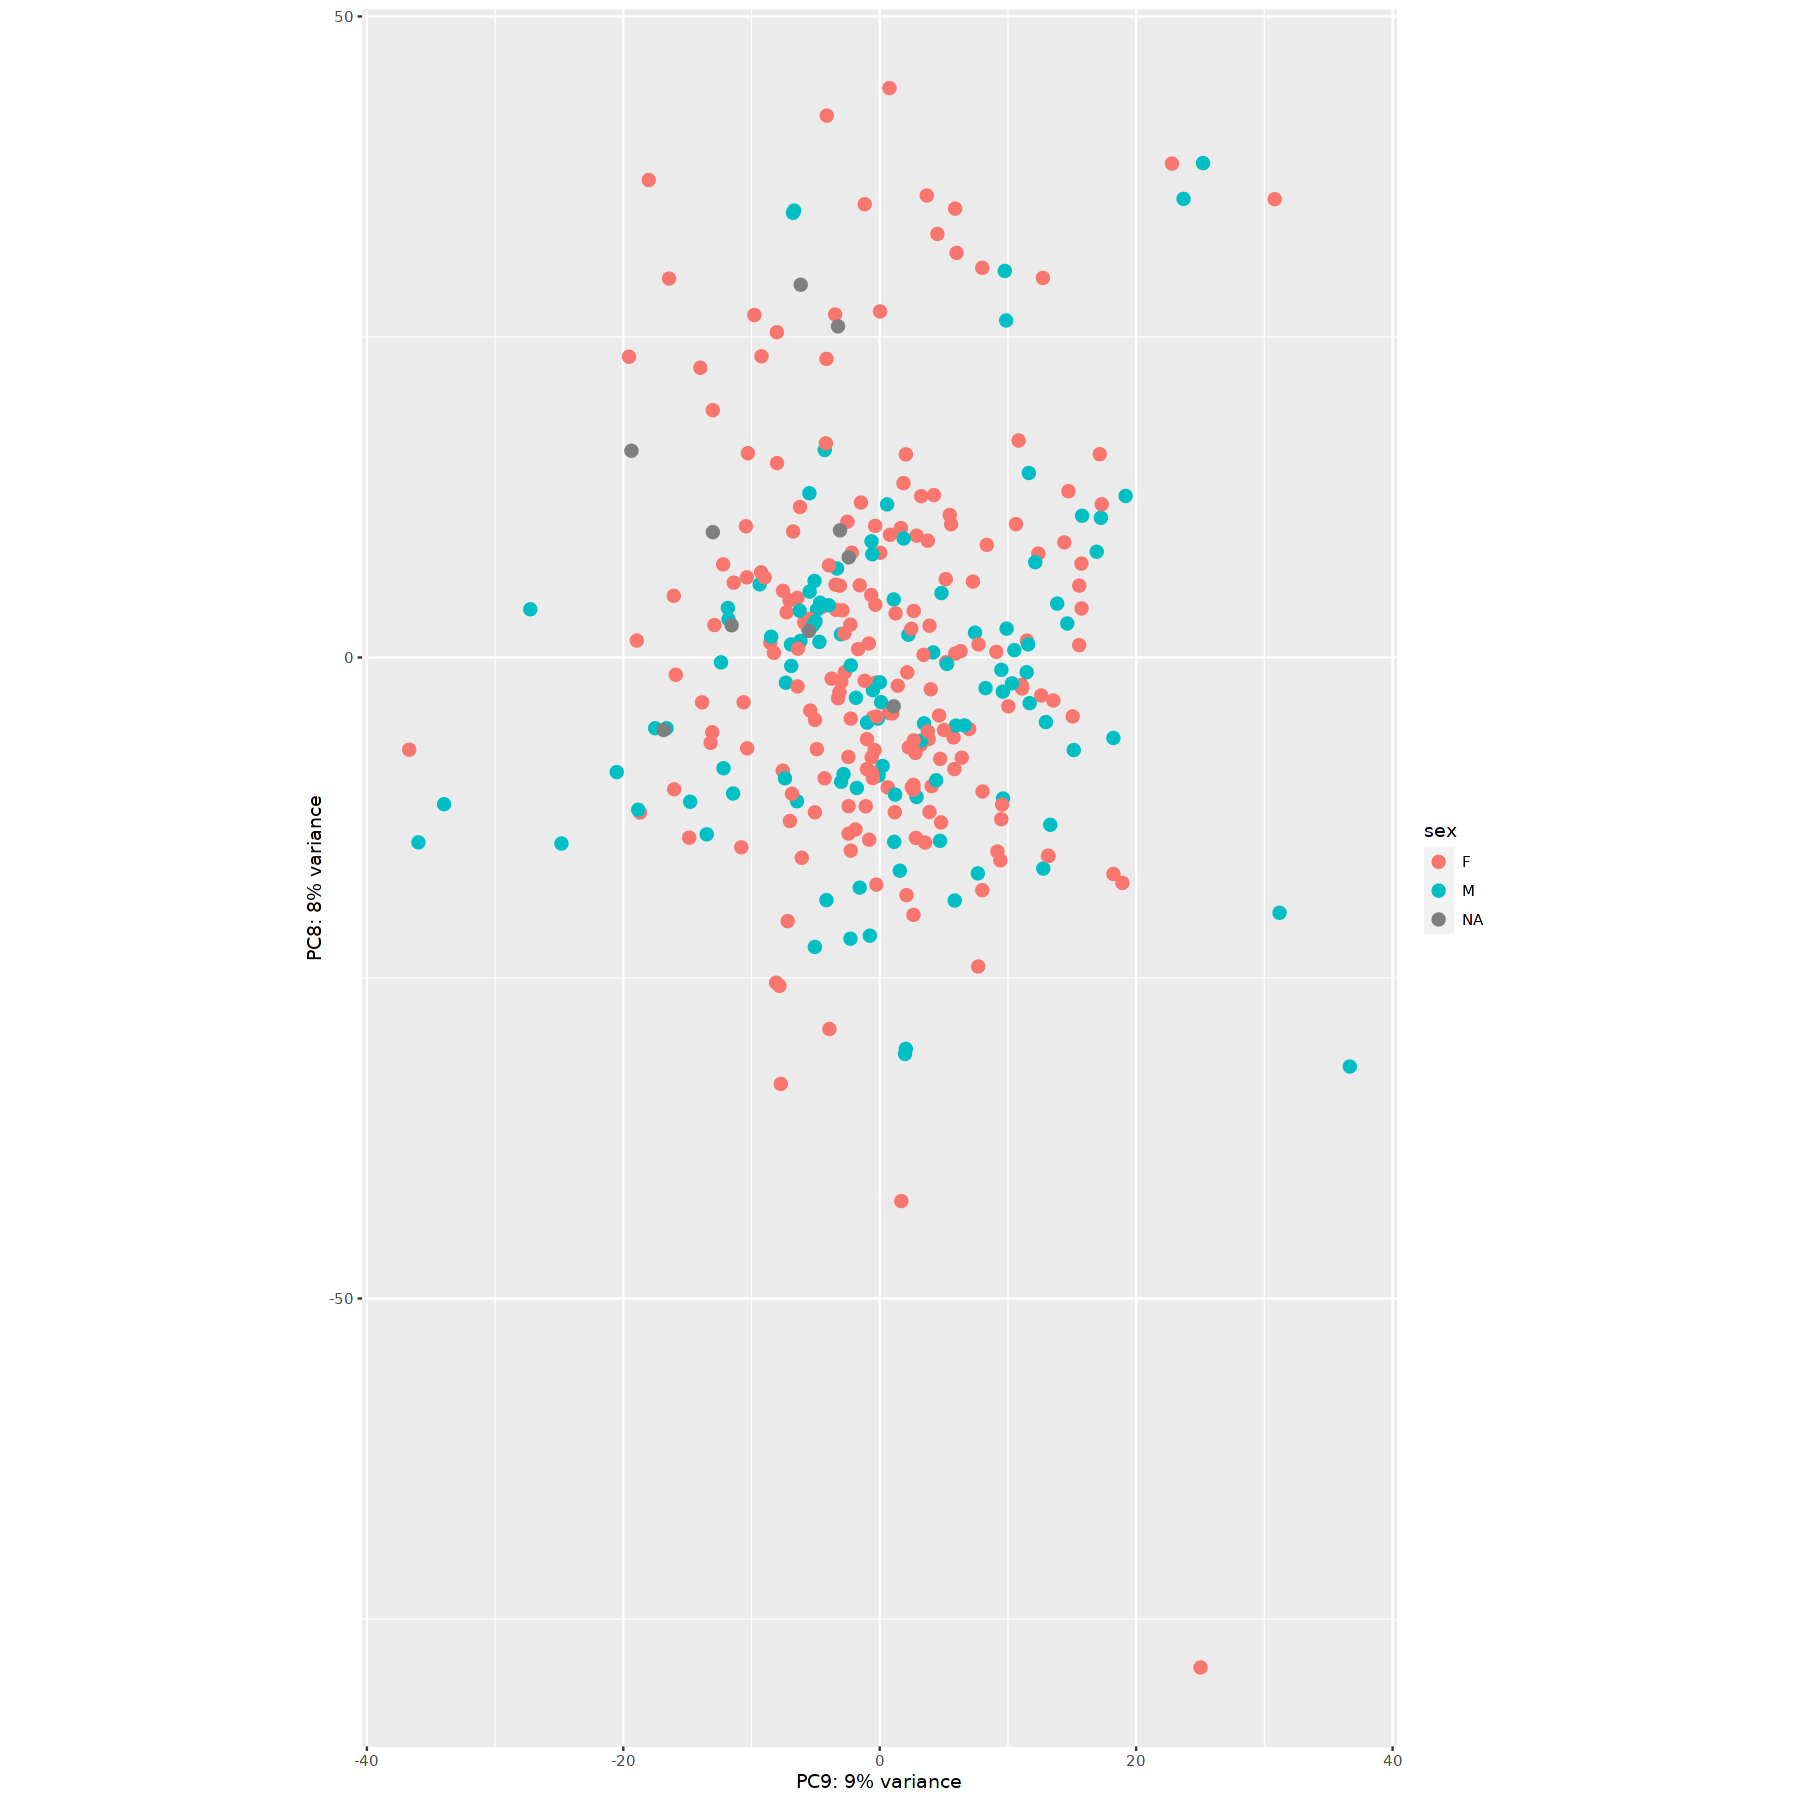

In [51]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC9", y = "PC8", color = "sex")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC9: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC8: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

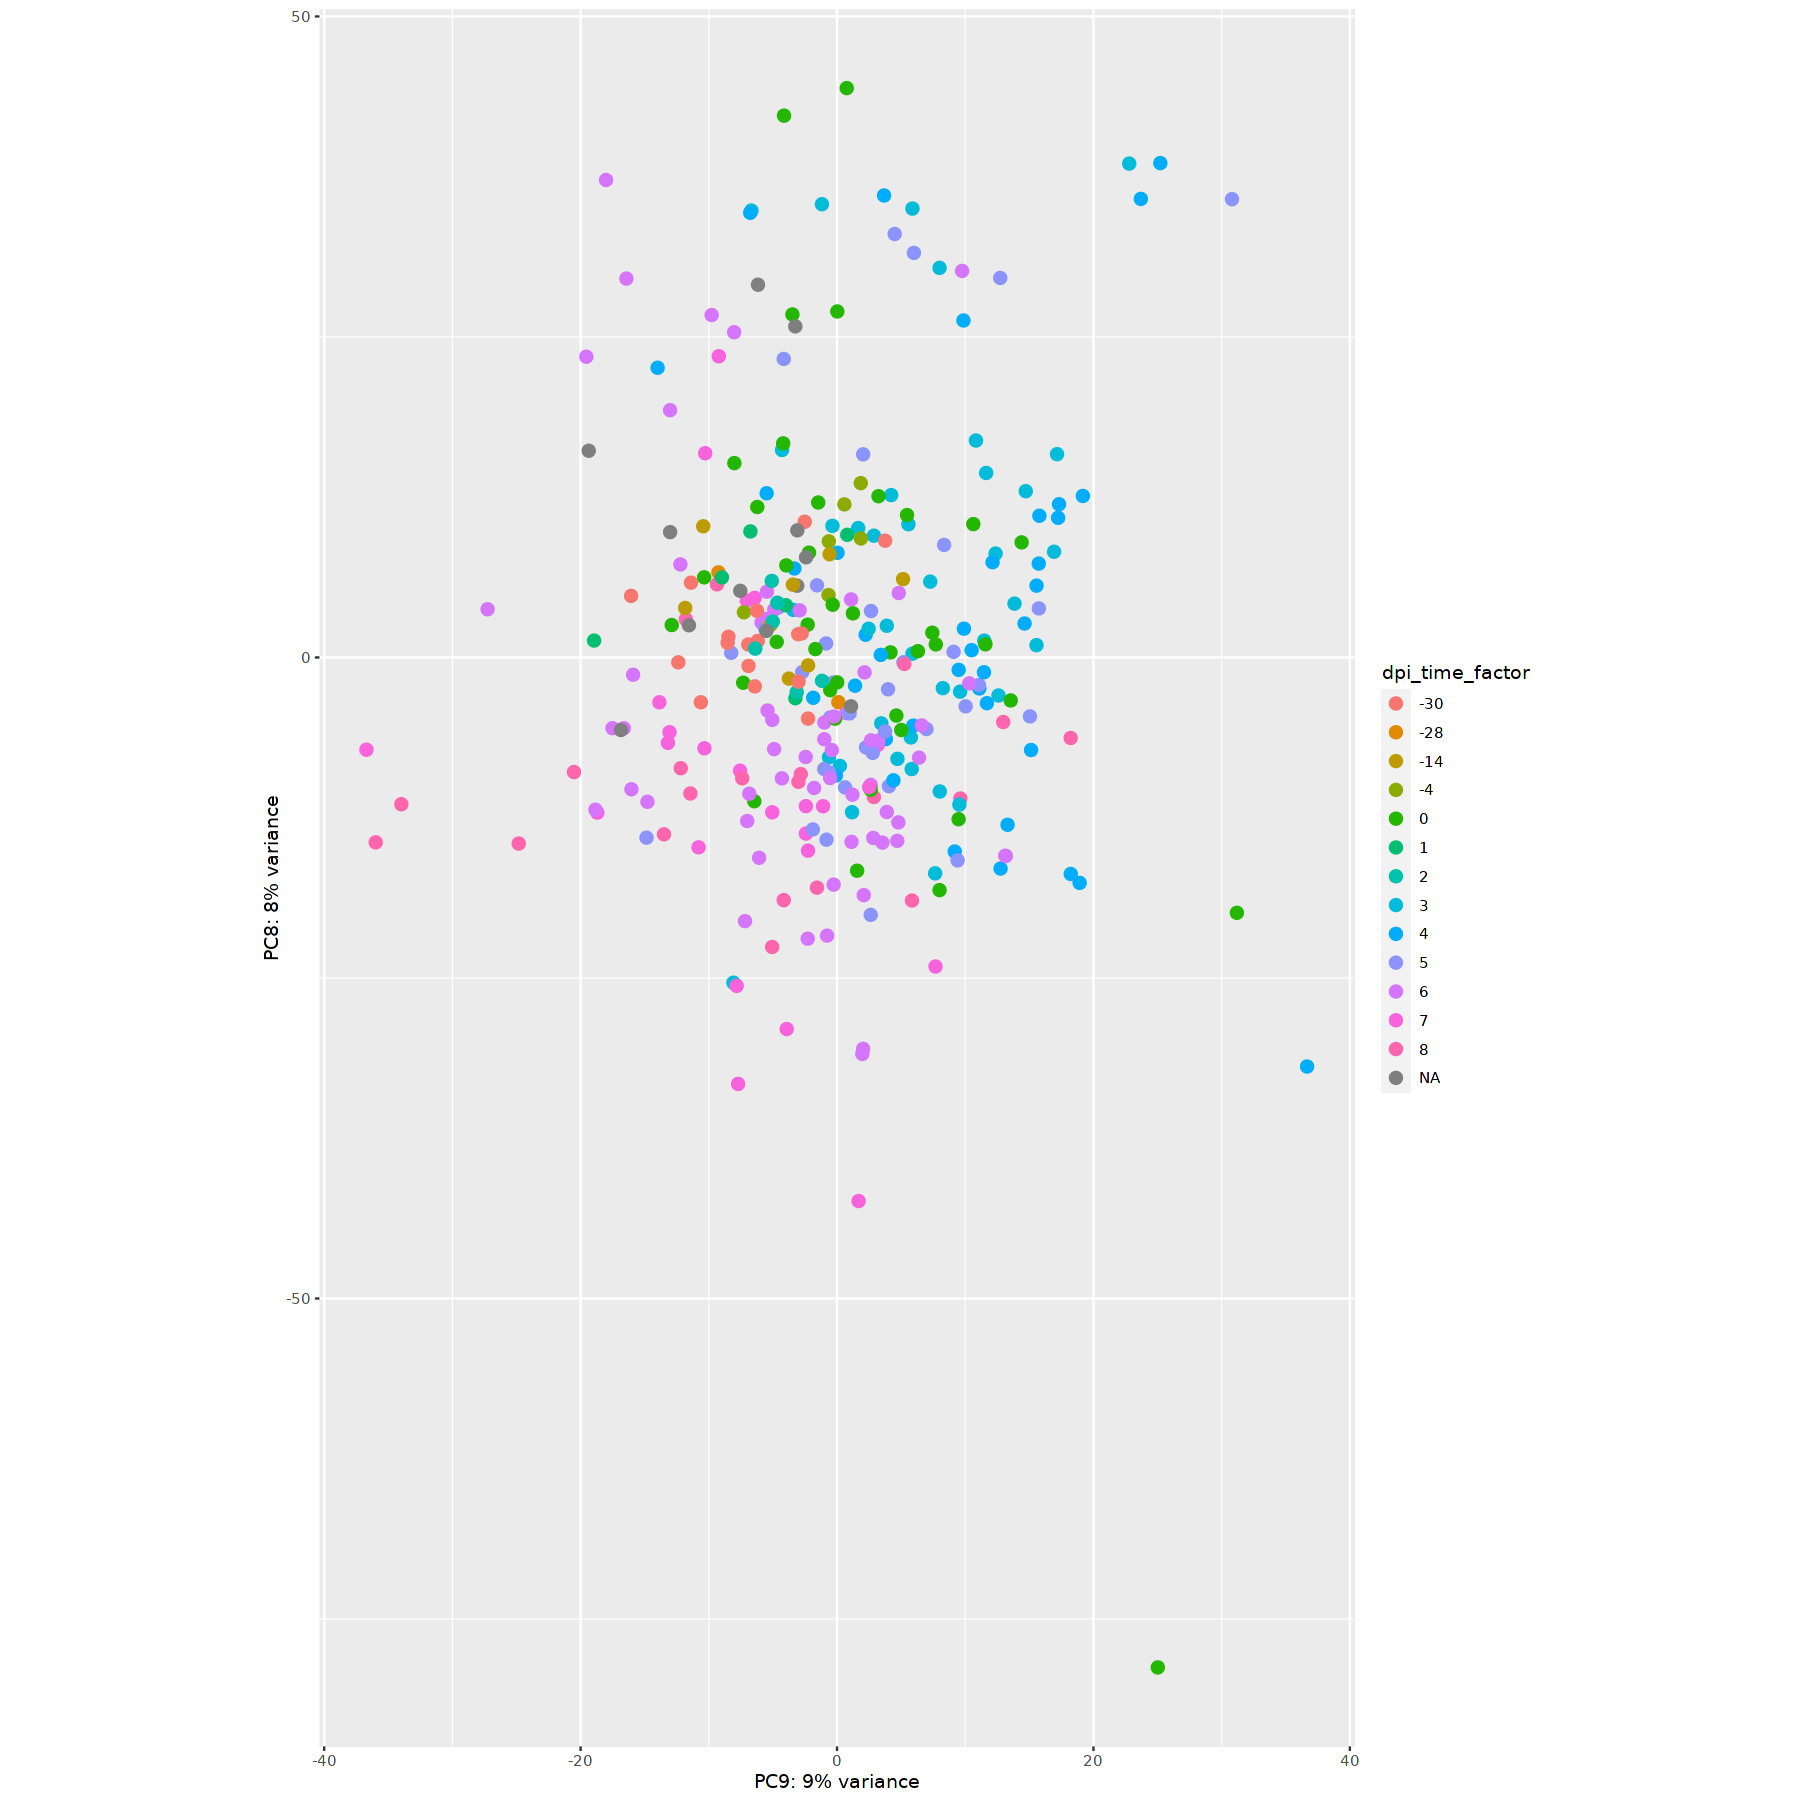

In [52]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC9", y = "PC8", color = "dpi_time_factor")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC9: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC8: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

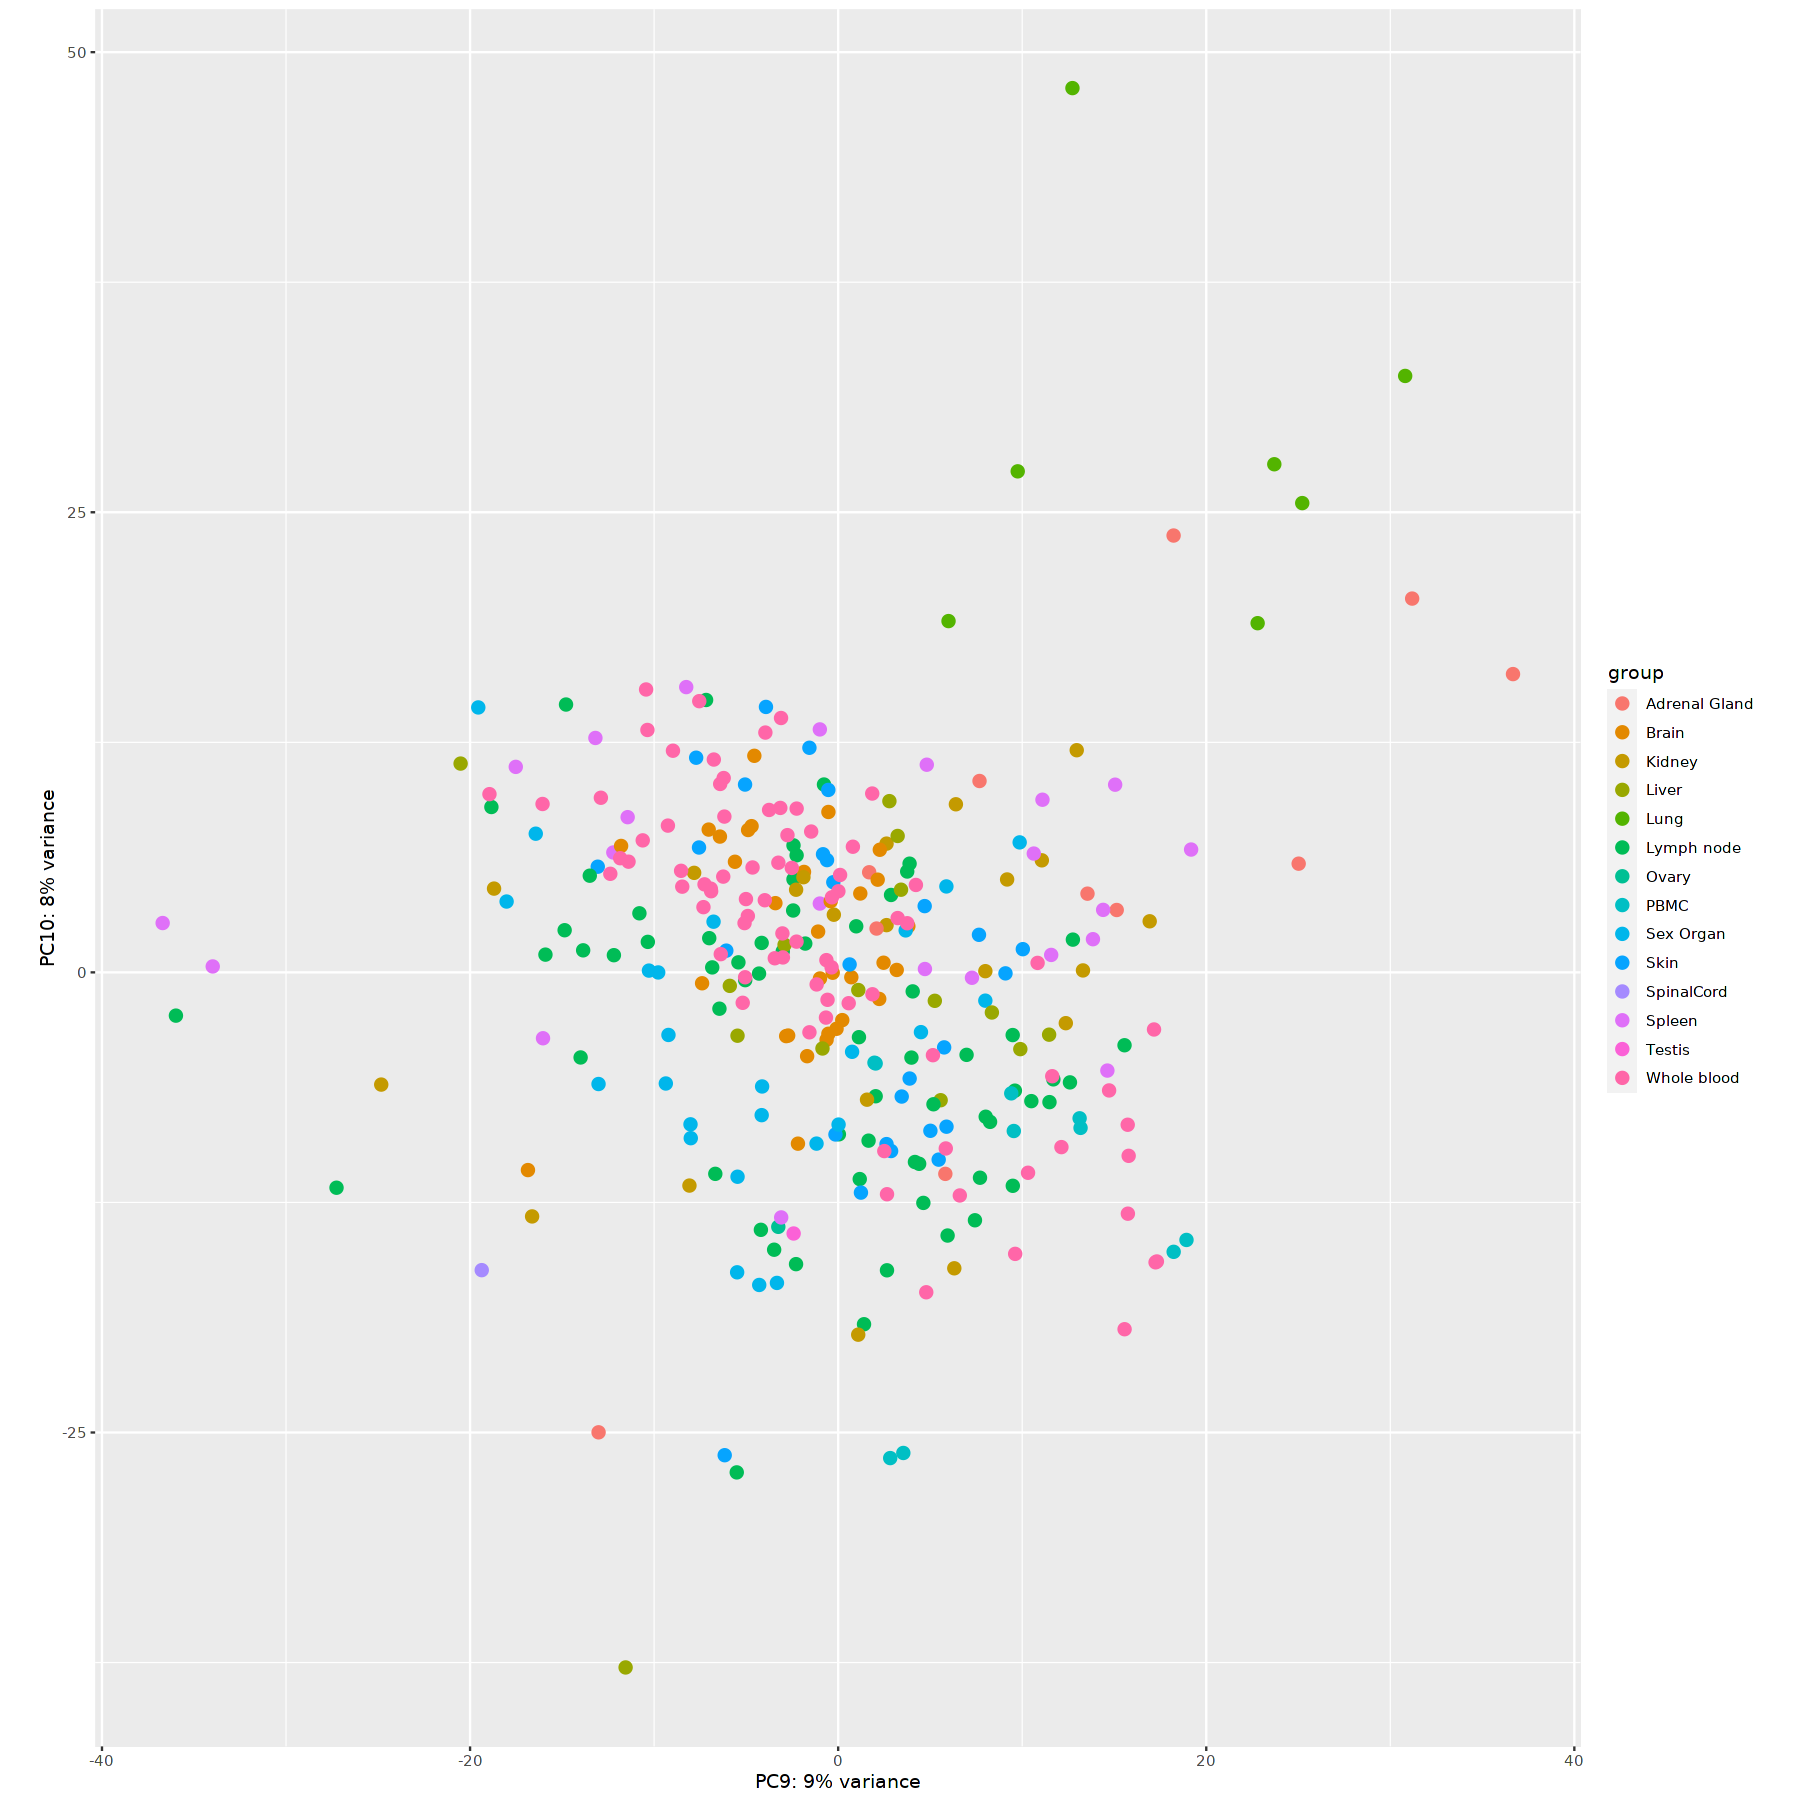

In [53]:
    ggplot2::ggplot(data = d, ggplot2::aes_string(x = "PC9", y = "PC10", color = "group")) +
      ggplot2::geom_point(size = 3) + 
      ggplot2::xlab(paste0("PC9: ", round(percentVar[3] * 100), "% variance")) + 
      ggplot2::ylab(paste0("PC10: ", round(percentVar[4] * 100), "% variance")) + 
      ggplot2::coord_fixed()

In [54]:
# In addition, later in the analysis we find that  "A0344_S83_L001" and "A0343_S84_L001" clusters with the incorrect timepoint
samples_to_remove <- c(samples_to_remove, "A0344_S83_L001","A0343_S84_L001")

In [55]:
samples_to_remove

[1] "A0273_S48_L001"  "A0155_S110_L002" "A0344_S83_L001"  "A0343_S84_L001"

## Pass 2: Remove the samples identified in the first pass

In [56]:
se.qc.pass1 <- se.qc.remove_sex_mismatch[, !(colnames(se.qc.remove_sex_mismatch) %in% samples_to_remove)]

In [57]:
dds.pass1 <- DESeqDataSet(se.qc.pass1, design=~1)

In [58]:
dds.pass1 <- DESeq(dds.pass1)

Warning message in DESeq(dds.pass1):
“the design is ~ 1 (just an intercept). is this intended?”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4946 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [59]:
vsd.pass1 <- vst(dds.pass1)

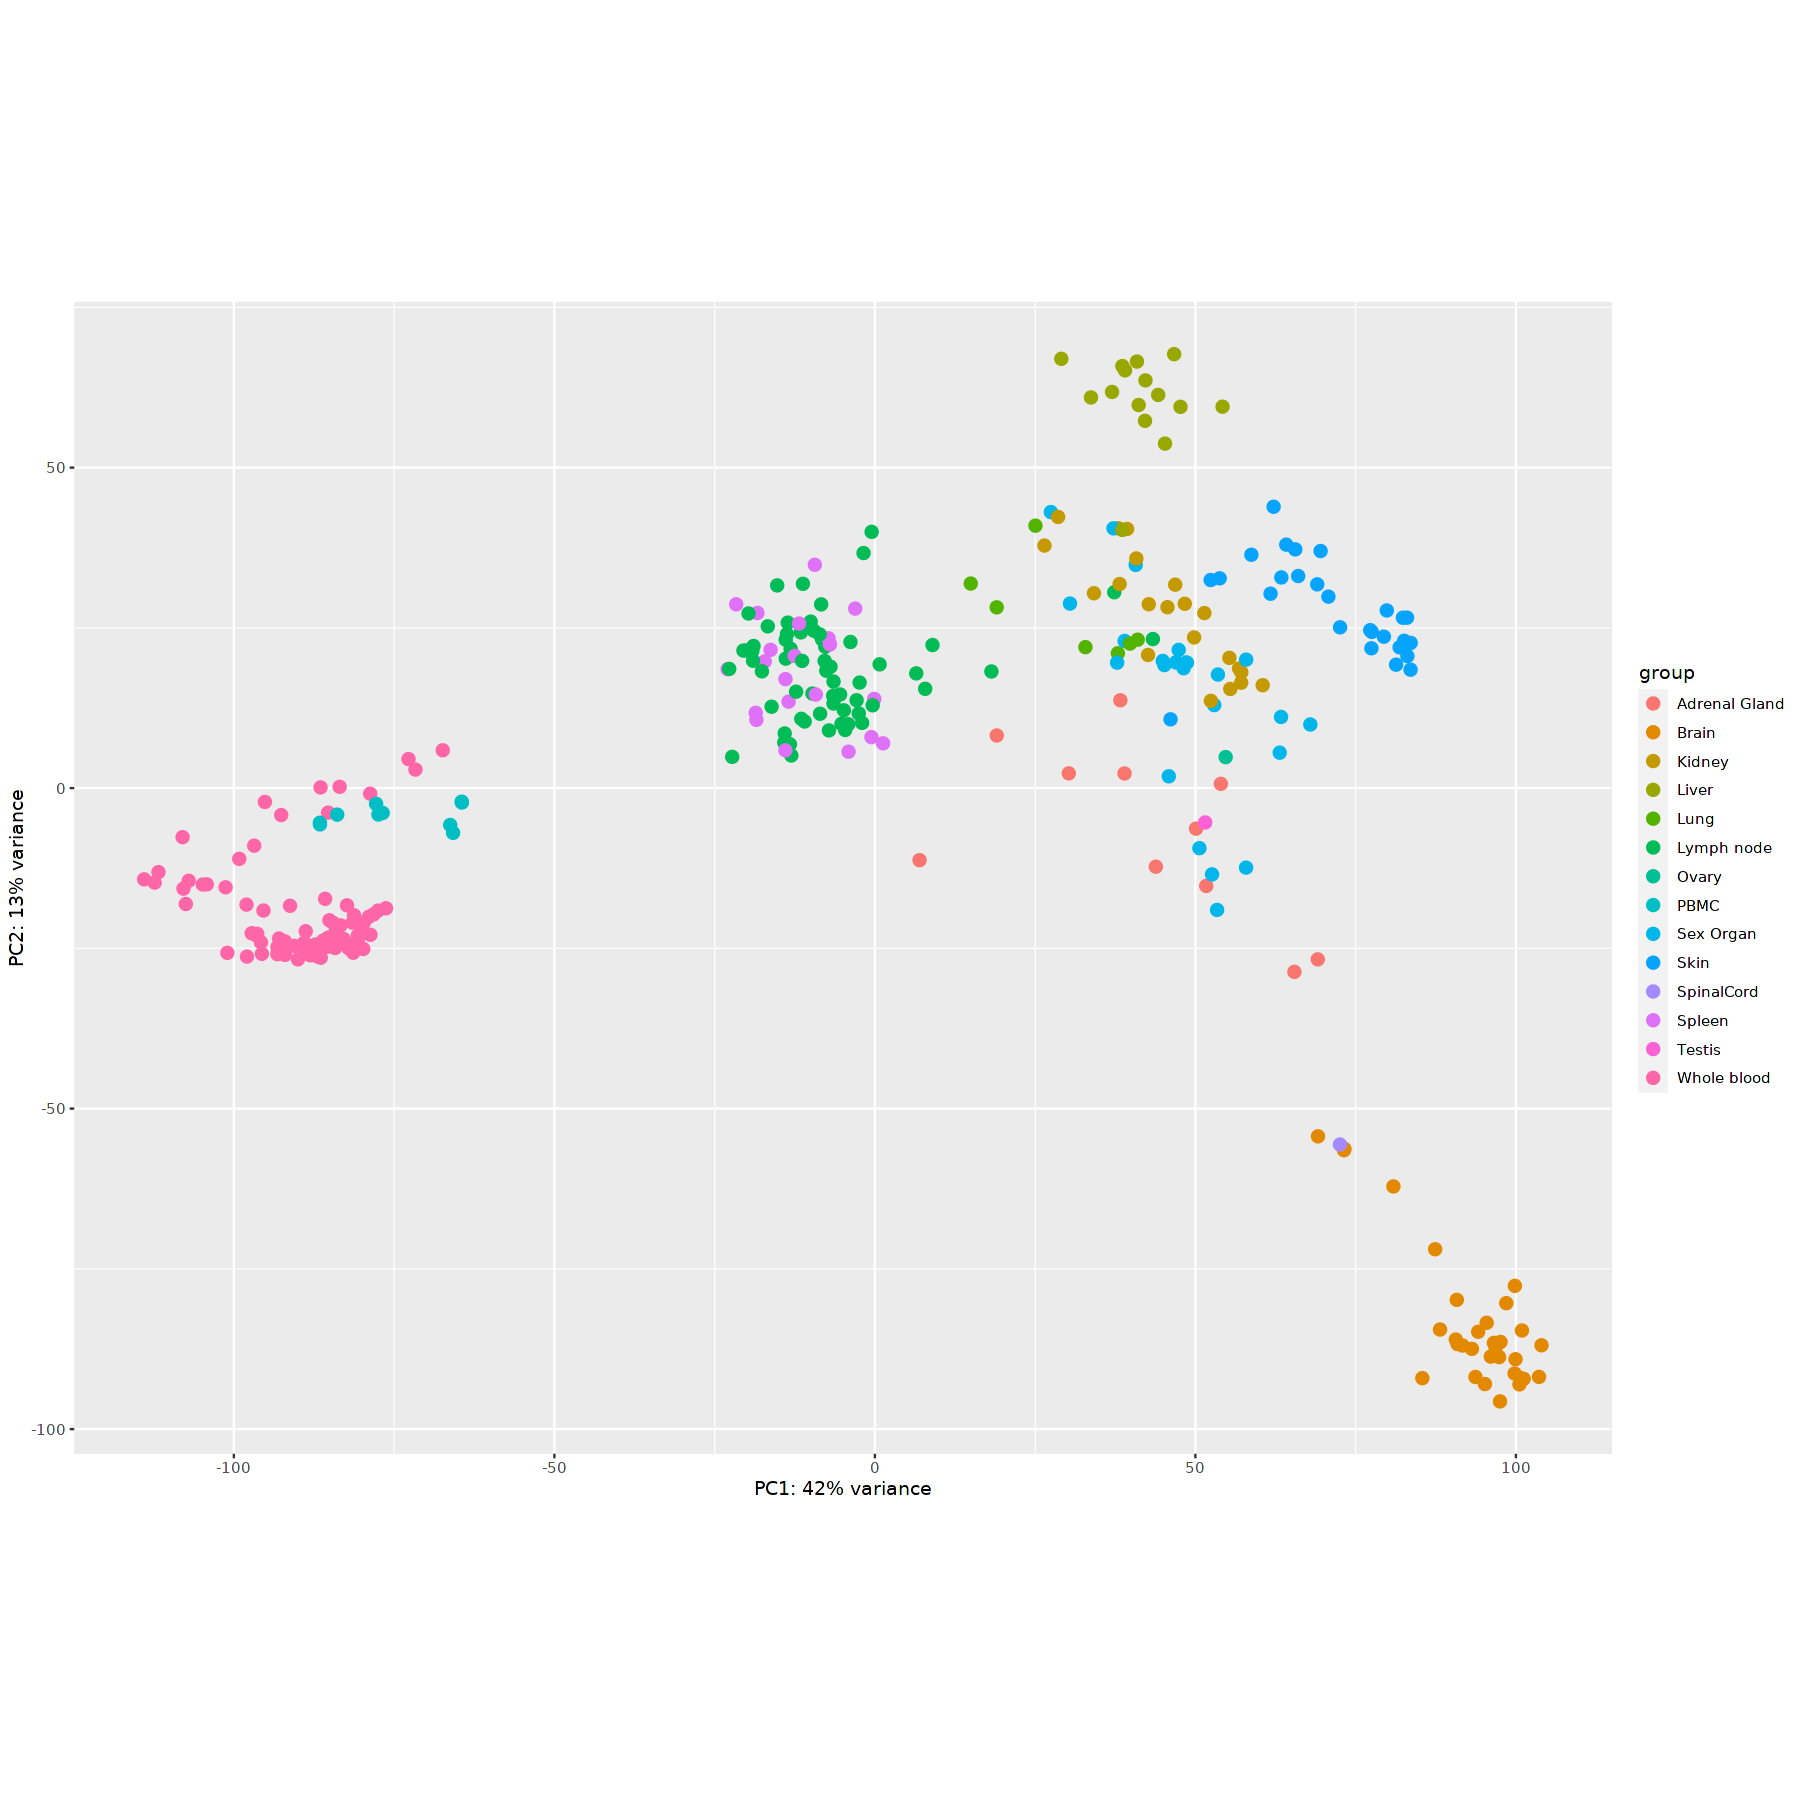

In [60]:
customPlotPCA(vsd.pass1, 'tissue', ntop=3000)

Let's now remove the tissues that are clearly different (Blood, PBMC and Brain) and do this again to see if we can get better separation of the remaining tissues and potentially identify any other mixups.

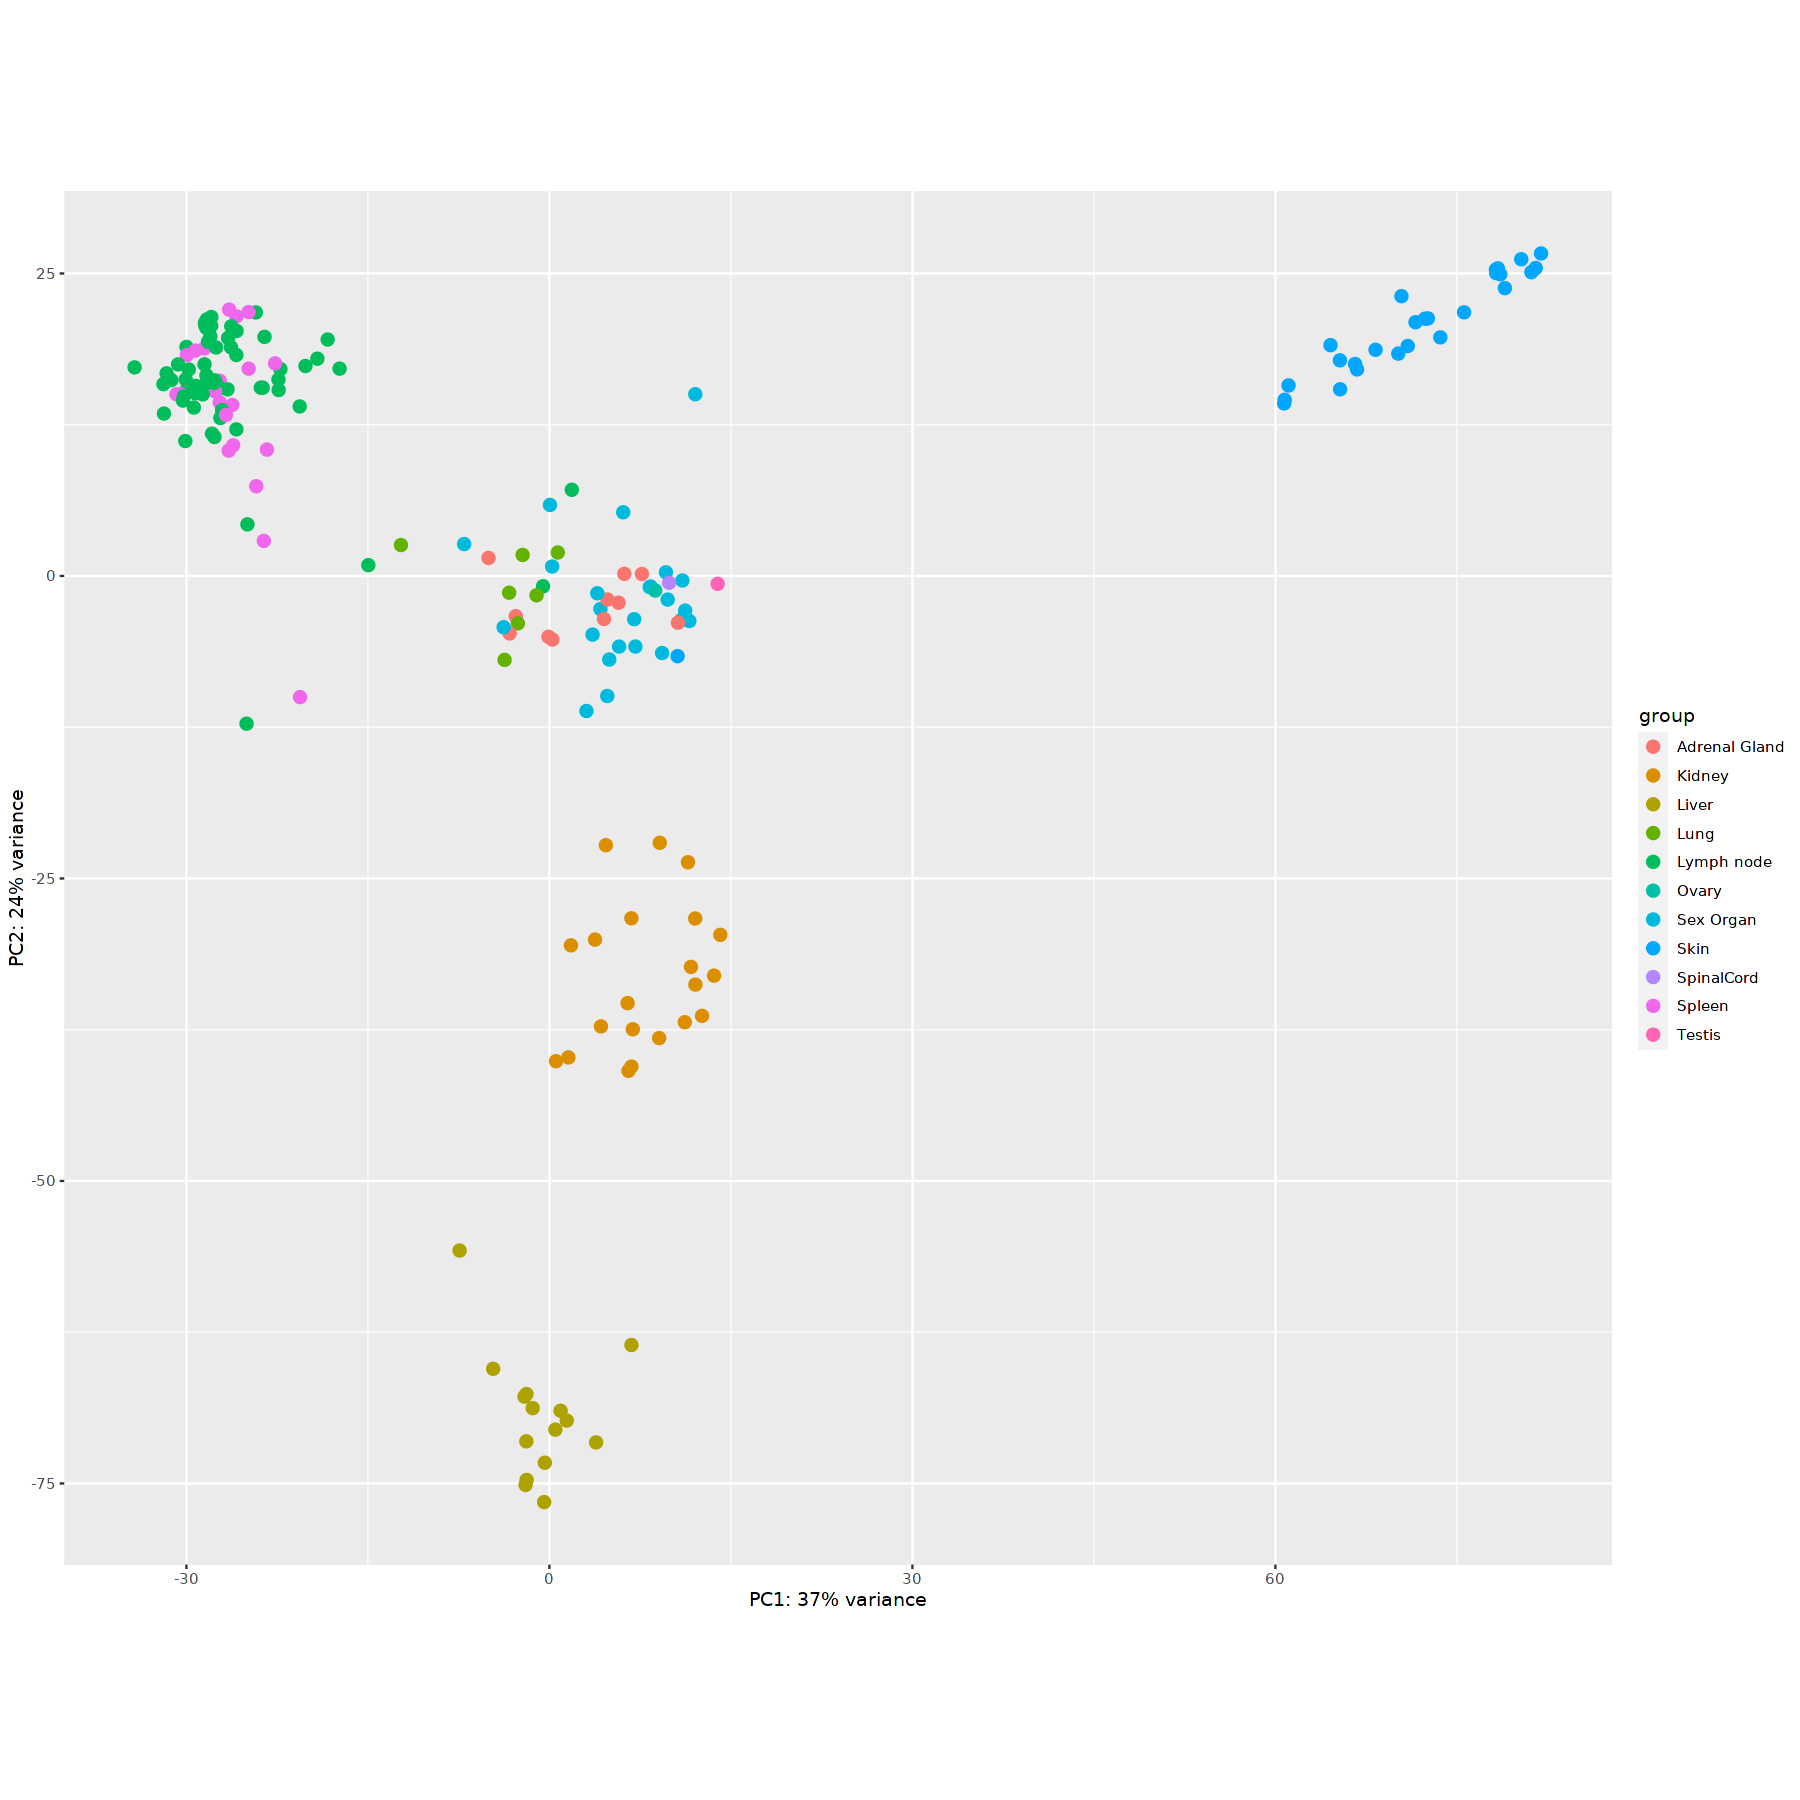

In [61]:
dds.pass1.subtissue <- dds.pass1[,!(colData(dds.pass1)$tissue %in% c("Brain","PBMC","Whole blood"))]
vsn.pass1.subtissue <- vst(dds.pass1.subtissue)
plotPCA(vsn.pass1.subtissue, intgroup='tissue')

In [62]:
colnames(colData(vsn.pass1.subtissue))

[1] "file_identifiers"              "A.identifier"                 
 [3] "biosample"                     "batch.extraction"             
 [5] "irf.study.id"                  "id.cohort"                    
 [7] "id.individual"                 "tissue"                       
 [9] "data.received"                 "dn.rna"                       
[11] "date.broad.extract"            "quant.18s"                    
[13] "quant.18s.sd"                  "quant.kulesh"                 
[15] "quant.kulesh.sd"               "rin.e"                        
[17] "rna.conc.ng.uL"                "lib.conc.pmolar"              
[19] "xgen.index"                    "Assigned"                     
[21] "Unassigned_Unmapped"           "Unassigned_Read_Type"         
[23] "Unassigned_Singleton"          "Unassigned_MappingQuality"    
[25] "Unassigned_Chimera"            "Unassigned_FragmentLength"    
[27] "Unassigned_Duplicate"          "Unassigned_MultiMapping"      
[29] "Unassigned_Secondary"          "Unassigned_NonSplit"          
[31] "Unassigned_NoFeatures"         "Unassigned_Overlapping_Length"
[33] "Unassigned_Ambiguity"          "sub.tissue"                   
[35] "SampleType"                    "study.group"                  
[37] "challenge.group"               "animal.number"                
[39] "animal.tatoo"                  "sex"                          
[41] "weight"                        "birth.date"                   
[43] "viralReadCount"                "hostReadCount"                
[45] "pc.viral.reads"                "cohort.uncertain"             
[47] "cohort.numeric"                "totalReadCount"               
[49] "totalUnassigned"               "chrY_count"                   
[51] "chrX_count"                    "total_count"                  
[53] "Xist"                          "sex.1"                        
[55] "pc_Y"                          "pc_X"                         
[57] "Y_X_ratio"                     "sex_pred"                     
[59] "pred_recorded_sex_mismatch"    "dpi_time"                     
[61] "dpi_time_factor"               "xist_counts"                  
[63] "predicted_sex"                 "pred_rec_sex_mismatch"        
[65] "full.tissue"                   "sample_id_dedup"              
[67] "duplicate_sequencing"          "sizeFactor"                   
[69] "replaceable"

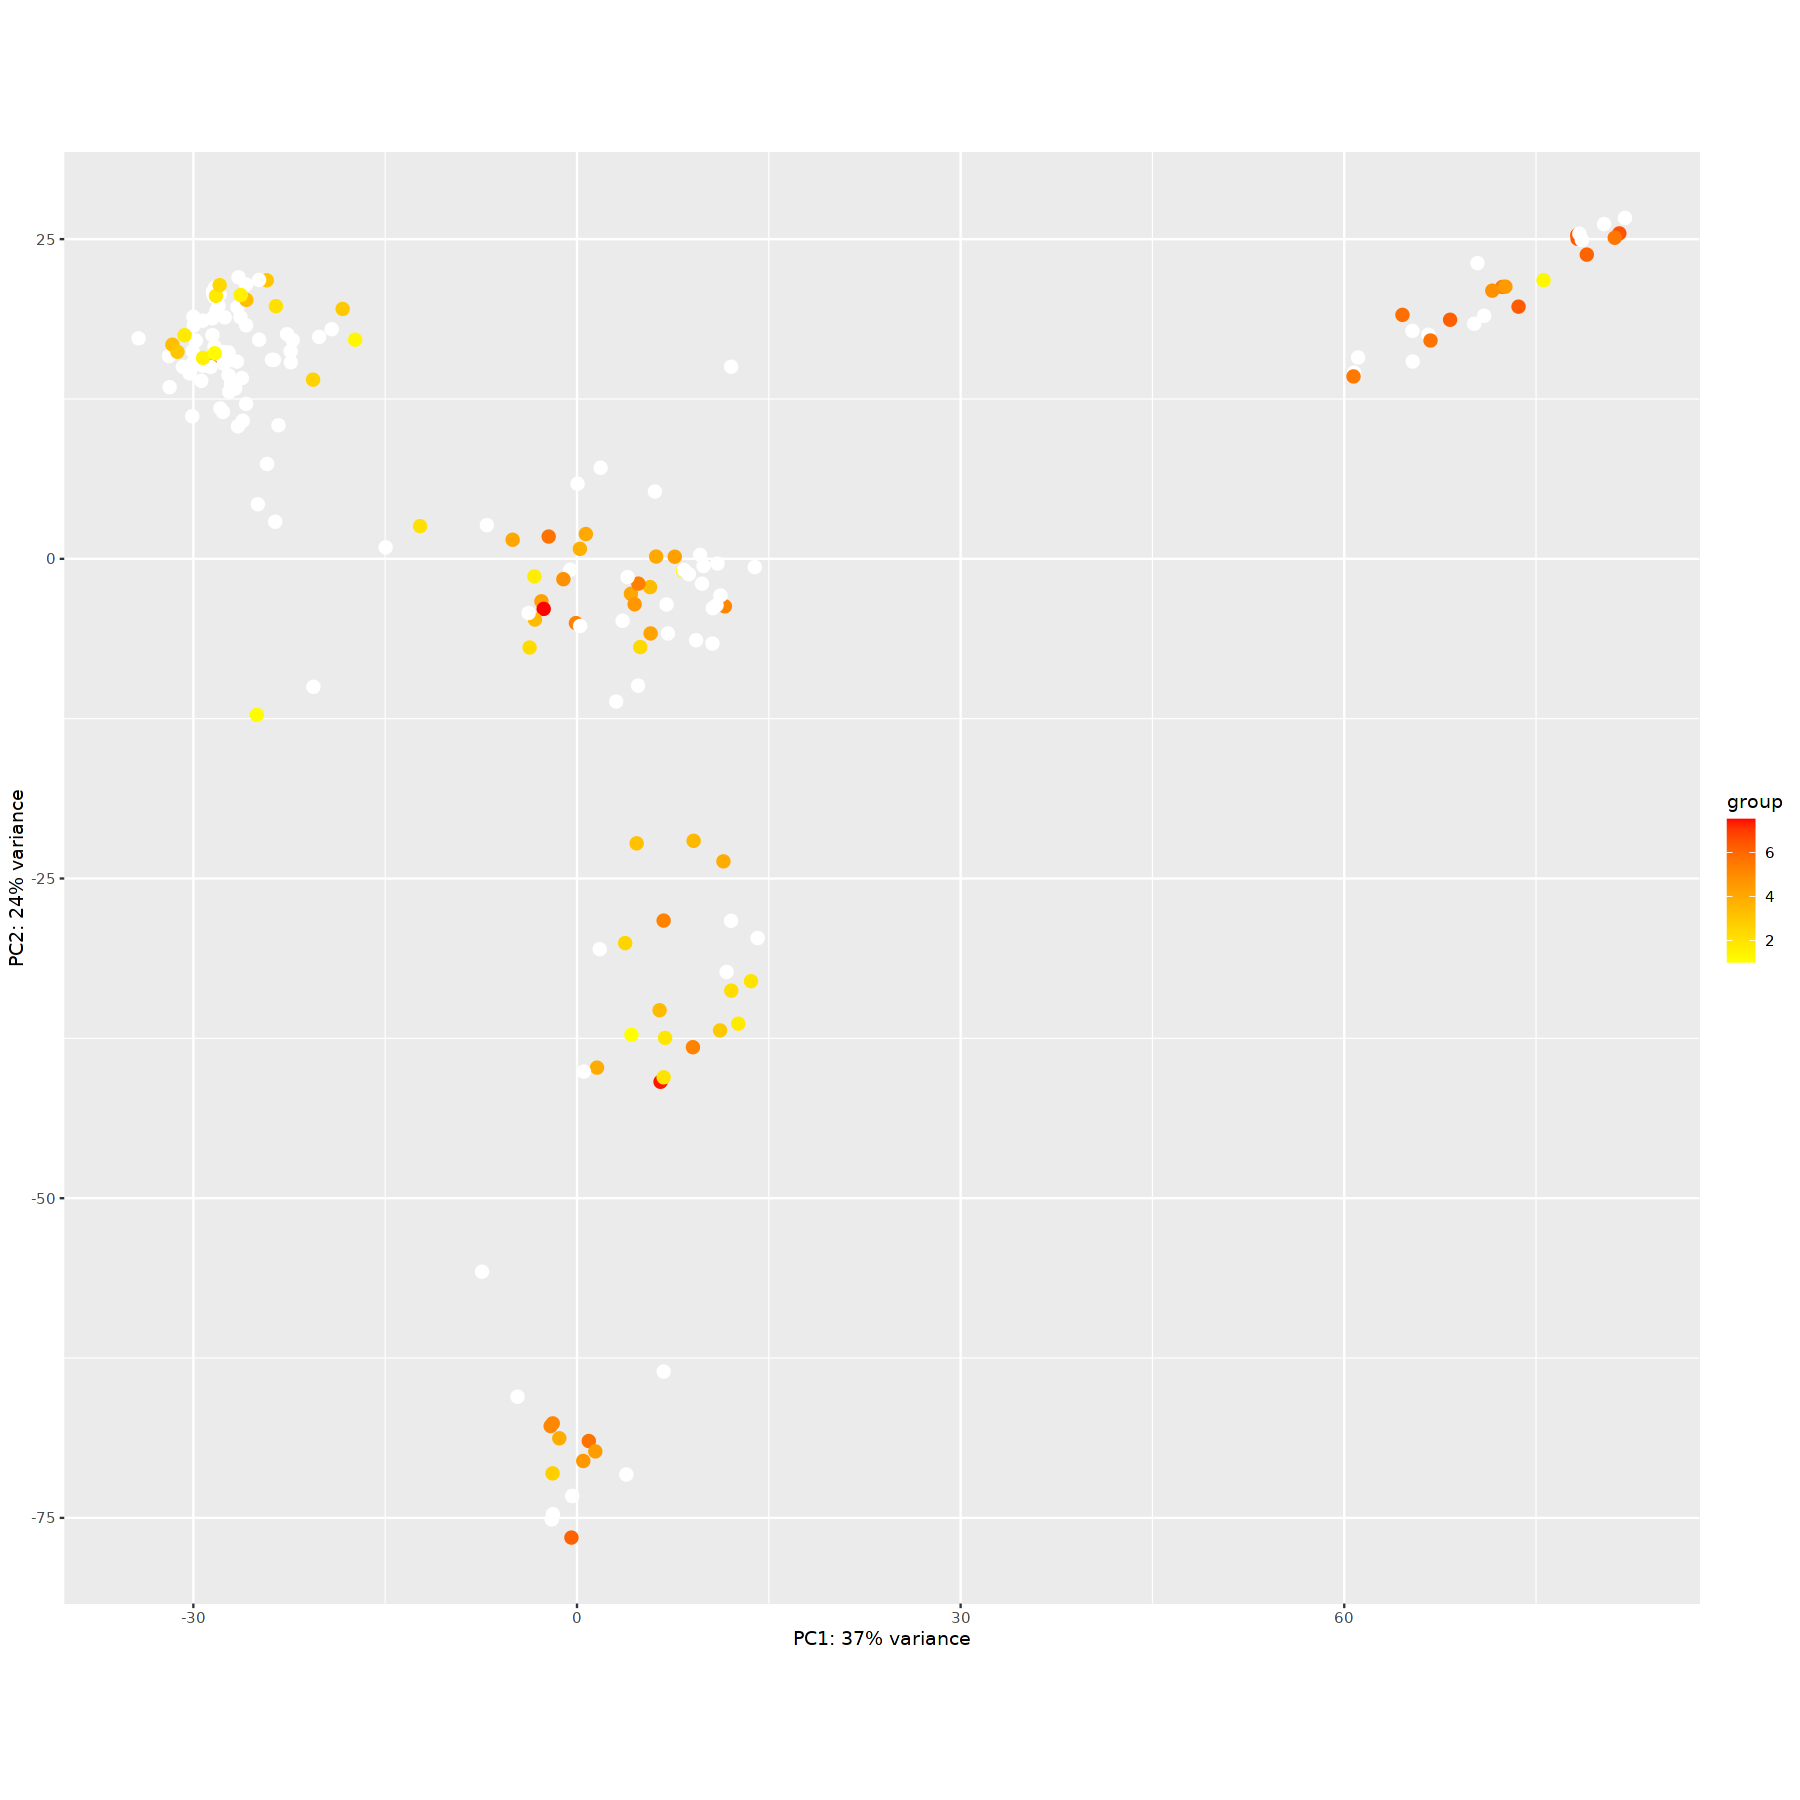

In [63]:
plotPCA(vsn.pass1.subtissue, intgroup='rin.e') + scale_color_gradient(low = "yellow", high = "red", na.value = 'white')


The above looks OK

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 117 rows containing non-finite values (stat_bin).”


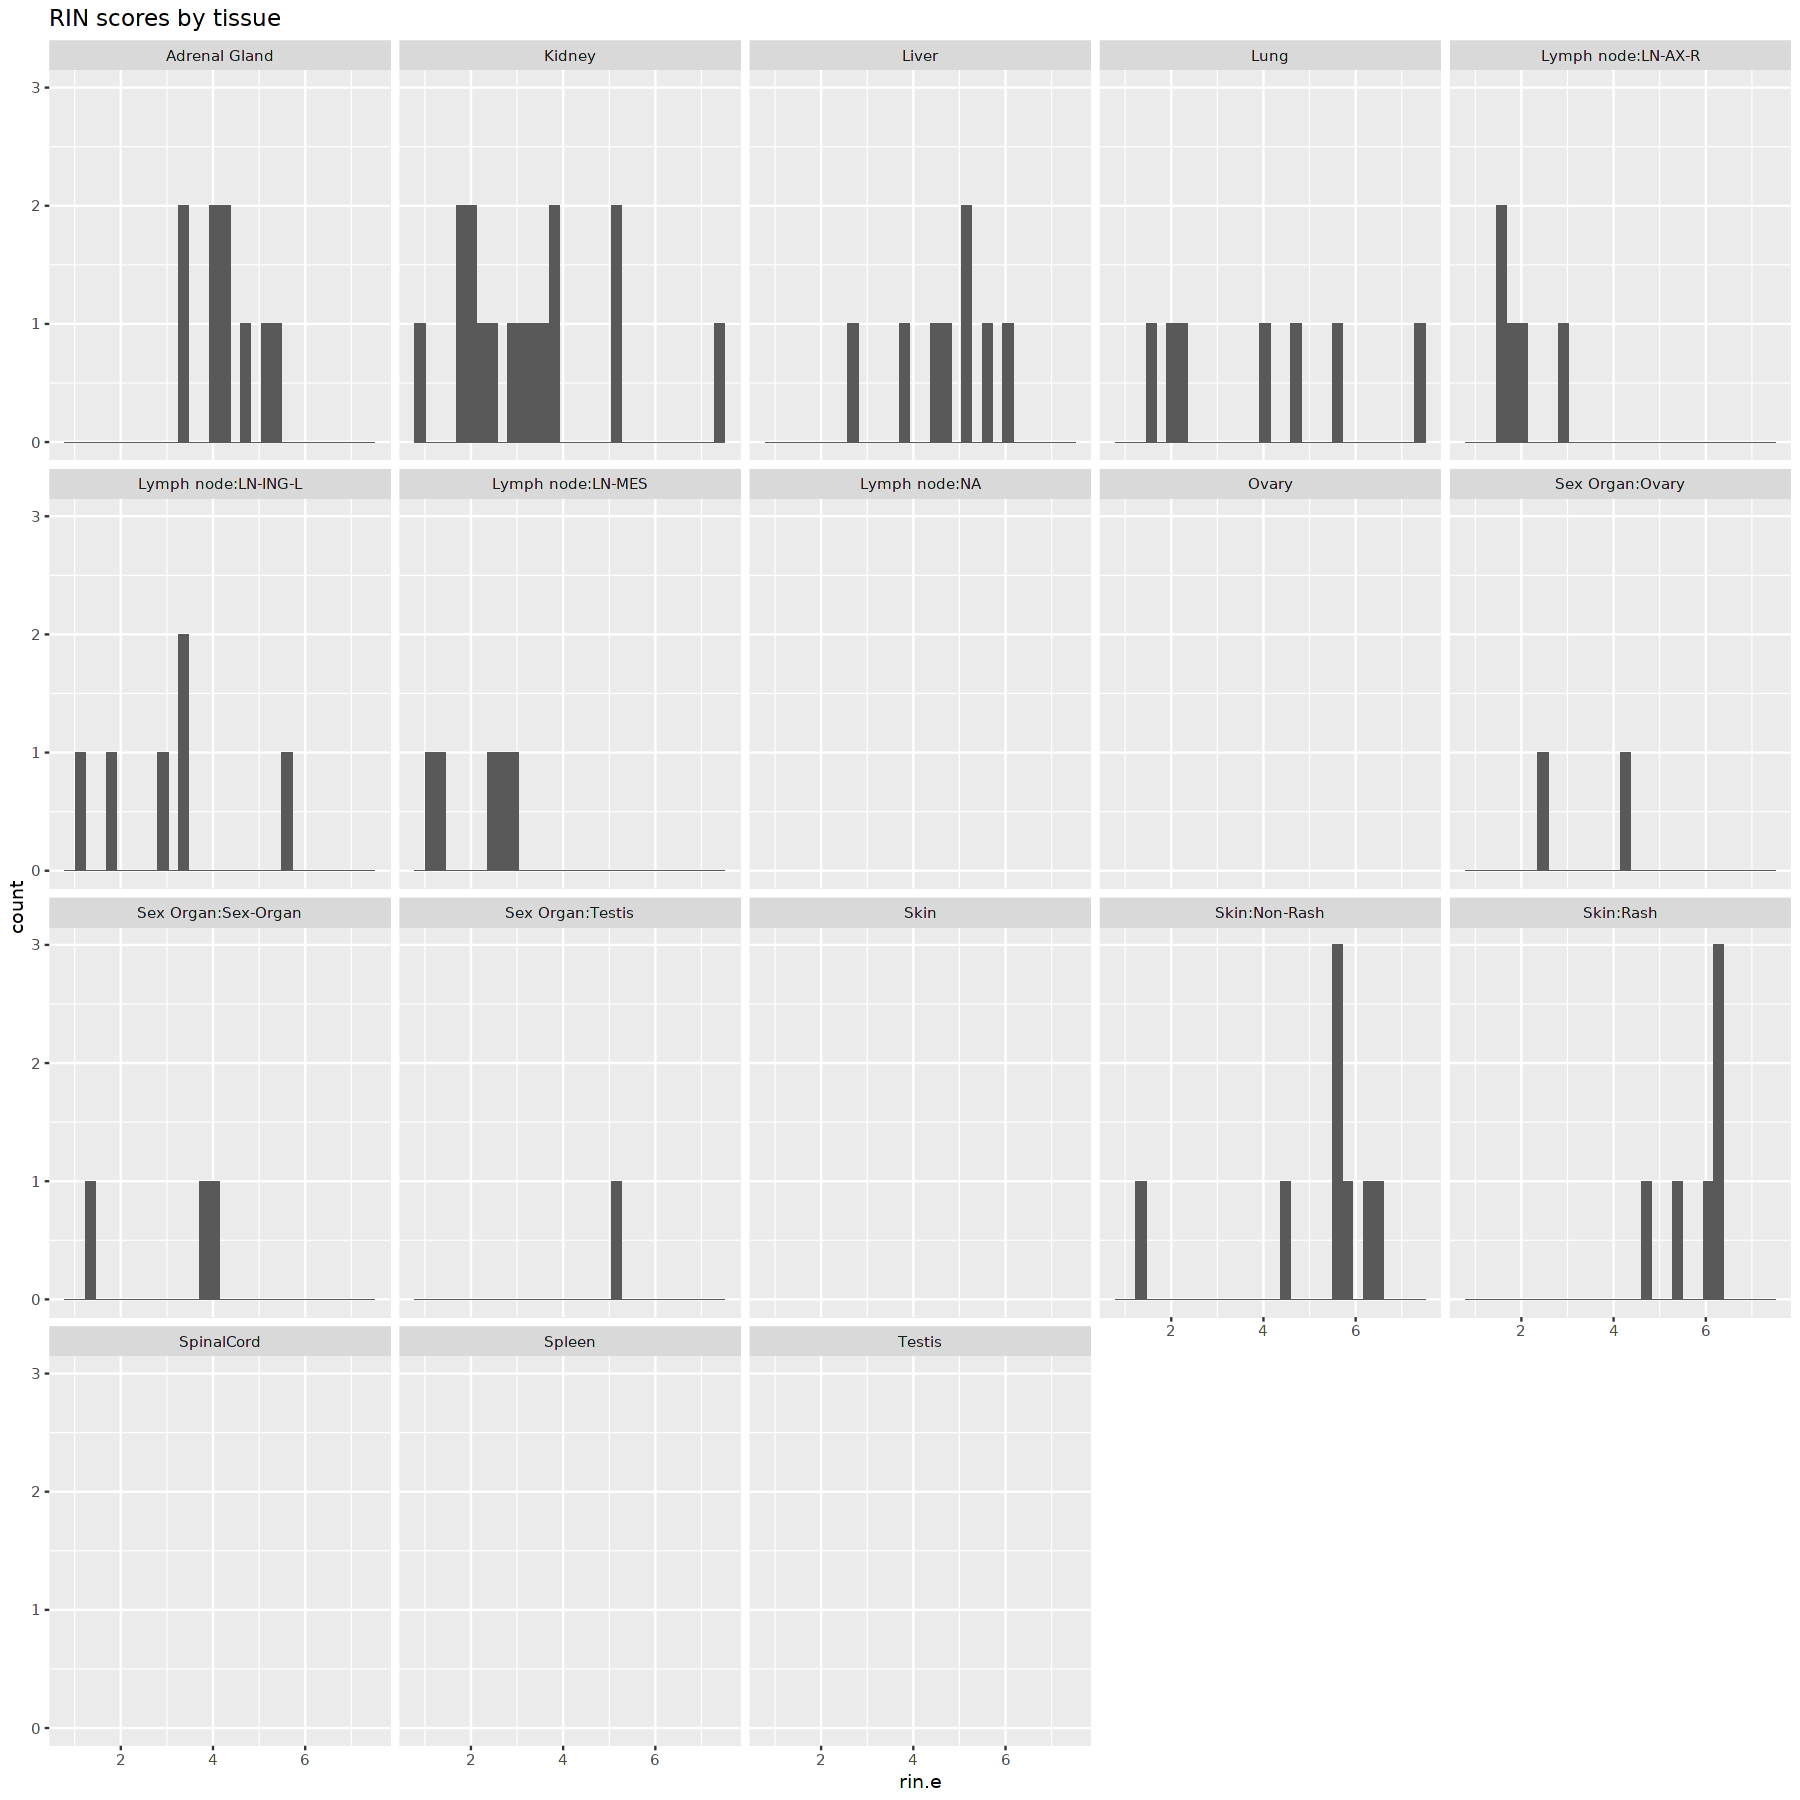

In [64]:
ggplot(as.data.frame(colData(vsn.pass1.subtissue)), aes(x=rin.e)) + 
    geom_histogram() +  facet_wrap(~full.tissue) +
    ggtitle("RIN scores by tissue")

# Filter duplicates

In [65]:
se.qc.pass1

class: SummarizedExperiment 
dim: 35405 314 
metadata(0):
assays(1): counts
rownames(35405): ENSMMUG00000023296.4 ENSMMUG00000036181.3 ... EBOV-L
  EBOV-3pTrailer
rowData names(12): Geneid Chr ... external_gene_source description
colnames(314): A0001_S121_L002 A0002_S124_L002 ...
  Zyagen_D000_Spleen.190507_long_S1 Zyagen_D000_Testis.160421_long_S16
colData names(67): file_identifiers A.identifier ... sample_id_dedup
  duplicate_sequencing

In [66]:
se.qc.pass2 <- se.qc.pass1[,!colData(se.qc.pass1)$duplicate_sequencing]

In [67]:
se.qc.pass2

class: SummarizedExperiment 
dim: 35405 308 
metadata(0):
assays(1): counts
rownames(35405): ENSMMUG00000023296.4 ENSMMUG00000036181.3 ... EBOV-L
  EBOV-3pTrailer
rowData names(12): Geneid Chr ... external_gene_source description
colnames(308): A0001_S121_L002 A0002_S124_L002 ...
  Zyagen_D000_Spleen.190507_long_S1 Zyagen_D000_Testis.160421_long_S16
colData names(67): file_identifiers A.identifier ... sample_id_dedup
  duplicate_sequencing

In [68]:
table(se.qc.pass2$duplicate_sequencing)


FALSE 
  308 

# Fix D-30? sample and set it at D-30

In [69]:
colData(se.qc.pass2)[NA2FALSE(se.qc.pass2$id.cohort == 'D-30?'),'dpi_time'] <- '-30'
colData(se.qc.pass2)[NA2FALSE(se.qc.pass2$id.cohort == 'D-30?'),'dpi_time_factor'] <- '-30'
colData(se.qc.pass2)[NA2FALSE(se.qc.pass2$id.cohort == 'D-30?'),'id.cohort'] <- 'D-30'

In [70]:
se.qc.pass3 <- se.qc.pass2

In [71]:
meta.se.qc.pass3 <- as.data.frame(colData(se.qc.pass3))

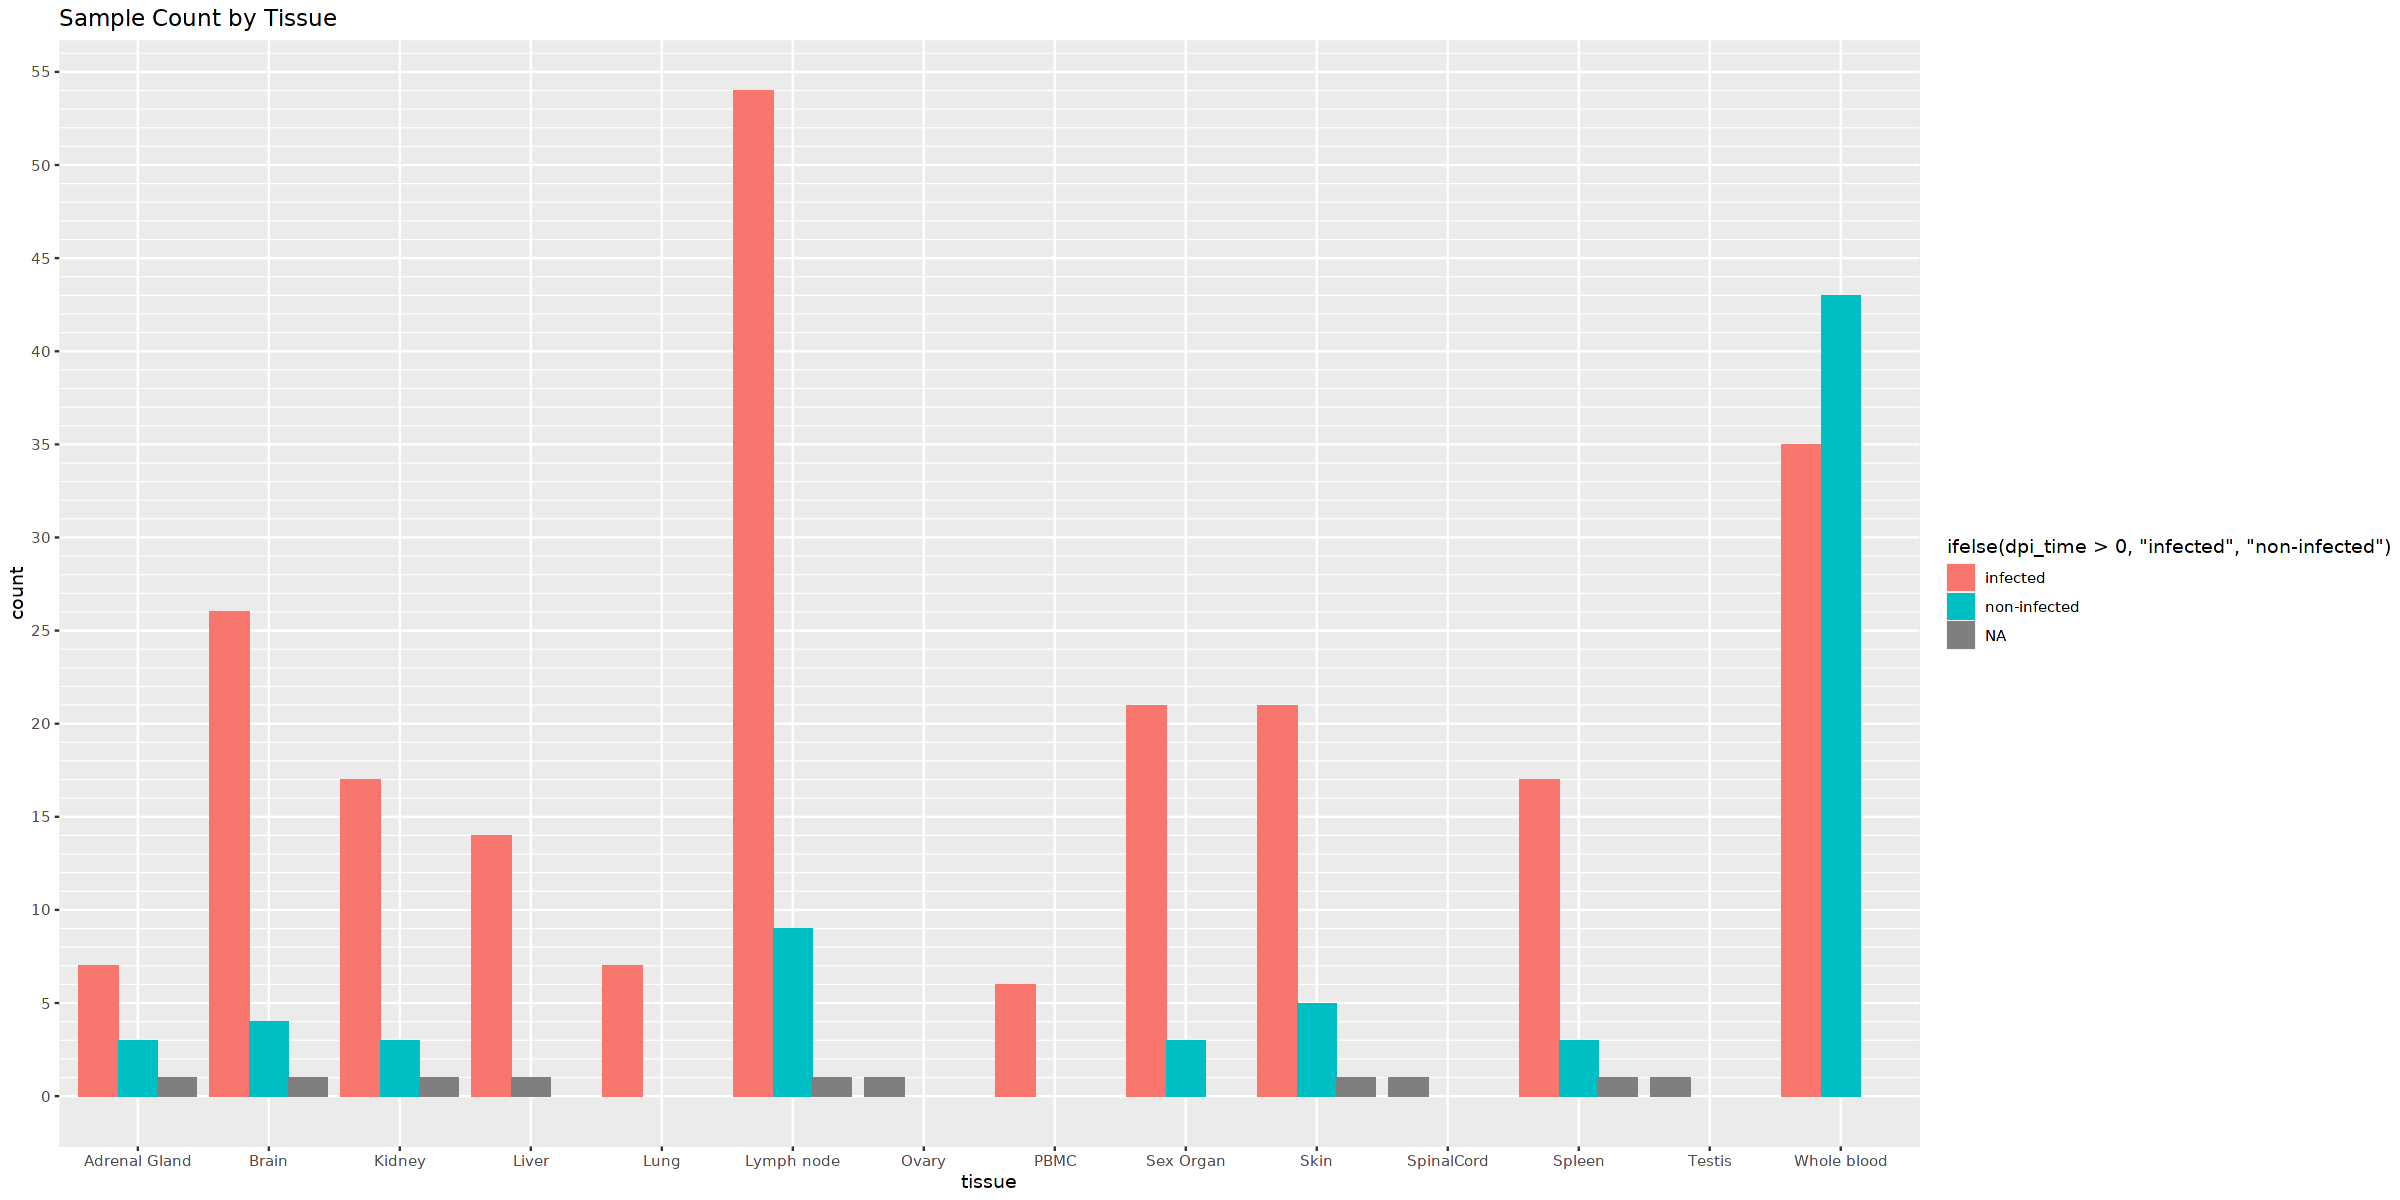

In [72]:
options(repr.plot.width = 20, repr.plot.height = 10)

ggplot(meta.se.qc.pass3, aes(x=tissue, fill=ifelse(dpi_time > 0,'infected','non-infected'))) + 
    geom_bar(position=position_dodge(preserve = "single")) +
    scale_y_continuous(breaks=seq(0,100,5), minor_breaks=seq(0,100,1)) + 
    scale_x_discrete() +
    ggtitle("Sample Count by Tissue")

# Append Extra time factor

In [73]:
dpi_time_2 <- se.qc.pass3$dpi_time
dpi_time_2[dpi_time_2 < 0] <- 0
se.qc.pass3$dpi_time_2 <- dpi_time_2

# Save final object

In [74]:
saveRDS(se.qc.pass3,'se.qc.rds')

In [75]:
se.qc.pass3

class: SummarizedExperiment 
dim: 35405 308 
metadata(0):
assays(1): counts
rownames(35405): ENSMMUG00000023296.4 ENSMMUG00000036181.3 ... EBOV-L
  EBOV-3pTrailer
rowData names(12): Geneid Chr ... external_gene_source description
colnames(308): A0001_S121_L002 A0002_S124_L002 ...
  Zyagen_D000_Spleen.190507_long_S1 Zyagen_D000_Testis.160421_long_S16
colData names(68): file_identifiers A.identifier ...
  duplicate_sequencing dpi_time_2

In [76]:
# Inspect samples remaining after QC

In [77]:
colnames(colData(se.qc.pass3))

[1] "file_identifiers"              "A.identifier"                 
 [3] "biosample"                     "batch.extraction"             
 [5] "irf.study.id"                  "id.cohort"                    
 [7] "id.individual"                 "tissue"                       
 [9] "data.received"                 "dn.rna"                       
[11] "date.broad.extract"            "quant.18s"                    
[13] "quant.18s.sd"                  "quant.kulesh"                 
[15] "quant.kulesh.sd"               "rin.e"                        
[17] "rna.conc.ng.uL"                "lib.conc.pmolar"              
[19] "xgen.index"                    "Assigned"                     
[21] "Unassigned_Unmapped"           "Unassigned_Read_Type"         
[23] "Unassigned_Singleton"          "Unassigned_MappingQuality"    
[25] "Unassigned_Chimera"            "Unassigned_FragmentLength"    
[27] "Unassigned_Duplicate"          "Unassigned_MultiMapping"      
[29] "Unassigned_Secondary"          "Unassigned_NonSplit"          
[31] "Unassigned_NoFeatures"         "Unassigned_Overlapping_Length"
[33] "Unassigned_Ambiguity"          "sub.tissue"                   
[35] "SampleType"                    "study.group"                  
[37] "challenge.group"               "animal.number"                
[39] "animal.tatoo"                  "sex"                          
[41] "weight"                        "birth.date"                   
[43] "viralReadCount"                "hostReadCount"                
[45] "pc.viral.reads"                "cohort.uncertain"             
[47] "cohort.numeric"                "totalReadCount"               
[49] "totalUnassigned"               "chrY_count"                   
[51] "chrX_count"                    "total_count"                  
[53] "Xist"                          "sex.1"                        
[55] "pc_Y"                          "pc_X"                         
[57] "Y_X_ratio"                     "sex_pred"                     
[59] "pred_recorded_sex_mismatch"    "dpi_time"                     
[61] "dpi_time_factor"               "xist_counts"                  
[63] "predicted_sex"                 "pred_rec_sex_mismatch"        
[65] "full.tissue"                   "sample_id_dedup"              
[67] "duplicate_sequencing"          "dpi_time_2"

In [78]:
# post qc
sample.counts.postqc <- table(colData(se.qc.pass3)[,c('full.tissue','dpi_time_factor')])
sample.counts.postqc 

                     dpi_time_factor
full.tissue           -30 -28 -14 -4  0  1  2  3  4  5  6  7  8
  Adrenal Gland         0   0   0  0  3  0  0  1  2  0  1  2  1
  Brain:Brain-Gr        0   0   0  0  3  0  0  3  3  3  5  2  2
  Brain:Brain-Wh        0   0   0  0  1  0  0  1  1  3  1  1  1
  Kidney                0   0   0  0  3  0  0  3  2  3  5  2  2
  Liver                 0   0   0  0  0  0  0  1  3  3  5  0  2
  Lung                  0   0   0  0  0  0  0  1  2  3  1  0  0
  Lymph node:LN-AX-R    0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:LN-ING-L   0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:LN-MES     0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:NA         0   0   0  0  0  0  0  0  0  0  0  0  0
  Ovary                 0   0   0  0  0  0  0  0  0  0  0  0  0
  PBMC                  0   0   0  0  0  0  0  1  1  1  3  0  0
  Sex Organ:Ovary       0   0   0  0  1  0  0  2  0  2  3  2  0
  Sex Organ:Sex-Organ   0   0   0  0  2  0  0  1  3  0  3  0  0
  S

In [79]:
# initial
sample.counts.init <- table(colData(se)[,c("full.tissue","dpi_time")])
sample.counts.init

                     dpi_time
full.tissue           -30 -28 -14 -4  0  1  2  3  4  5  6  7  8
  Adrenal Gland         0   0   0  0  3  0  0  2  2  1  3  2  1
  Brain:Brain-Gr        0   0   0  0  3  0  0  3  3  3  5  2  2
  Brain:Brain-Wh        0   0   0  0  1  0  0  1  1  3  1  2  1
  Kidney                0   0   0  0  3  0  0  3  2  3  5  2  2
  Liver                 0   0   0  0  1  0  0  1  3  3  5  1  2
  Lung                  0   0   0  0  0  0  0  1  2  3  4  1  1
  Lymph node:LN-AX-R    0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:LN-ING-L   0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:LN-MES     0   0   0  0  3  0  0  3  3  3  5  2  2
  Lymph node:NA         0   0   0  0  0  0  0  0  0  0  0  0  0
  Ovary                 0   0   0  0  0  0  0  0  0  0  0  0  0
  PBMC                  0   0   0  0  0  0  0  2  2  1  6  0  0
  Sex Organ:Ovary       0   0   0  0  2  0  0  2  0  2  3  2  0
  Sex Organ:Sex-Organ   0   0   0  0  2  0  0  2  3  1  3  1  0
  Sex Orga

In [80]:
# delta
colnames(sample.counts.init) == colnames(sample.counts.postqc)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [81]:
rownames(sample.counts.init) == rownames(sample.counts.postqc)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

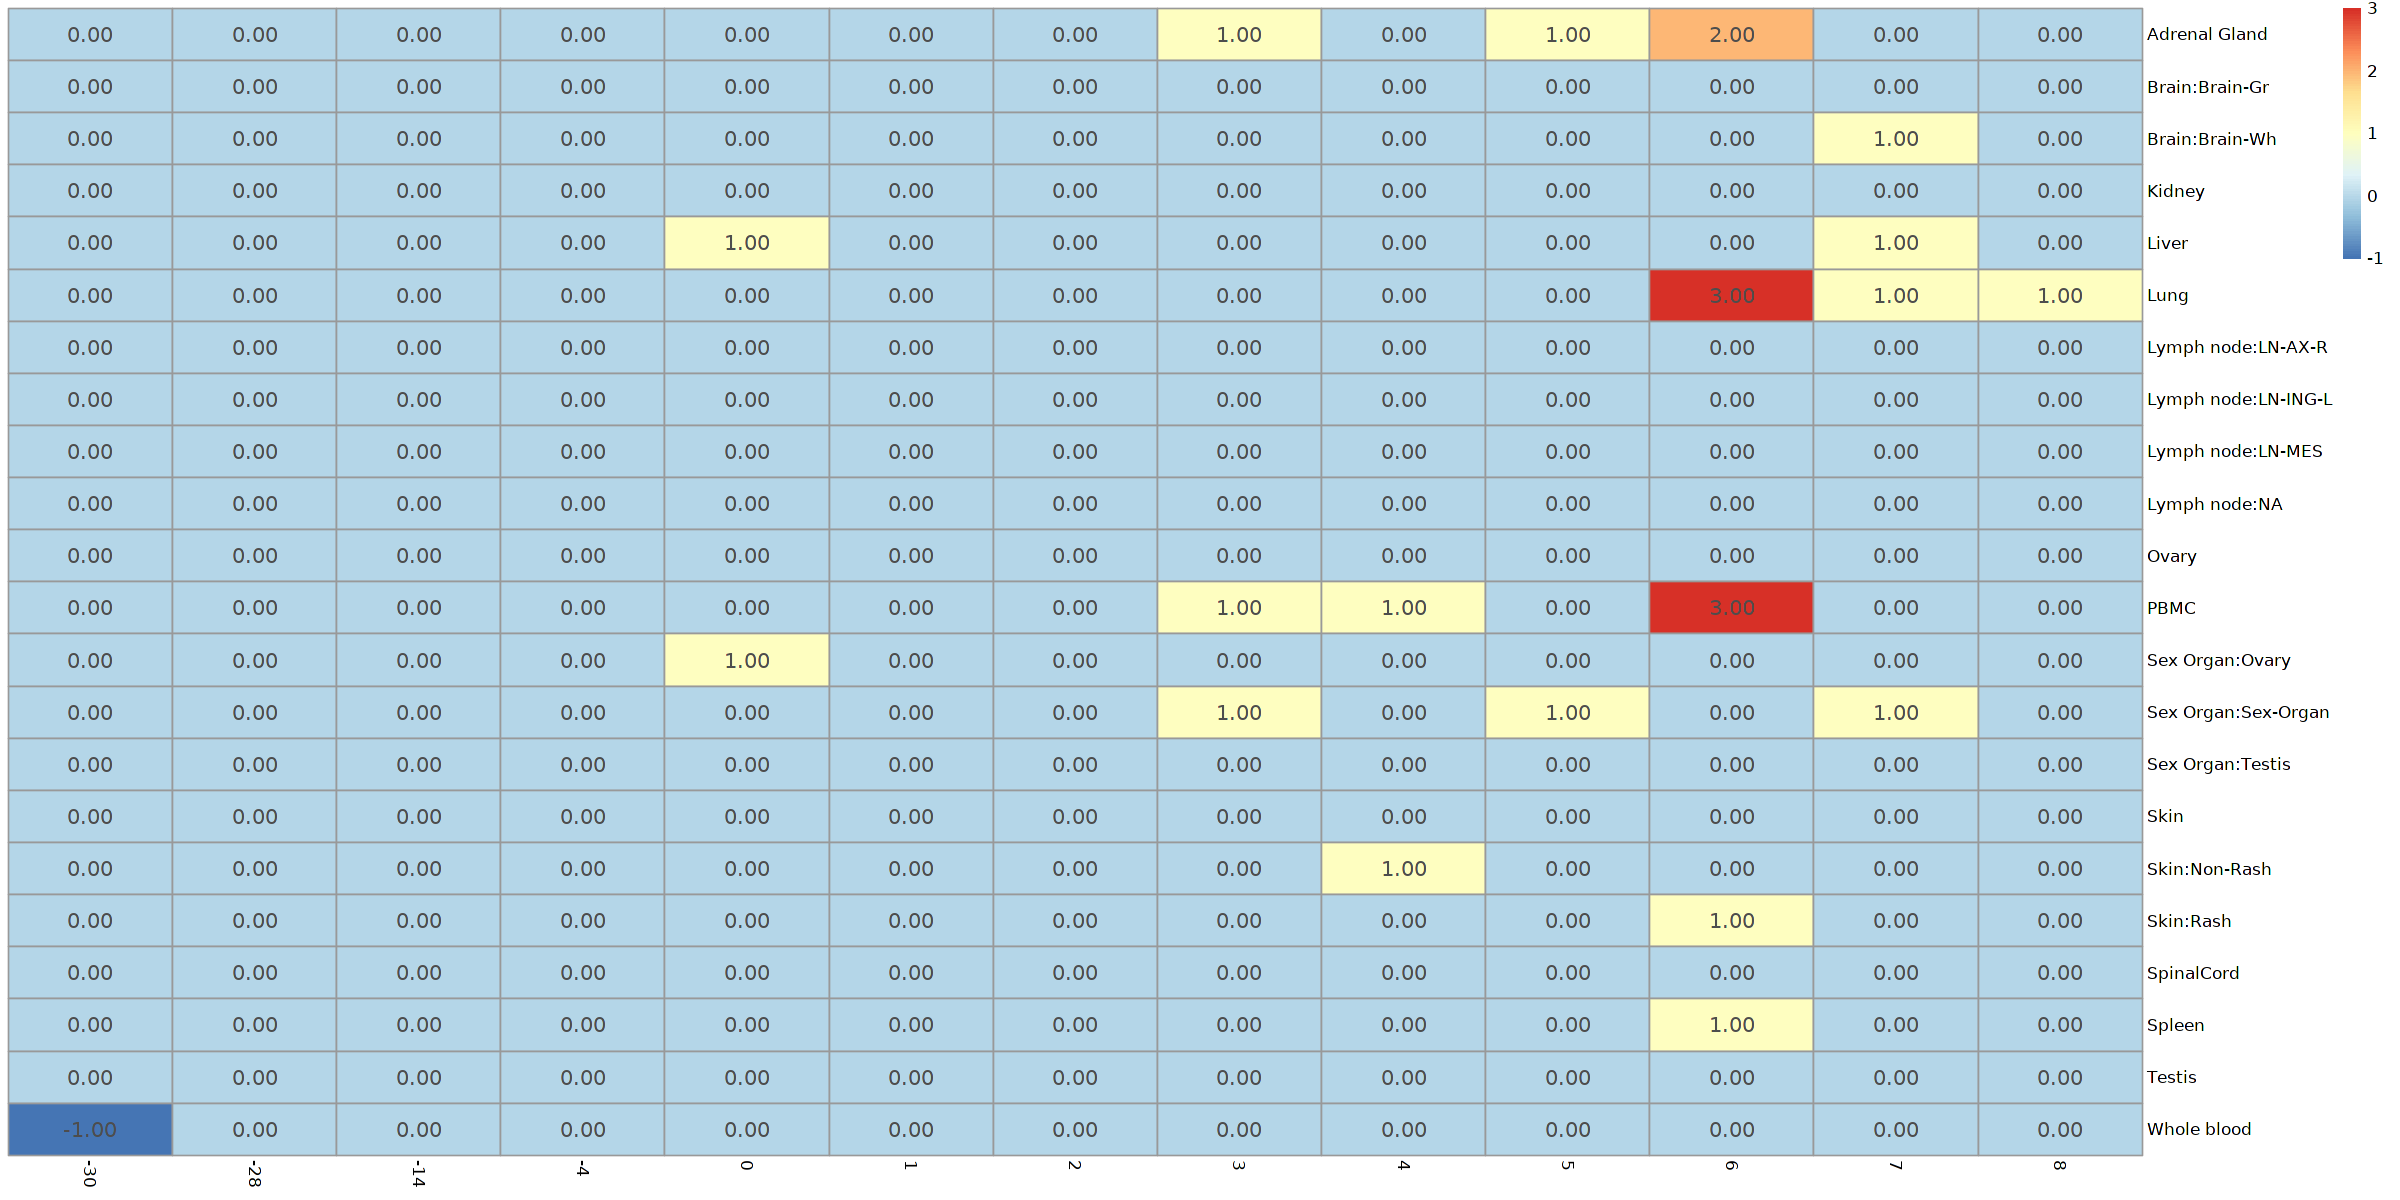

In [82]:
# Heatmap of the samples lost for each sample/tp combination
pheatmap::pheatmap(sample.counts.init - sample.counts.postqc, cluster_cols = FALSE, cluster_rows = FALSE,display_numbers = TRUE, fontsize_number = 12 )

In [83]:
rownames(colData(se)[colData(se)$full.tissue == 'Spleen',])

[1] "A0001_S121_L002"                   "A0015_S120_L002"                  
 [3] "A0029_S119_L002"                   "A0043_S118_L002"                  
 [5] "A0057_S117_L002"                   "A0071_S116_L002"                  
 [7] "A0085_S115_L002"                   "A0099_S114_L002"                  
 [9] "A0113_S113_L002"                   "A0127_S112_L002"                  
[11] "A0141_S111_L002"                   "A0155_S110_L002"                  
[13] "A0169_S109_L002"                   "A0183_S108_L002"                  
[15] "A0197_S107_L002"                   "A0211_S106_L002"                  
[17] "A0225_S24_L001"                    "A0239_S23_L001"                   
[19] "A0253_S22_L001"                    "A0267_S11_L001"                   
[21] "A0281_S10_L001"                    "Zyagen_D000_Spleen.190507_long_S1"

# Save State

In [84]:
fastSave::preserve.state()

[1] "savepoint_2021-09-14_21:26:24_15383.RDataFS"

# Look at Skin Samples in combination with information from Pathologist

In [85]:
library(tidyverse)

In [86]:
data.frame(colData(se)) -> coldata_tmp

In [87]:
coldata_tmp %>% pull(tissue) %>% unique()

[1] Spleen        Kidney        Liver         Brain         Sex Organ    
 [6] Lymph node    Lung          Skin          Adrenal Gland Whole blood  
[11] PBMC          Ovary         SpinalCord    Testis       
14 Levels: Adrenal Gland Brain Kidney Liver Lung Lymph node Ovary ... Whole blood

In [88]:
colnames(coldata_tmp)

[1] "file_identifiers"              "A.identifier"                 
 [3] "biosample"                     "batch.extraction"             
 [5] "irf.study.id"                  "id.cohort"                    
 [7] "id.individual"                 "tissue"                       
 [9] "data.received"                 "dn.rna"                       
[11] "date.broad.extract"            "quant.18s"                    
[13] "quant.18s.sd"                  "quant.kulesh"                 
[15] "quant.kulesh.sd"               "rin.e"                        
[17] "rna.conc.ng.uL"                "lib.conc.pmolar"              
[19] "xgen.index"                    "Assigned"                     
[21] "Unassigned_Unmapped"           "Unassigned_Read_Type"         
[23] "Unassigned_Singleton"          "Unassigned_MappingQuality"    
[25] "Unassigned_Chimera"            "Unassigned_FragmentLength"    
[27] "Unassigned_Duplicate"          "Unassigned_MultiMapping"      
[29] "Unassigned_Secondary"          "Unassigned_NonSplit"          
[31] "Unassigned_NoFeatures"         "Unassigned_Overlapping_Length"
[33] "Unassigned_Ambiguity"          "sub.tissue"                   
[35] "SampleType"                    "study.group"                  
[37] "challenge.group"               "animal.number"                
[39] "animal.tatoo"                  "sex"                          
[41] "weight"                        "birth.date"                   
[43] "viralReadCount"                "hostReadCount"                
[45] "pc.viral.reads"                "cohort.uncertain"             
[47] "cohort.numeric"                "totalReadCount"               
[49] "totalUnassigned"               "chrY_count"                   
[51] "chrX_count"                    "total_count"                  
[53] "Xist"                          "sex.1"                        
[55] "pc_Y"                          "pc_X"                         
[57] "Y_X_ratio"                     "sex_pred"                     
[59] "pred_recorded_sex_mismatch"    "dpi_time"                     
[61] "dpi_time_factor"               "xist_counts"                  
[63] "predicted_sex"                 "pred_rec_sex_mismatch"        
[65] "full.tissue"                   "sample_id_dedup"              
[67] "duplicate_sequencing"

In [89]:
coldata_tmp %>% filter(tissue == 'Skin') %>% 
    select(file_identifiers, id.cohort, id.individual, dn.rna, full.tissue, sex, dpi_time_factor, sub.tissue) %>% 
    arrange(dpi_time_factor, sub.tissue) -> skin_sample_summary

In [90]:
write.csv(skin_sample_summary, "skin_sample_summary.csv")